# FINM 35000 Final Project : ESG Quantile Trading Strategy

<span style="color:blue">Aman Krishna </span> <br>
<br>
<span style="color:#406A5F">Tim Taylor </span> <br>
<br>
<span style="color:purple">Yazmin Ramirez Delgado </span>

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m 
import scipy.stats as stats
import datetime as dt
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from scipy.stats import norm
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', '{:.3f}'.format)
warnings.filterwarnings("ignore")

#### Loading our Index and Factor Data timeseries

In [180]:
# Load esg_data.csv
esg_data = pd.read_csv('esg_data.csv', parse_dates=['date'])
# Drop the first column
esg_data = esg_data.drop(columns=['Unnamed: 0'])
#Take only the data until 2022-08-31
esg_data = esg_data[esg_data['date'] < '2022-08-31']


# Load anti_esg_data.csv
anti_esg_data = pd.read_csv('anti_esg_data.csv', parse_dates=['date'])
# Drop the first column
anti_esg_data = anti_esg_data.drop(columns=['Unnamed: 0'])
#Take only the data until 2022-08-31
anti_esg_data = anti_esg_data[anti_esg_data['date'] < '2022-08-31']

# Load fama_factors.csv
fama_factors = pd.read_csv('fama_factors.csv', parse_dates=['date'])
#Take only the data until 2022-08-31
fama_factors = fama_factors[fama_factors['date'] < '2022-08-31']

In [181]:
esg_data

date  PX_LAST          Security
0      2016-12-06   48.260    ESGU US Equity
1      2016-12-13   49.670    ESGU US Equity
2      2016-12-23   49.310    ESGU US Equity
3      2016-12-29   49.126    ESGU US Equity
4      2017-01-06   49.860    ESGU US Equity
...           ...      ...               ...
271437 2022-08-24   10.190  ESGEMC SW Equity
271438 2022-08-25   10.190  ESGEMC SW Equity
271439 2022-08-26   10.190  ESGEMC SW Equity
271440 2022-08-29   10.152  ESGEMC SW Equity
271441 2022-08-30   10.152  ESGEMC SW Equity

[216653 rows x 3 columns]

In [182]:
anti_esg_data

date  PX_LAST        Security
0    2022-08-09   25.570  DRLL US Equity
1    2022-08-10   25.760  DRLL US Equity
2    2022-08-11   26.610  DRLL US Equity
3    2022-08-12   26.820  DRLL US Equity
4    2022-08-15   26.370  DRLL US Equity
...         ...      ...             ...
4472 2022-08-24   25.400  WWJD US Equity
4473 2022-08-25   25.630  WWJD US Equity
4474 2022-08-26   24.993  WWJD US Equity
4475 2022-08-29   24.940  WWJD US Equity
4476 2022-08-30   24.850  WWJD US Equity

[3243 rows x 3 columns]

In [183]:
fama_factors['date'] = pd.to_datetime(fama_factors['date'])
fama_factors.set_index('date', inplace=True)
fama_factors

mktrf    smb    hml    rmw    cma    rf    umd
date                                                      
2010-01-04  0.017  0.008  0.011 -0.002  0.002 0.000  0.006
2010-01-05  0.003 -0.004  0.012 -0.002  0.002 0.000  0.006
2010-01-06  0.001 -0.001  0.006 -0.001  0.002 0.000 -0.000
2010-01-07  0.004  0.003  0.010 -0.007  0.002 0.000 -0.009
2010-01-08  0.003  0.003  0.000  0.002 -0.004 0.000  0.002
...           ...    ...    ...    ...    ...   ...    ...
2022-08-24  0.004  0.005 -0.006 -0.014 -0.005 0.000 -0.008
2022-08-25  0.015  0.001 -0.000  0.002 -0.004 0.000 -0.008
2022-08-26 -0.034 -0.003  0.017  0.002  0.009 0.000  0.019
2022-08-29 -0.007 -0.004  0.004  0.003  0.004 0.000  0.006
2022-08-30 -0.011 -0.004 -0.002 -0.002  0.001 0.000 -0.009

[3187 rows x 7 columns]

#### Loading the Media Climate Change Concerns Index data from Sentometrics Research

In [184]:
news_shocks = pd.read_excel("Sentometrics_US_Media_Climate_Change_Index.xlsx",sheet_name="2023 update daily", skiprows=6, parse_dates=['Date'])

In [185]:
news_shocks = news_shocks.rename(columns={"Date": "date"})
news_shocks.set_index('date', inplace=True)
news_shocks.index = pd.to_datetime(news_shocks.index)

In [186]:
news_shocks

Aggregate  cluster_Business Impact  cluster_Environmental Impact  \
date                                                                           
2003-01-01      0.298                    0.358                         0.144   
2003-01-02      0.479                    0.089                         0.626   
2003-01-03      0.370                    0.048                         0.501   
2003-01-04      0.000                    0.000                         0.000   
2003-01-05      0.100                    0.098                         0.107   
...               ...                      ...                           ...   
2022-08-27      1.004                    0.944                         1.083   
2022-08-28      0.799                    0.463                         0.917   
2022-08-29      0.781                    0.711                         0.718   
2022-08-30      1.093                    0.535                         1.163   
2022-08-31      2.281                    1.240                         2.437   

            cluster_Societal Debate  cluster_Research  Agreements/Actions  \
date                                                                        
2003-01-01                    0.306             0.042               0.082   
2003-01-02                    0.234             0.576               0.116   
2003-01-03                    0.081             0.457               0.049   
2003-01-04                    0.000             0.000               0.000   
2003-01-05                    0.061             0.030               0.019   
...                             ...               ...                 ...   
2022-08-27                    0.639             0.380               0.506   
2022-08-28                    0.632             0.770               0.338   
2022-08-29                    0.773             0.363               0.285   
2022-08-30                    1.041             0.996               0.381   
2022-08-31                    1.524             2.554               1.579   

            Agriculture Shifts  Airline Industry  Arctic Wildlife  \
date                                                                
2003-01-01               0.197             0.086            0.060   
2003-01-02               0.153             0.061            0.093   
2003-01-03               0.071             0.079            0.038   
2003-01-04               0.000             0.000            0.000   
2003-01-05               0.046             0.028            0.080   
...                        ...               ...              ...   
2022-08-27               0.810             0.904            0.959   
2022-08-28               0.993             0.668            0.167   
2022-08-29               1.241             0.289            0.094   
2022-08-30               1.094             0.279            0.207   
2022-08-31               1.386             1.168            0.487   

            Car Industry  ...  Hurricanes/Floods  Legal Actions  \
date                      ...                                     
2003-01-01         0.361  ...              0.045          0.290   
2003-01-02         0.071  ...              0.118          0.083   
2003-01-03         0.041  ...              0.158          0.015   
2003-01-04         0.000  ...              0.000          0.000   
2003-01-05         0.026  ...              0.088          0.118   
...                  ...  ...                ...            ...   
2022-08-27         1.247  ...              0.417          0.496   
2022-08-28         0.393  ...              0.583          0.143   
2022-08-29         0.954  ...              0.486          0.757   
2022-08-30         0.200  ...              0.595          0.264   
2022-08-31         0.899  ...              1.503          0.623   

            Marine Wildlife  Political Campaign  Renewable Energy  \
date                                                                
2003-01-01            0.040               0.234             0

### Exploratory Data Analysis

#### Correlations

#### ESG

In [187]:
esg_ts = esg_data.pivot(index='date', columns='Security', values='PX_LAST')
antiesg_ts = anti_esg_data.pivot(index='date', columns='Security', values='PX_LAST')

# Create a return dataframe
esg_ret = esg_ts.pct_change()
antiesg_ret = antiesg_ts.pct_change()

In [188]:
esg_ret

Security    00878 TT Equity  2319881D FP Equity  2319883D GR Equity  \
date                                                                  
2010-01-04              NaN                 NaN                 NaN   
2010-01-05              NaN                 NaN                 NaN   
2010-01-06              NaN                 NaN                 NaN   
2010-01-07              NaN                 NaN                 NaN   
2010-01-08              NaN                 NaN                 NaN   
...                     ...                 ...                 ...   
2022-08-24           -0.002               0.002              -0.000   
2022-08-25            0.004               0.003               0.010   
2022-08-26            0.005              -0.012              -0.026   
2022-08-29           -0.014              -0.014              -0.005   
2022-08-30            0.004              -0.008              -0.013   

Security    2319884D IM Equity  2322470D FP Equity  2322471D IM Equity  \
date                                                                     
2010-01-04                 NaN                 NaN                 NaN   
2010-01-05                 NaN                 NaN                 NaN   
2010-01-06                 NaN                 NaN                 NaN   
2010-01-07                 NaN                 NaN                 NaN   
2010-01-08                 NaN                 NaN                 NaN   
...                        ...                 ...                 ...   
2022-08-24               0.002               0.005               0.006   
2022-08-25               0.003               0.005               0.004   
2022-08-26              -0.013              -0.014              -0.015   
2022-08-29              -0.014              -0.018              -0.020   
2022-08-30              -0.008              -0.015              -0.013   

Security    2322472D NA Equity  2323924D IM Equity  2323926D FP Equity  \
date                                                                     
2010-01-04                 NaN                 NaN                 NaN   
2010-01-05                 NaN               0.002               0.003   
2010-01-06                 NaN               0.004               0.003   
2010-01-07                 NaN               0.008               0.008   
2010-01-08                 NaN               0.002              -0.002   
...                        ...                 ...                 ...   
2022-08-24               0.004               0.006               0.007   
2022-08-25               0.003               0.003               0.003   
2022-08-26              -0.012              -0.016              -0.015   
2022-08-29              -0.017              -0.022              -0.021   
2022-08-30              -0.011              -0.012              -0.013   

Security    2323927D FP Equity  ...  WHCS NA Equity  WITS NA Equity  \
date                            ...                                   
2010-01-04                 NaN  ...             NaN             NaN   
2010-01-05                 NaN  ...             NaN             NaN   
2010-01-06                 NaN  ...             NaN             NaN   
2010-01-07                 NaN  ...             NaN             NaN   
2010-01-08                 NaN  ...             NaN             NaN   
...                        ...  ...             ...             ...   
2022-08-24               0.005  ...           0.004           0.002   
2022-08-25               0.004  ...           0.002           0.001   
2022-08-26              -0.014  ...          -0.005          -0.017   
2022-08-29              -0.022  ...          -0.020          -0.028   
2022-08-30              -0.012  ...          -0.003          -0.010   

Security    WQDA NA Equity  XACTC25 DC Equity  XACTOMX SS Equity  \
date                                                               
2010-01-04             NaN                NaN                NaN   
2010-01-05            

In [189]:
# Assuming esg_data_pivot is the pivoted ESG data
correlation_matrix = esg_ret.corr()

# Flatten the correlation matrix and sort to find the top 10 correlations
flattened_corr = correlation_matrix.unstack().sort_values(ascending=False).dropna()

# Exclude self-correlations (correlation of an index with itself)
top_correlations = flattened_corr[flattened_corr.index.get_level_values(0) != flattened_corr.index.get_level_values(1)]

# Exclude the even-numbered correlations (which are just the reverse of the odd-numbered correlations)
top_correlations = top_correlations[::2]

# # Get the top 10 correlations
top_20_correlations = top_correlations.head(20)
bottom_20_correlations = top_correlations.tail(20)

# Display the top 10 correlations
print("Top 20 ESG correlations:")
print(top_20_correlations)

Top 20 ESG correlations:
Security            Security          
ESGEMD SE Equity    ESGEMD SW Equity     1.000
ESGMEX MF Equity    ESGMEX MM Equity     1.000
ESGGB SE Equity     ESGGB SW Equity      1.000
2323927D FP Equity  USAC FP Equity       1.000
2323924D IM Equity  LUSA IM Equity       1.000
2322471D IM Equity  NRAM IM Equity       1.000
USAC FP Equity      2323927D FP Equity   1.000
NAMU NA Equity      2322472D NA Equity   1.000
2322470D FP Equity  NRAM FP Equity       1.000
NRAM IM Equity      JREU IM Equity       0.996
JREU IM Equity      NRAM IM Equity       0.996
2322472D NA Equity  U500 NA Equity       0.996
NAMU NA Equity      U500 NA Equity       0.996
2322471D IM Equity  2323924D IM Equity   0.996
LUSA IM Equity      2322471D IM Equity   0.996
                    NRAM IM Equity       0.996
2323924D IM Equity  NRAM IM Equity       0.996
ESGU GY Equity      SPPY GY Equity       0.995
2322471D IM Equity  ESGU IM Equity       0.995
ESGU IM Equity      2322471D IM Equity   0.

In [190]:
print("Bottom 20 ESG correlations:")
print(bottom_20_correlations)

Bottom 20 ESG correlations:
Security           Security        
ESGE IM Equity     ESGGBS SW Equity   -0.155
QDVW GY Equity     ESGGB SE Equity    -0.158
                   ESGGB SW Equity    -0.158
E40 FP Equity      ESGGBS SW Equity   -0.167
ESGGBS SW Equity   C40 FP Equity      -0.167
ESGGB SE Equity    ENRG FP Equity     -0.168
ENRG FP Equity     ESGGB SW Equity    -0.168
QDVX GY Equity     ESGGBS SW Equity   -0.170
XACTOMX SS Equity  ESGGBS SW Equity   -0.172
ESGGBS SW Equity   ESGE SW Equity     -0.174
ESGE LN Equity     ESGGBS SW Equity   -0.175
ESGGBS SW Equity   CMU FP Equity      -0.181
ENRG FP Equity     USCR LN Equity     -0.184
                   ESGB US Equity     -0.187
SESG US Equity     00878 TT Equity    -0.195
ENRG FP Equity     AEGE GY Equity     -0.231
SESG US Equity     AFRN FP Equity     -0.243
ESGGBD SE Equity   ENRG FP Equity     -0.243
EFRN GY Equity     IE3E GY Equity     -0.249
AFLT FP Equity     SESG US Equity     -0.353
dtype: float64


Several key points to consider in this context:

Identical Tickers with Different Market Identifiers: Some of the securities listed (e.g., ESGMEX MM Equity and ESGMEX MF Equity, ESGGB SW Equity and ESGGB SE Equity) likely represent the same underlying asset or fund but are listed on different exchanges or come in different classes (like mutual funds vs. equities). This would explain the perfect correlation (1.000) as they are essentially the same product traded in different venues or formats.

Related or Similar Securities: Securities like ENGUS FP Equity and ENG FP Equity, or USAC FP Equity and 2323927D FP Equity, might be different classes of shares of the same company or related instruments (like a parent company and its subsidiary), which would explain their very high correlations.

Market or Sector Trends: Some correlations may reflect broader market or sector trends. For example, securities like HK IM Equity and CINA IM Equity might both be heavily influenced by the same economic factors if they are linked to the same country or region.

ETFs and Index Tracking: Securities like SNPE US Equity and EFIV US Equity might be exchange-traded funds (ETFs) or other instruments that track similar indices or have similar investment strategies, leading to high correlations.

Data Quality and Timeframe: The quality of the data and the timeframe used for the correlation analysis can greatly impact the results. Correlations can vary over different time horizons.

Investment Analysis and Risk Management: From an investment perspective, such high correlations suggest that holding both securities in a portfolio may not provide significant diversification benefits, as they tend to move together. For risk management, it's crucial to understand why these correlations exist (e.g., are they due to fundamental relationships or temporary market conditions?)

In [191]:
# Remove one of the two stocks in each pair of highly correlated stocks > 0.95
# Create a list of all the stocks to be removed
stocks_to_remove = []
for i in range(0, len(top_correlations), 2):
    # Check if the correlation is greater than 0.95
    if round(top_correlations[i],2) == 0.95:
        # Check if the first stock is not already in the list of stocks to remove
        if top_correlations.index.get_level_values(0)[i] not in stocks_to_remove:
            # Add the first stock to the list of stocks to remove
            stocks_to_remove.append(top_correlations.index.get_level_values(0)[i])

# Remove the stocks from the pivot table
esg_ret_filt = esg_ret.drop(columns=stocks_to_remove)

#### Anti-ESG

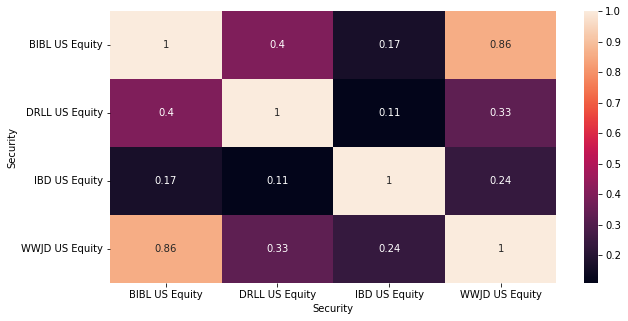

In [192]:
correlation_matrix1 = antiesg_ret.corr()

# Use seaborn to plot the correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix1, annot=True)
plt.show()

#### News Factors

In [193]:
correlation_matrix2 = news_shocks.corr()

# Flatten the correlation matrix and sort to find the top 10 correlations
flattened_corr2 = correlation_matrix2.unstack().sort_values(ascending=False).dropna()

# Exclude self-correlations (correlation of an index with itself)
top_correlations2 = flattened_corr2[flattened_corr2.index.get_level_values(0) != flattened_corr2.index.get_level_values(1)]

# Exclude the even-numbered correlations (which are just the reverse of the odd-numbered correlations)
top_correlations2 = top_correlations2[::2]

# # Get the top 10 correlations
top_20_correlations2 = top_correlations2.head(20)
bottom_20_correlations2 = top_correlations2.tail(20)

# Display the top 10 correlations
print("Top 20 NEWS correlations:")
print(top_20_correlations2)

Top 20 NEWS correlations:
UN/IPCC Reports          cluster_Research               0.930
cluster_Research         Global Warming                 0.916
cluster_Societal Debate  Social Events                  0.915
Aggregate                cluster_Business Impact        0.901
cluster_Societal Debate  Political Campaign             0.897
Aggregate                cluster_Societal Debate        0.897
Agreements/Actions       cluster_Business Impact        0.872
Aggregate                cluster_Environmental Impact   0.869
cluster_Research         Aggregate                      0.848
                         Scientific Studies             0.840
Aggregate                Government Programs            0.831
cluster_Societal Debate  Controversies                  0.829
Social Events            Aggregate                      0.812
Extreme Temperatures     cluster_Environmental Impact   0.812
Government Programs      cluster_Business Impact        0.808
UN/IPCC Reports          Aggregate          

In [194]:
print("Bottom 20 NEWS correlations:")
print(bottom_20_correlations2)

Bottom 20 NEWS correlations:
Airline Industry                 Arctic Wildlife                   0.306
Ecosystems                       Climate Legislation/Regulations   0.305
Arctic Wildlife                  Agriculture Shifts                0.303
Climate Legislation/Regulations  Arctic Wildlife                   0.300
                                 Marine Wildlife                   0.299
Marine Wildlife                  Carbon Credits Market             0.298
Glaciers/Ice Sheets              Carbon Reduction Technologies     0.296
Food Shortage/Poverty            Arctic Wildlife                   0.295
Hurricanes/Floods                Arctic Wildlife                   0.292
Car Industry                     Glaciers/Ice Sheets               0.290
Carbon Tax                       Arctic Wildlife                   0.285
Ecosystems                       Carbon Credits Market             0.280
Marine Wildlife                  Car Industry                      0.279
Glaciers/Ice Sheets   

#### Cross Correlation of Indices against Factors

In [195]:
market_correlations = pd.DataFrame(index=esg_ret_filt.columns, columns=['mkt_correlation'])

for i in range(0, len(esg_ret_filt.columns)):
    correlation_series = esg_ret_filt.iloc[:,i]
    correlation_matrix3 = fama_factors.corrwith(correlation_series)
    market_correlations.loc[esg_ret_filt.columns[i], 'mkt_correlation'] = correlation_matrix3[0]
    
market_correlations.dropna(inplace=True)

# Only keep stocks with a market correlation less than 0.2
market_correlations = market_correlations[market_correlations['mkt_correlation'] < 0.2]
market_correlations

# Keep only the Security in market_correlations
esg_ret_filt_mkt = esg_ret_filt[market_correlations.index]

---

In [196]:
len(esg_ret_filt_mkt.columns)

29

#### Regression of non-US (<0.2 Mkt Beta) ESG Indices against News Factors and Fama French Factors

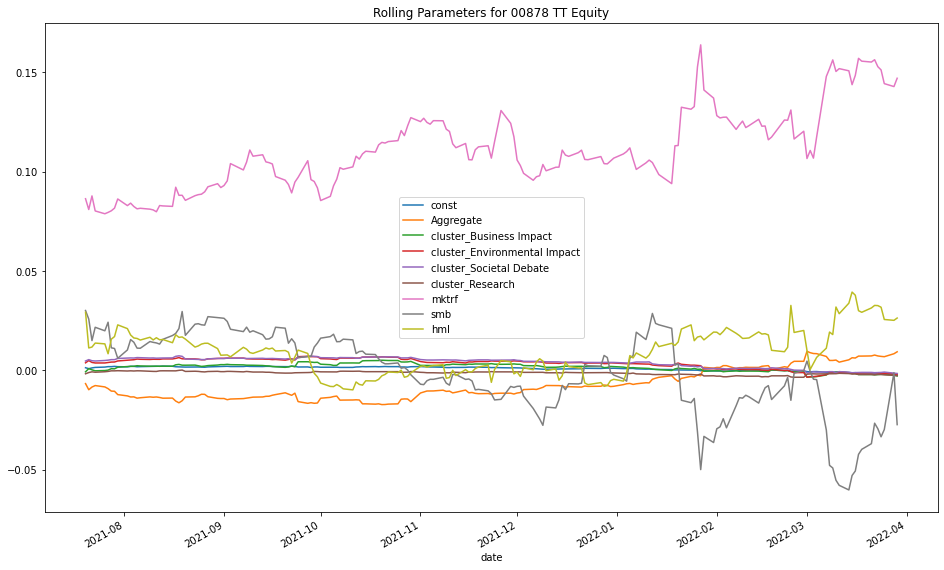

Error in column:  1


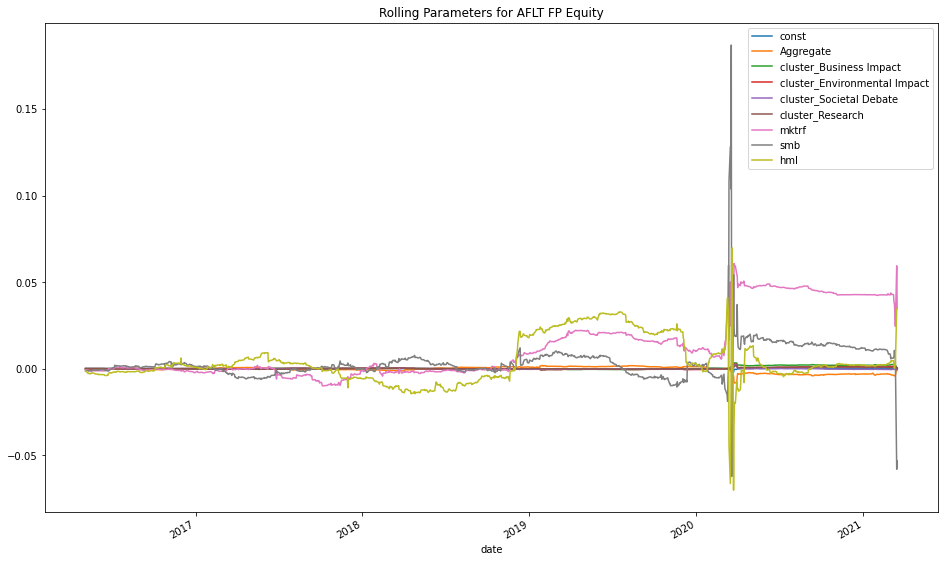

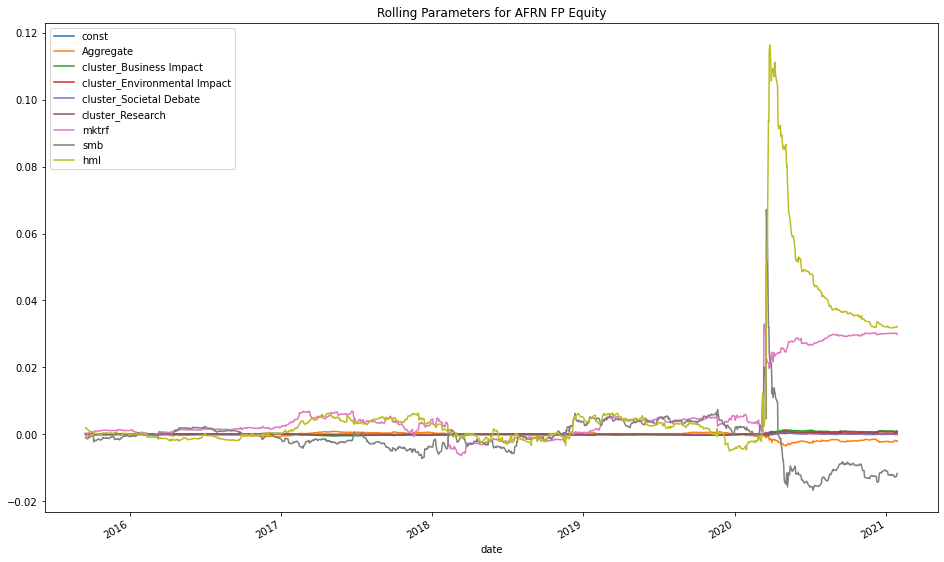

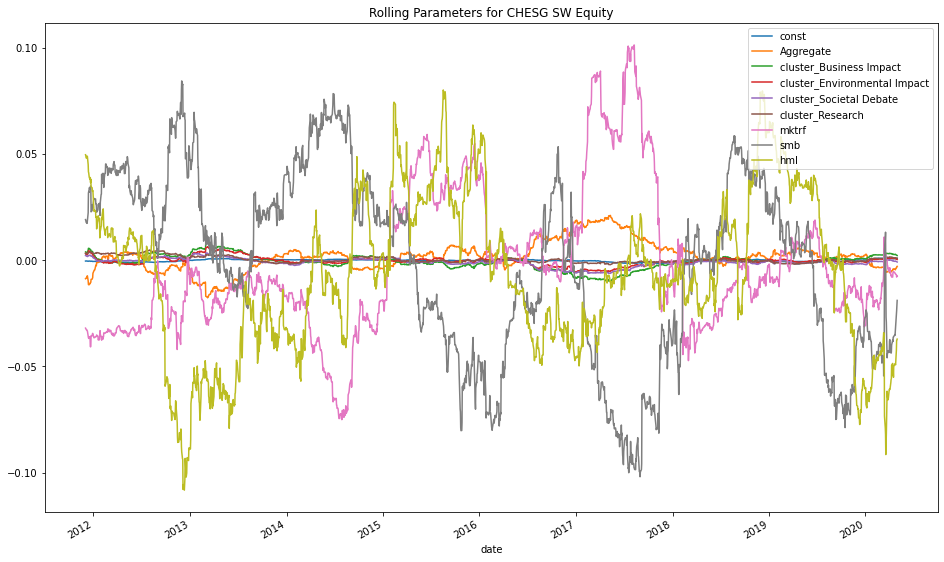

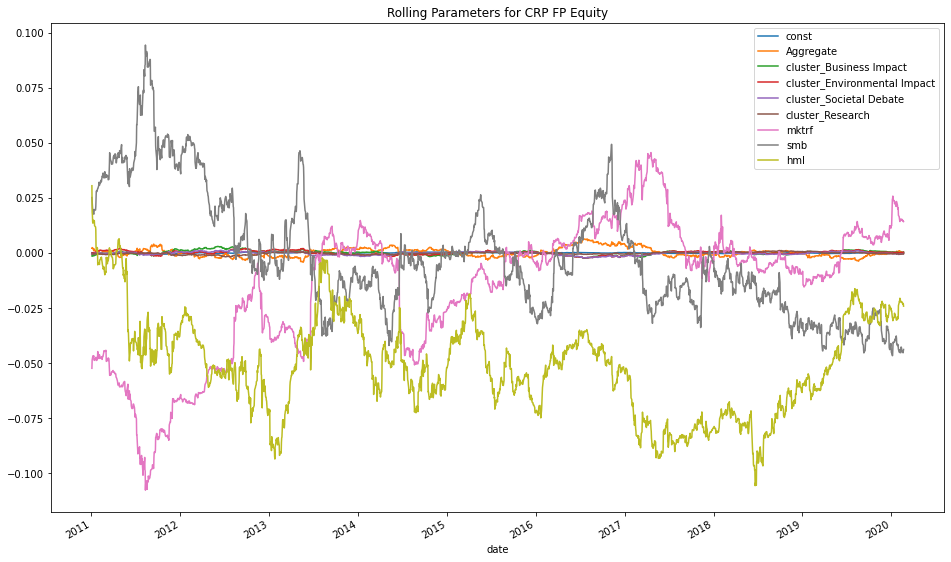

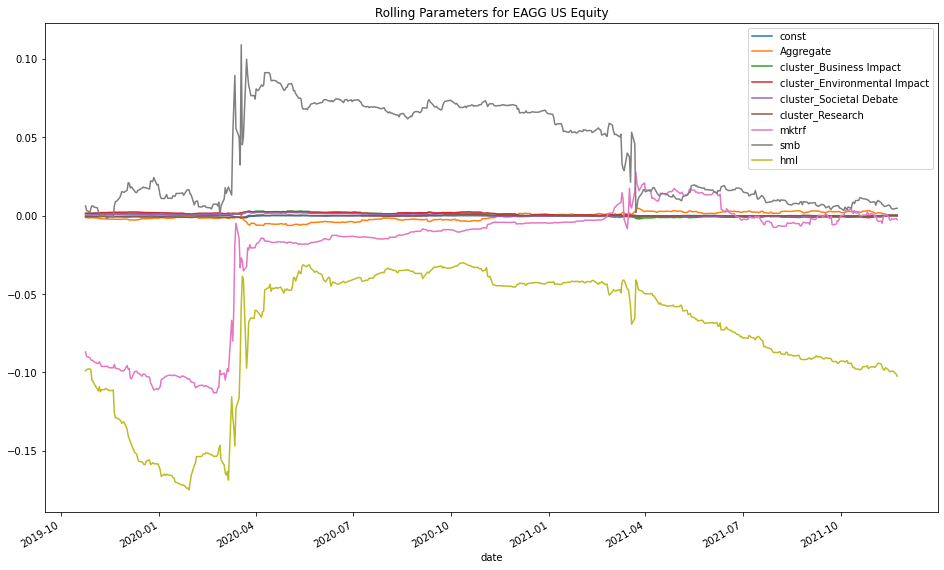

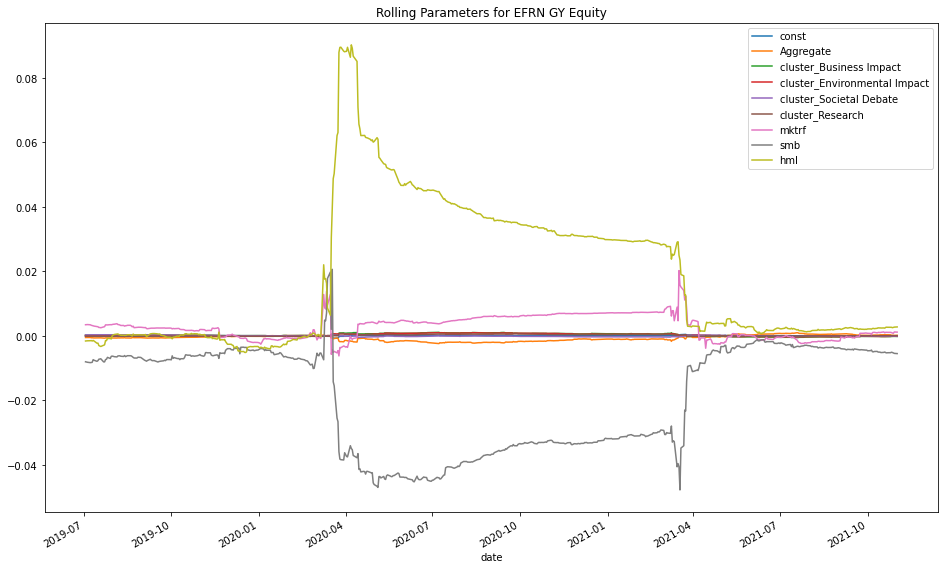

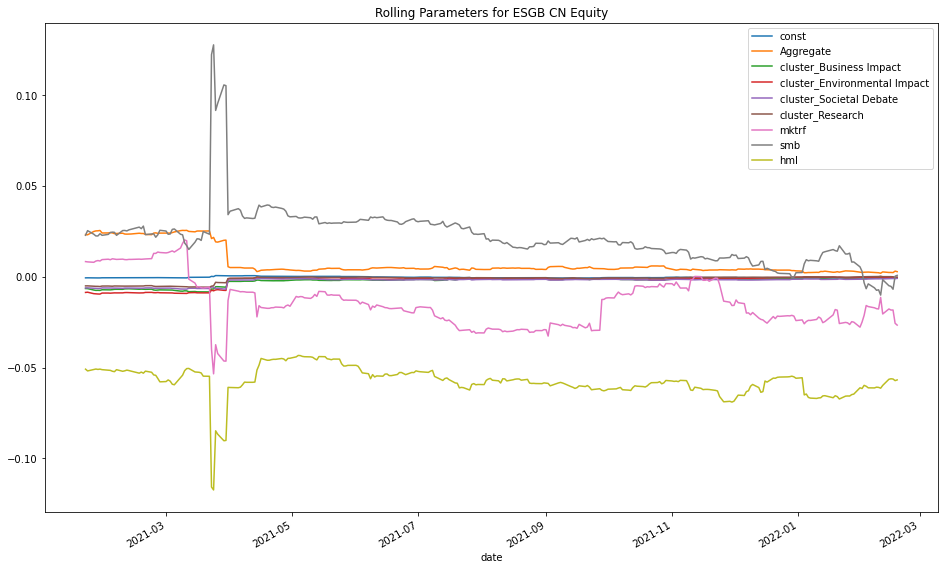

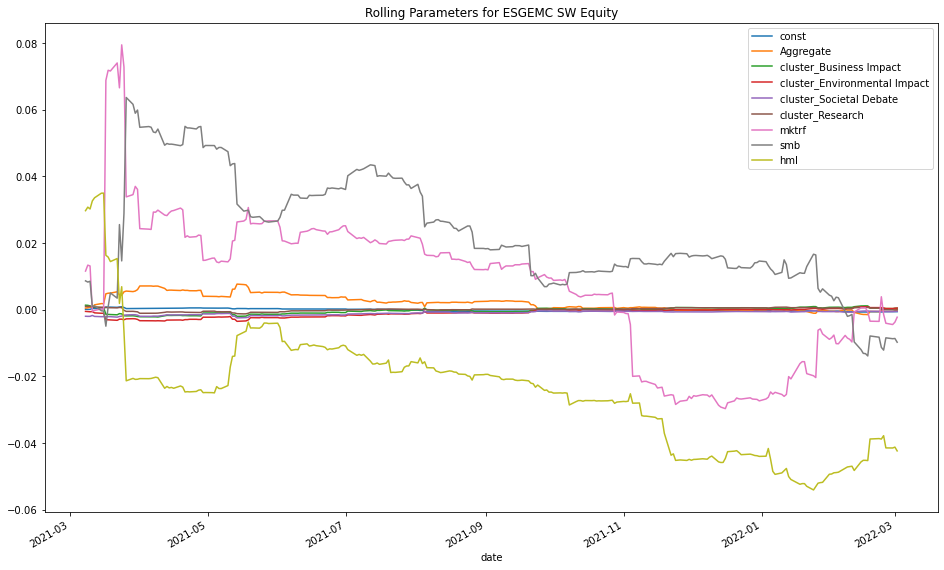

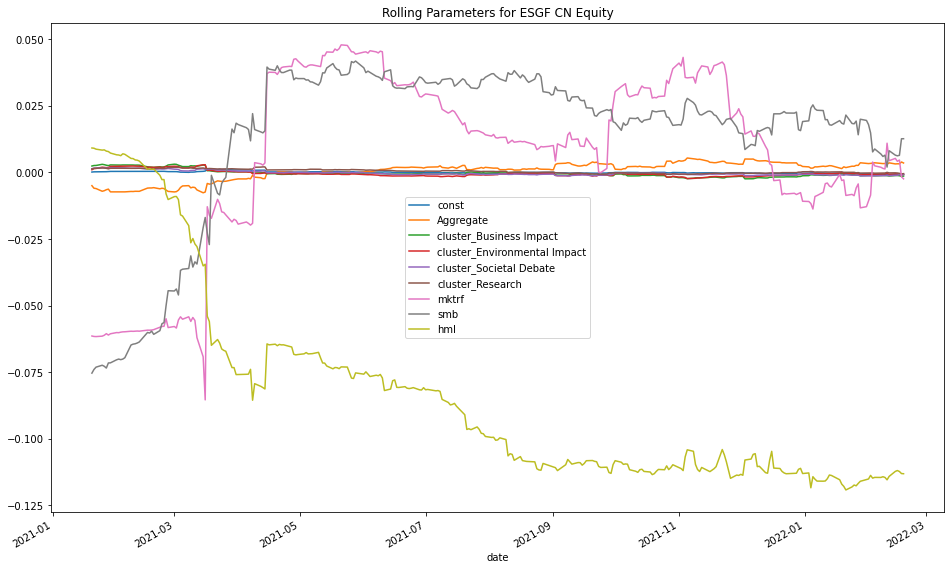

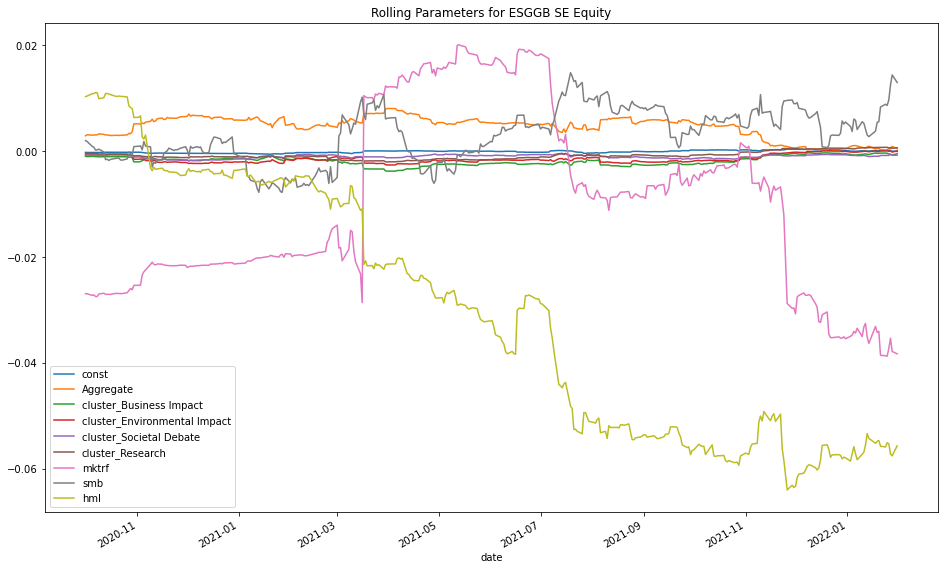

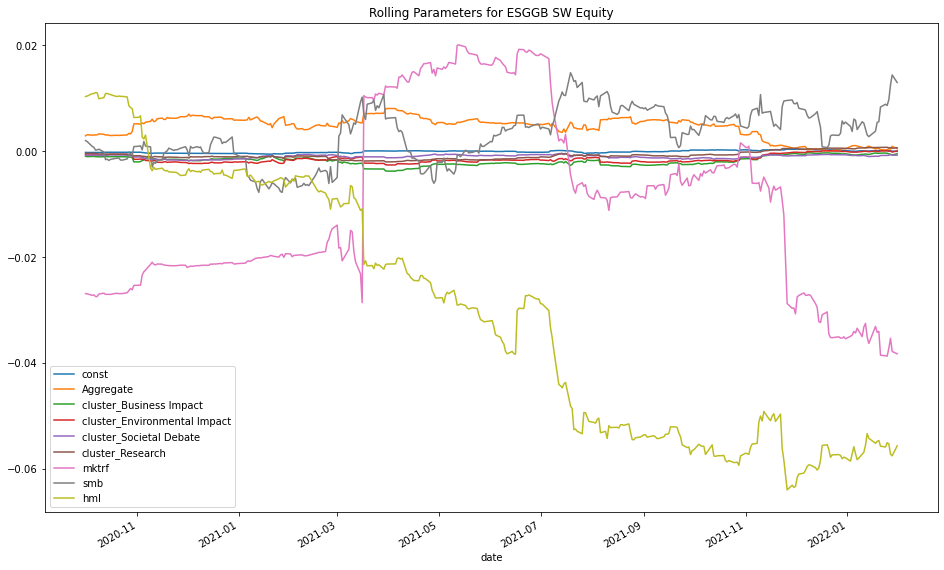

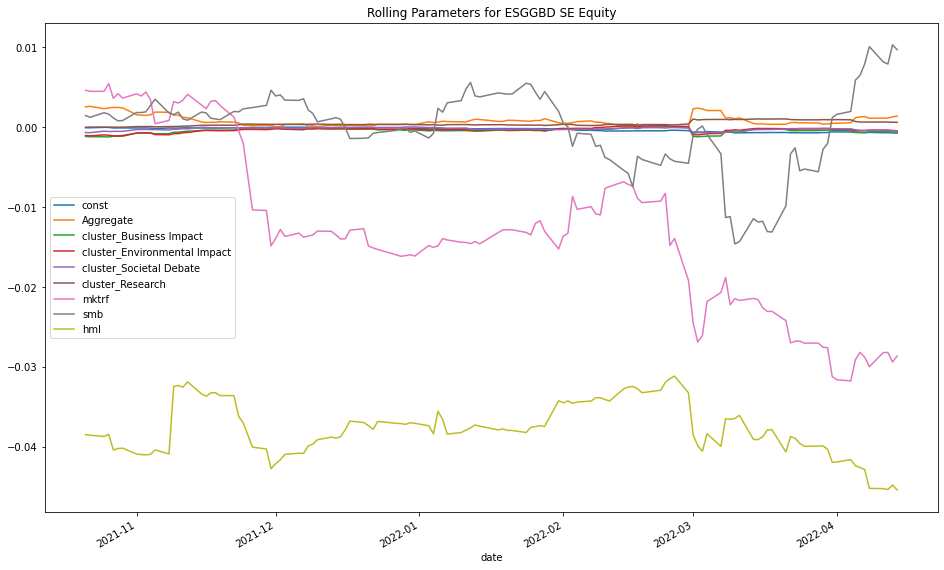

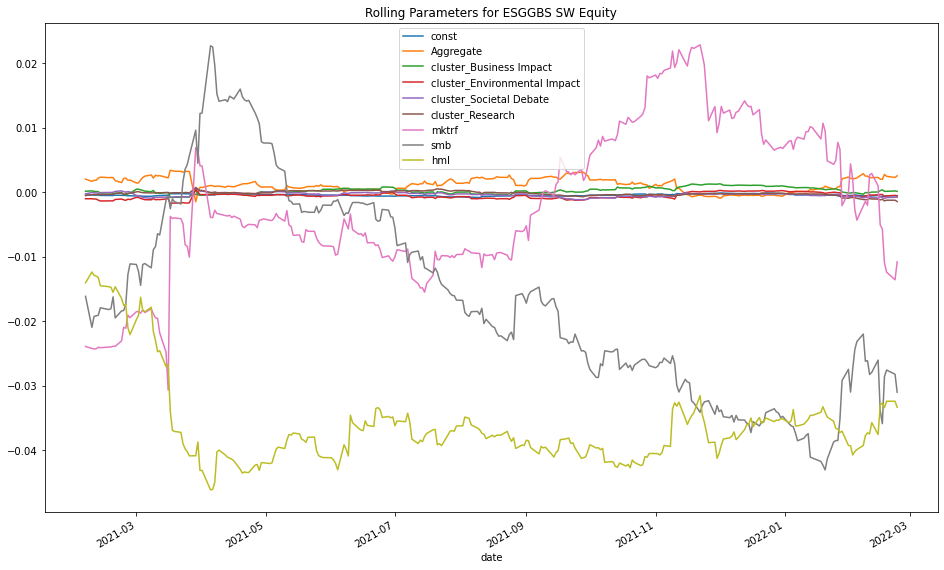

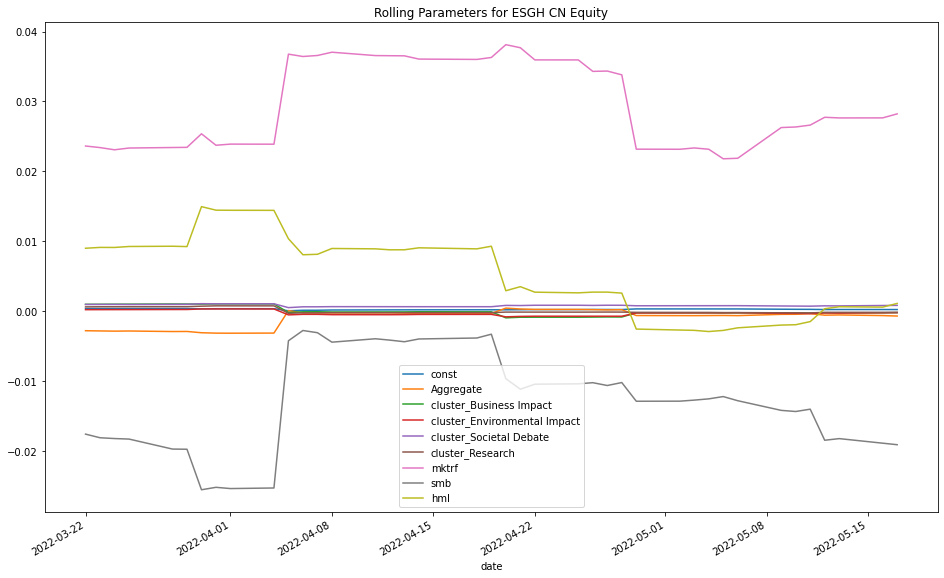

Error in column:  16
Error in column:  17
Error in column:  18
Error in column:  19


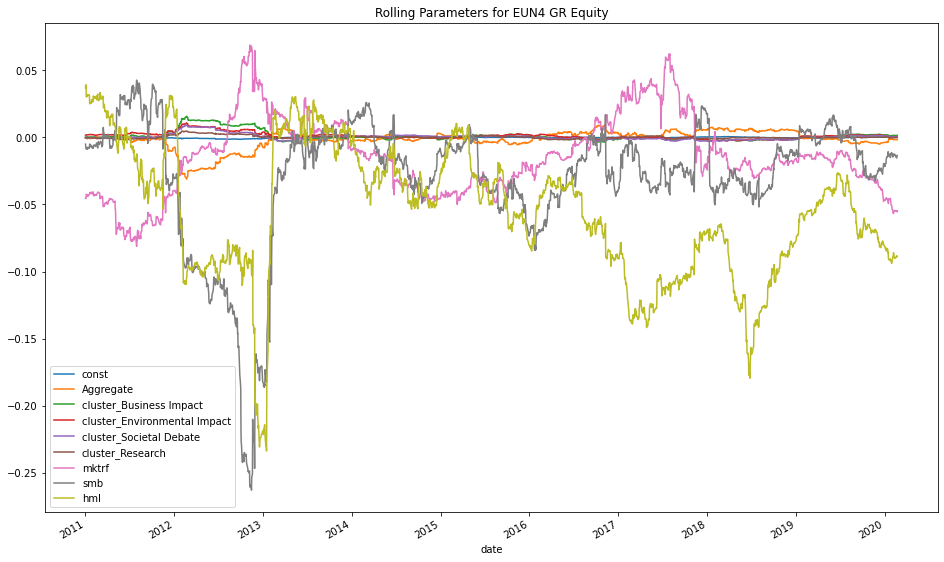

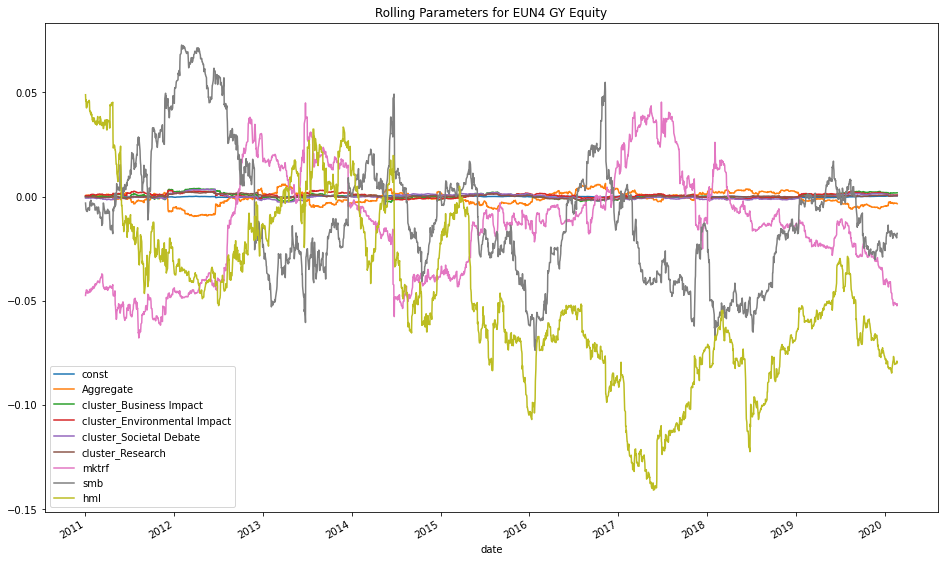

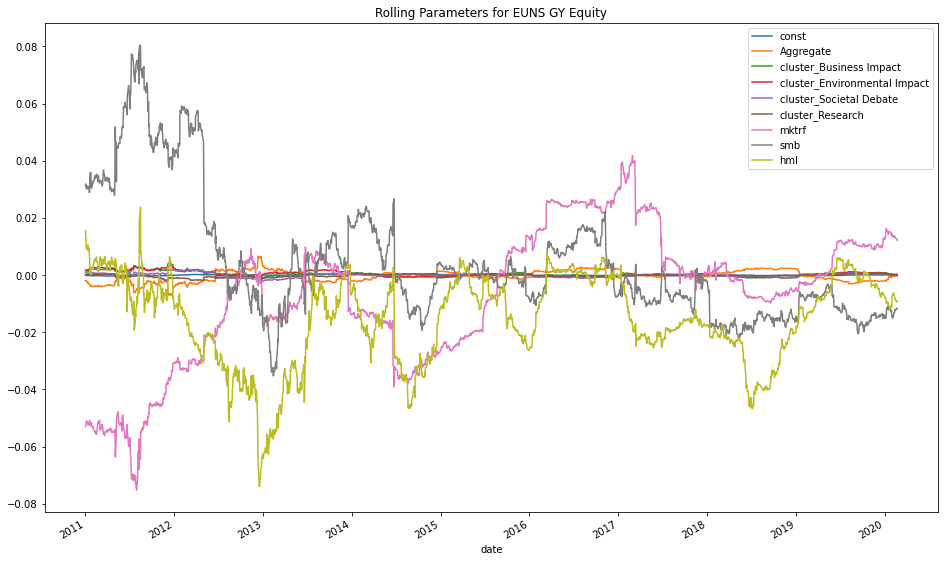

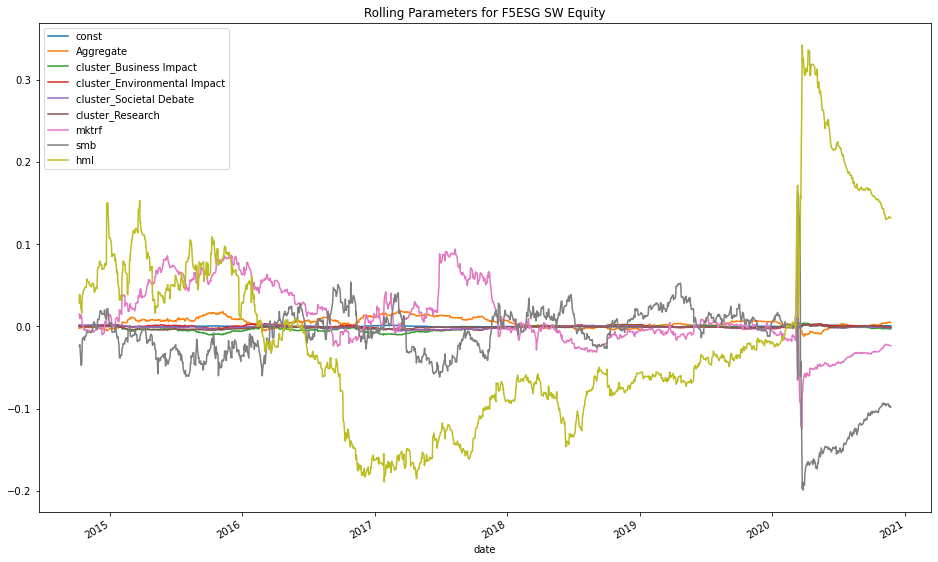

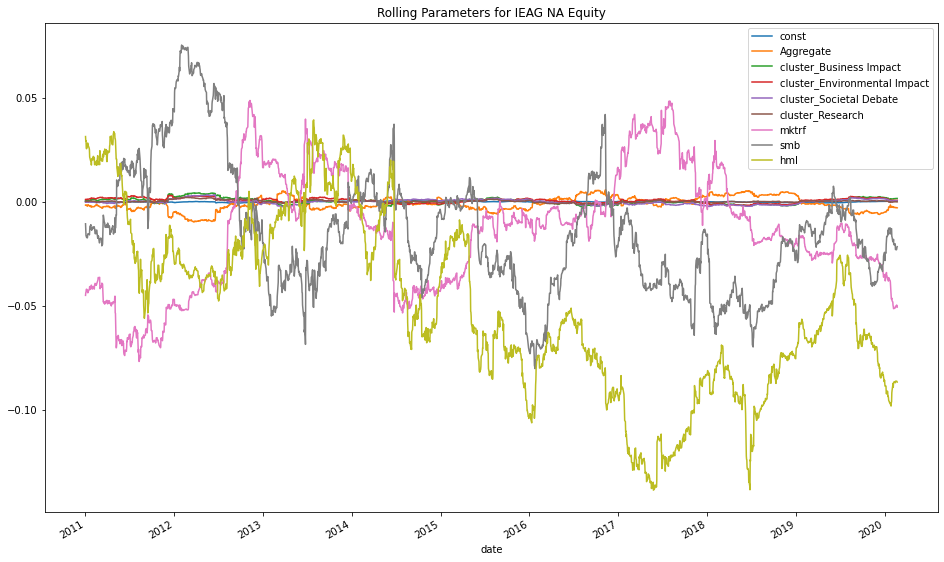

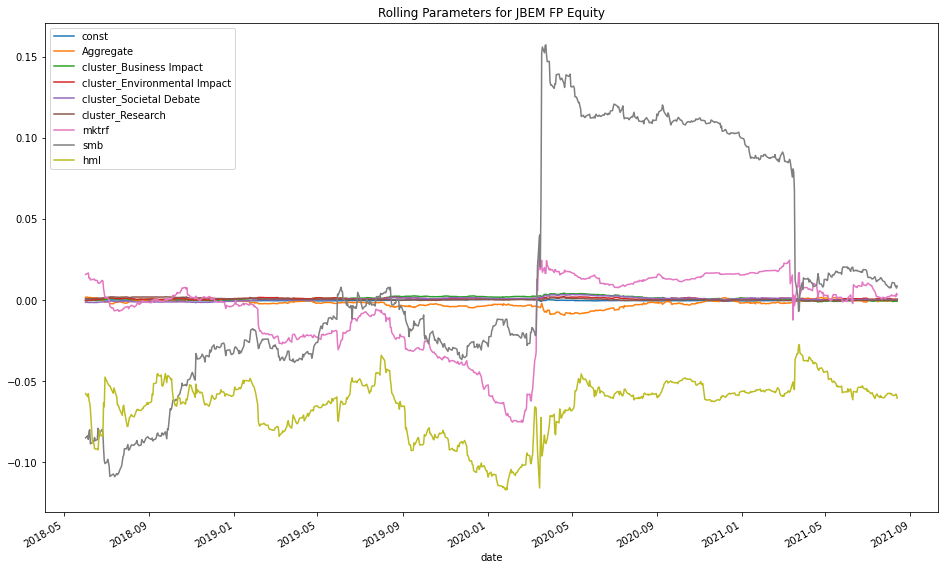

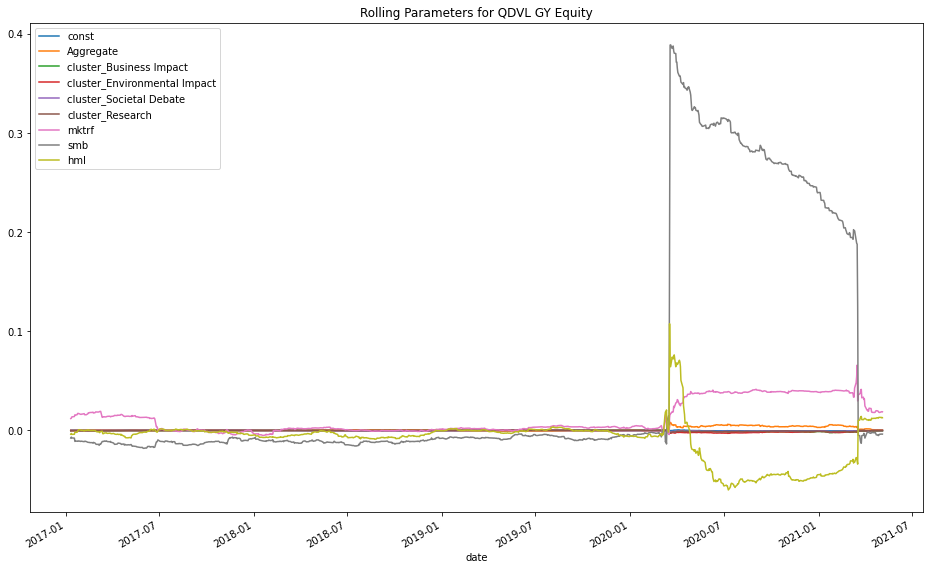

Error in column:  27
Error in column:  28


In [197]:
#Dataframe to store the rolling parameters
rolling_params = pd.DataFrame()
rolling_params.index = esg_ret_filt_mkt.index

for i in range(0, len(esg_ret_filt_mkt.columns)):
    try:    
        esg_temp = esg_ret_filt_mkt.iloc[:,i].dropna()
        
        # Split the esg_temp into train and test sets
        esg_train_temp, esg_test_temp = train_test_split(esg_temp, test_size=0.2, shuffle=False)
        
        # Keep the Aggregate column of news_shocks and all the columns that start with "cluster_"
        news_shocks_temp = news_shocks.loc[:,news_shocks.columns.str.startswith('cluster_') |  news_shocks.columns.str.startswith('Aggregate')].dropna()

        #Create a temporary dataframe with the two series
        temp_df = pd.concat([esg_train_temp, news_shocks_temp], axis=1).dropna()

        # Add fama_factors to the temp_df - only add mktrf, smb, hml
        temp_df = pd.concat([temp_df, fama_factors.loc[:, ['mktrf', 'smb', 'hml']]], axis=1).dropna()

        # Run a rolling regression of esg_temp on news_shocks_temp
        rolling_reg = RollingOLS(temp_df.iloc[:,0], add_constant(temp_df.iloc[:,1:]), window=252)
        rolling_res = rolling_reg.fit()

        # Plot all the parameters
        rolling_res.params.plot(figsize=(16,10))
        plt.title("Rolling Parameters for " + esg_ret_filt_mkt.columns[i])
        plt.show()
        
        # Store the param 1 (slope) in the rolling_params dataframe
        rolling_params[esg_ret_filt_mkt.columns[i]] = rolling_res.params.iloc[:,1]
    except:
        print("Error in column: ", i)

---

#### Regression of non-US (<0.2 Mkt Beta) ESG Indices against News Factors

In [198]:
#Dataframe to store the rolling parameters
rolling_params1 = pd.DataFrame(index=esg_ret_filt_mkt.index)

# Add len(esg_ret_filt_mkt.columns) * 5 columns to the rolling_params1 dataframe
for i in range(0, len(esg_ret_filt_mkt.columns) * 5):
    rolling_params1[i] = np.nan

#Create 5 subcolumns for each column in the rolling_params1 dataframe
rolling_params1.columns = pd.MultiIndex.from_product([esg_ret_filt_mkt.columns, ['const', 'cluster_Business Impact', 'cluster_Environmental Impact', 'cluster_Societal Debate', 'cluster_Research']])

rolling_params1

Security   00878 TT Equity                          \
                     const cluster_Business Impact   
date                                                 
2010-01-04             NaN                     NaN   
2010-01-05             NaN                     NaN   
2010-01-06             NaN                     NaN   
2010-01-07             NaN                     NaN   
2010-01-08             NaN                     NaN   
...                    ...                     ...   
2022-08-24             NaN                     NaN   
2022-08-25             NaN                     NaN   
2022-08-26             NaN                     NaN   
2022-08-29             NaN                     NaN   
2022-08-30             NaN                     NaN   

Security                                                         \
           cluster_Environmental Impact cluster_Societal Debate   
date                                                              
2010-01-04                          NaN                     NaN   
2010-01-05                          NaN                     NaN   
2010-01-06                          NaN                     NaN   
2010-01-07                          NaN                     NaN   
2010-01-08                          NaN                     NaN   
...                                 ...                     ...   
2022-08-24                          NaN                     NaN   
2022-08-25                          NaN                     NaN   
2022-08-26                          NaN                     NaN   
2022-08-29                          NaN                     NaN   
2022-08-30                          NaN                     NaN   

Security                    AEGE GY Equity                          \
           cluster_Research          const cluster_Business Impact   
date                                                                 
2010-01-04              NaN            NaN                     NaN   
2010-01-05              NaN            NaN                     NaN   
2010-01-06              NaN            NaN                     NaN   
2010-01-07              NaN            NaN                     NaN   
2010-01-08              NaN            NaN                     NaN   
...                     ...            ...                     ...   
2022-08-24              NaN            NaN                     NaN   
2022-08-25              NaN            NaN                     NaN   
2022-08-26              NaN            NaN                     NaN   
2022-08-29              NaN            NaN                     NaN   
2022-08-30              NaN            NaN                     NaN   

Security                                                         \
           cluster_Environmental Impact cluster_Societal Debate   
date                                                              
2010-01-04                          NaN                     NaN   
2010-01-05                          NaN                     NaN   
2010-01-06                          NaN                     NaN   
2010-01-07                          NaN                     NaN   
2010-01-08                          NaN                     NaN   
...                                 ...                     ...   
2022-08-24                          NaN                     NaN   
2022-08-25                          NaN                     NaN   
2022-08-26                          NaN                     NaN   
2022-08-29                          NaN                     NaN   
2022-08-30                          NaN                     NaN   

Security                     ... TAEH IM Equity                          \
           cluster_Research  ...          const cluster_Business Impact   
date                         ...                                          
2010-01-04              NaN  ...            NaN                     NaN   
2010-01-05              NaN  ...            NaN                     NaN   
2010-01-0

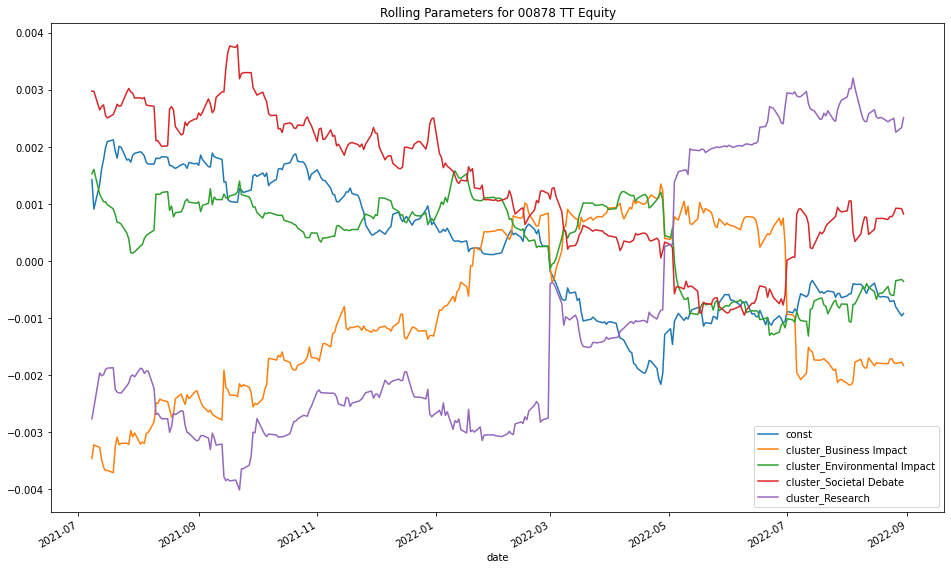

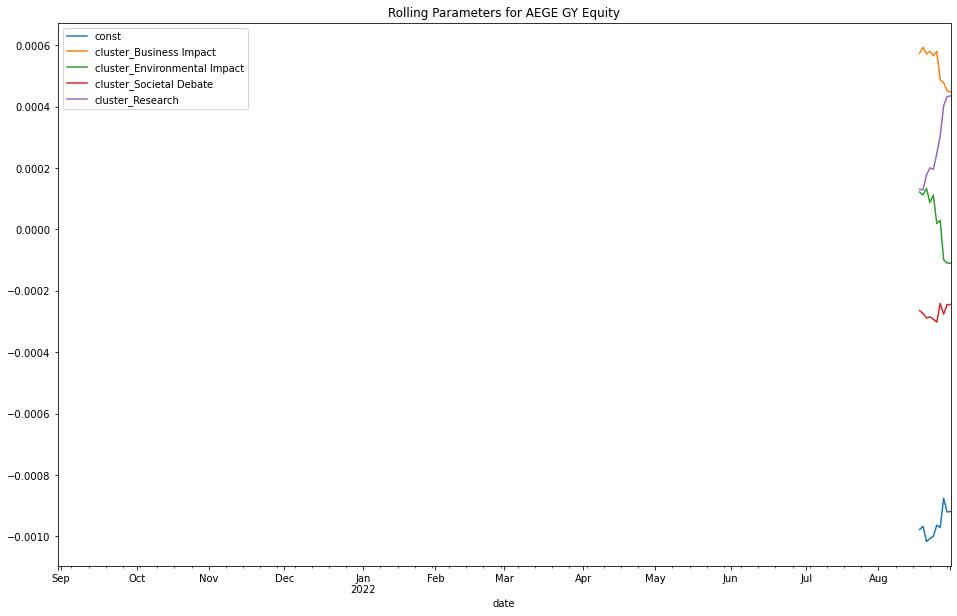

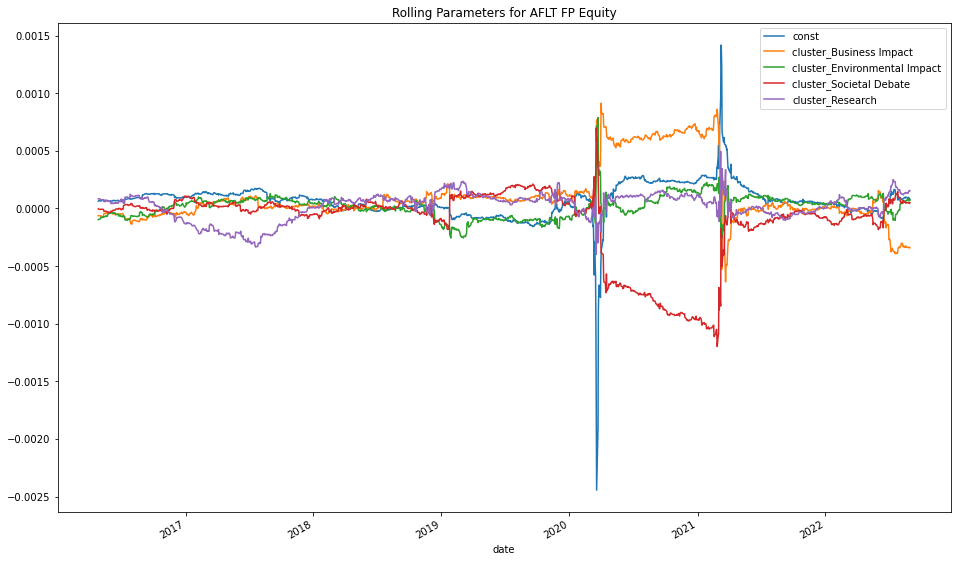

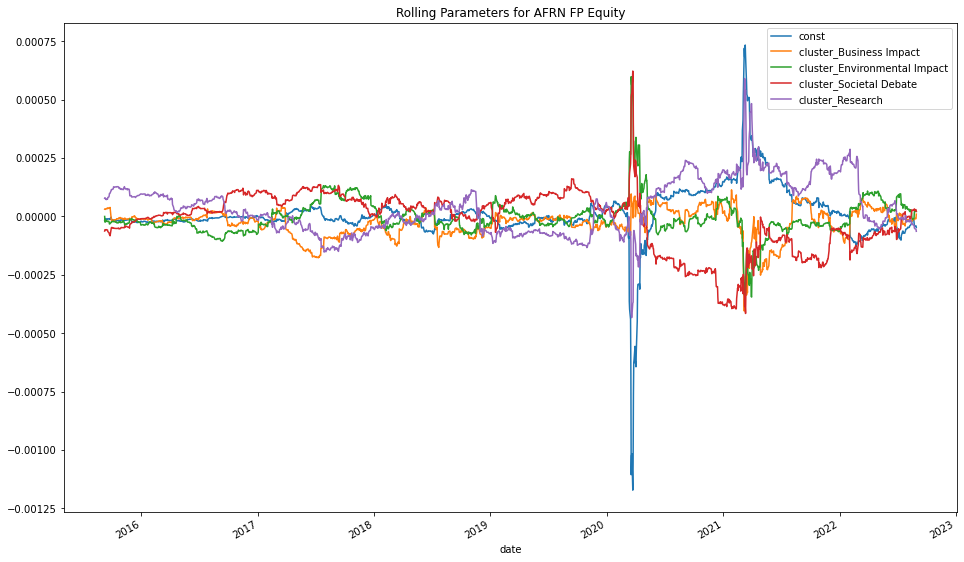

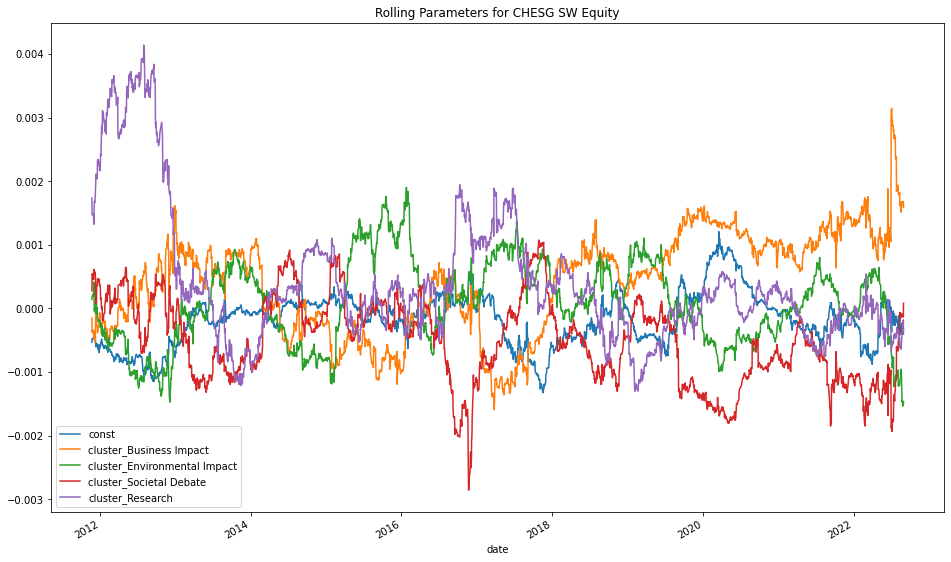

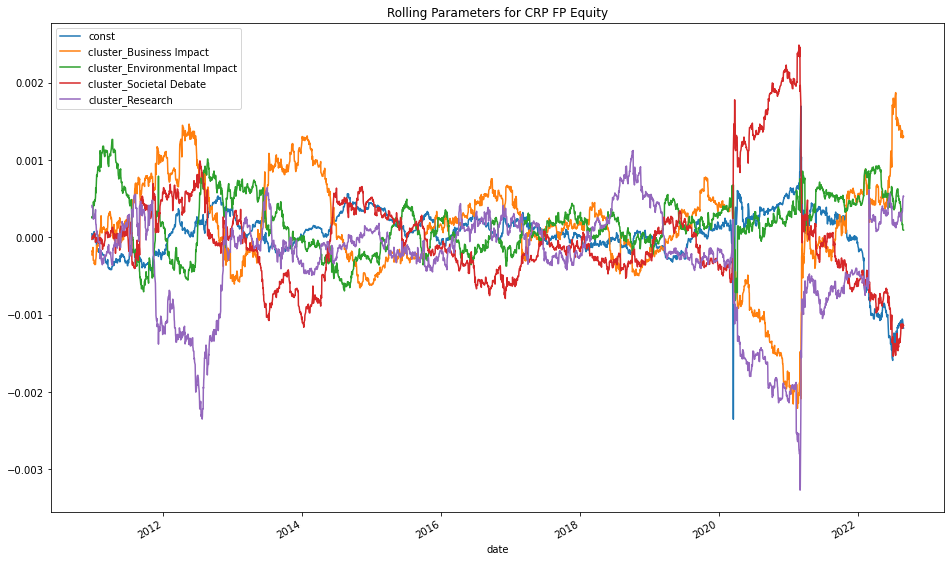

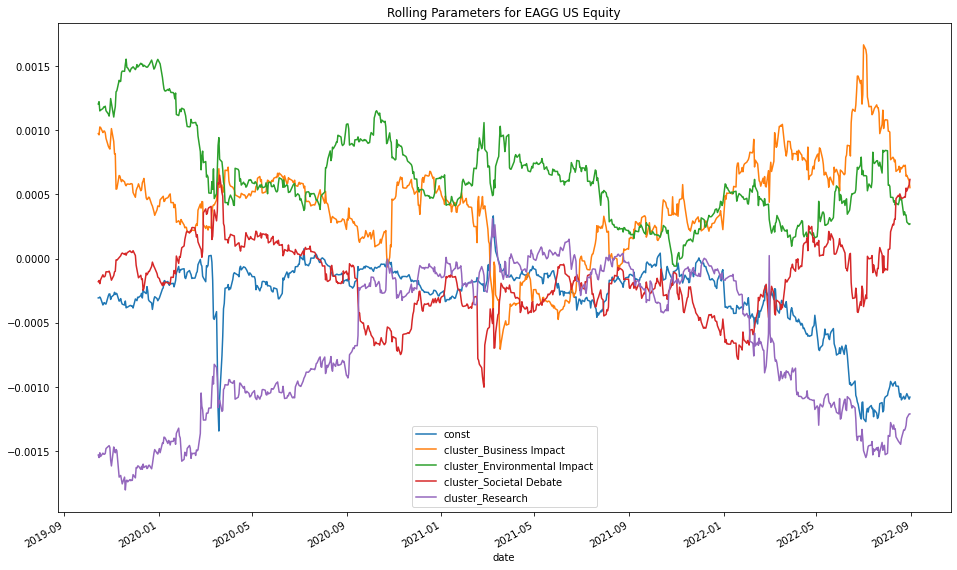

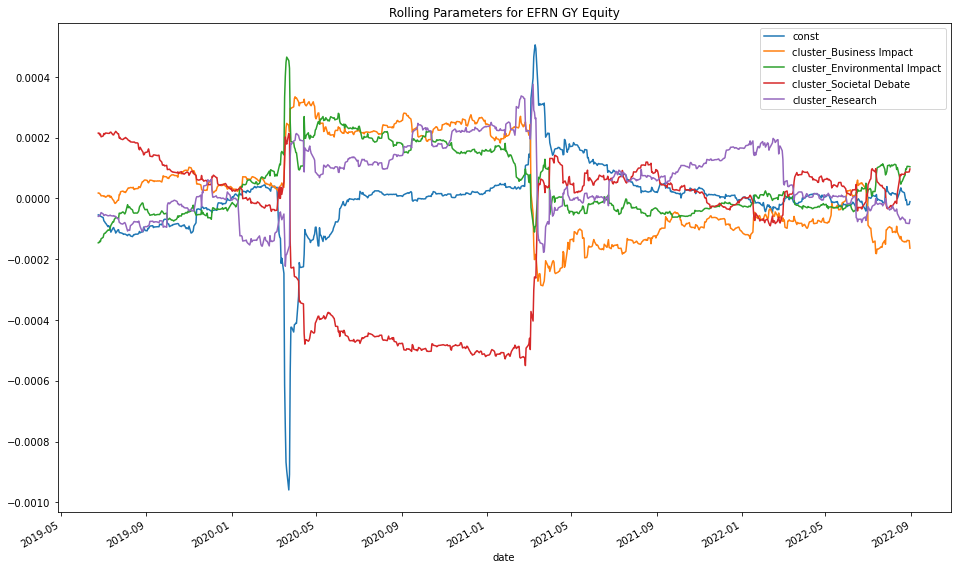

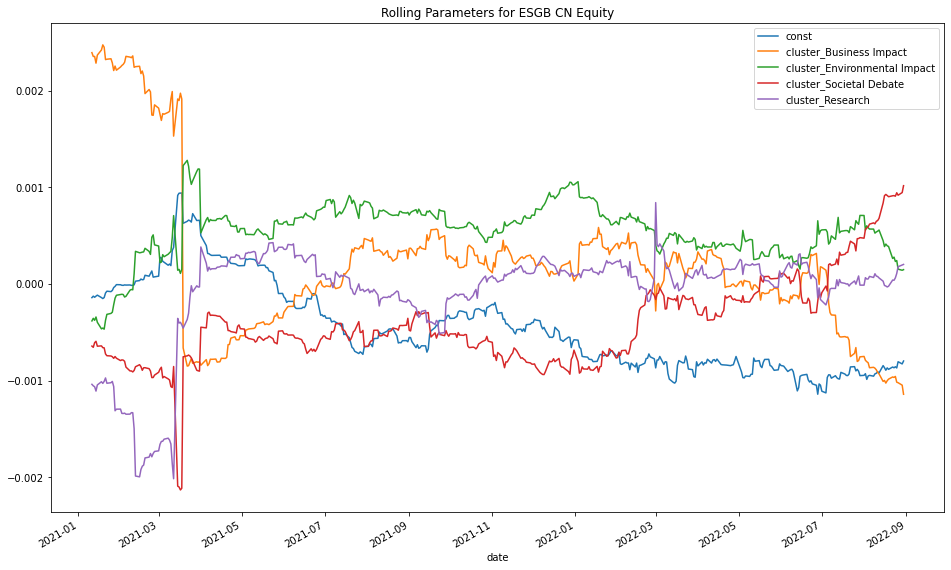

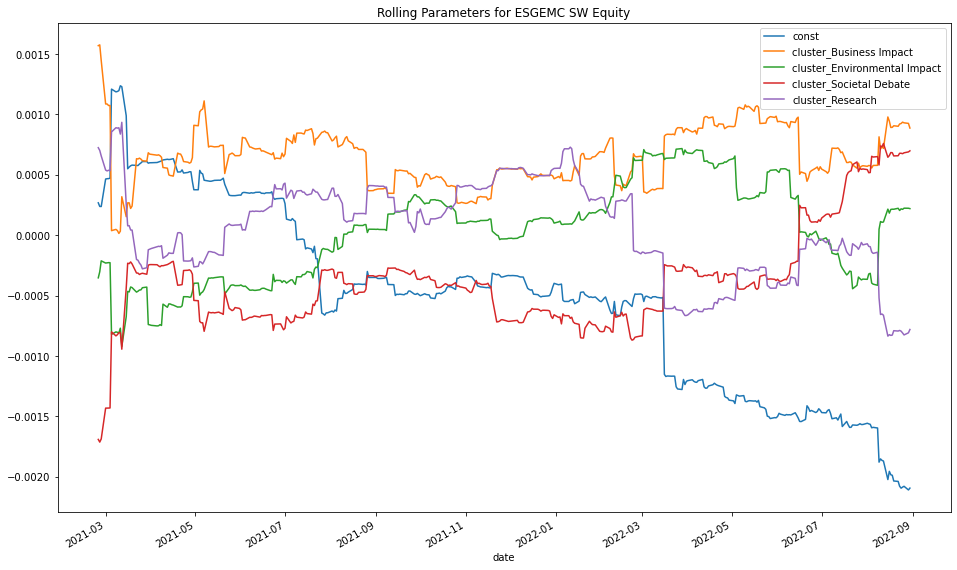

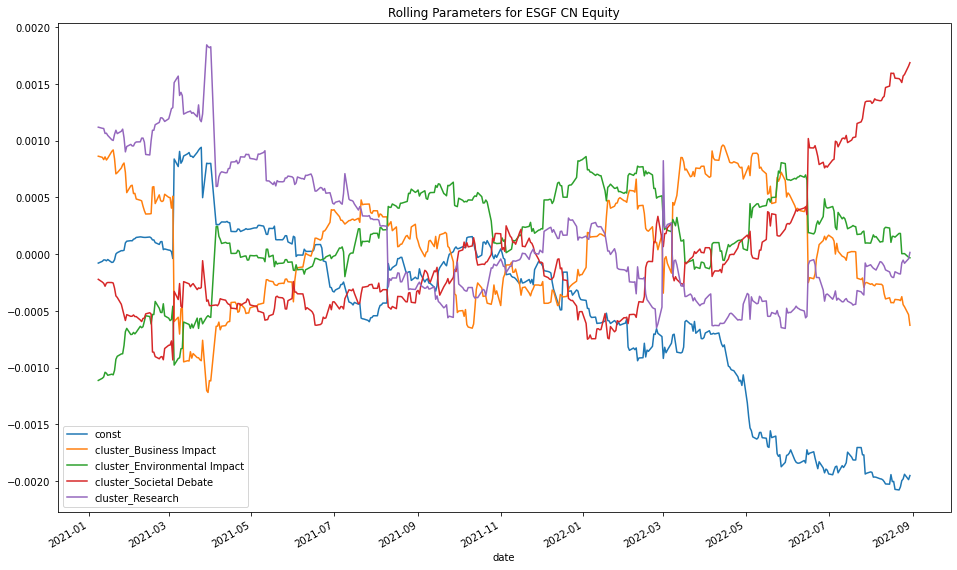

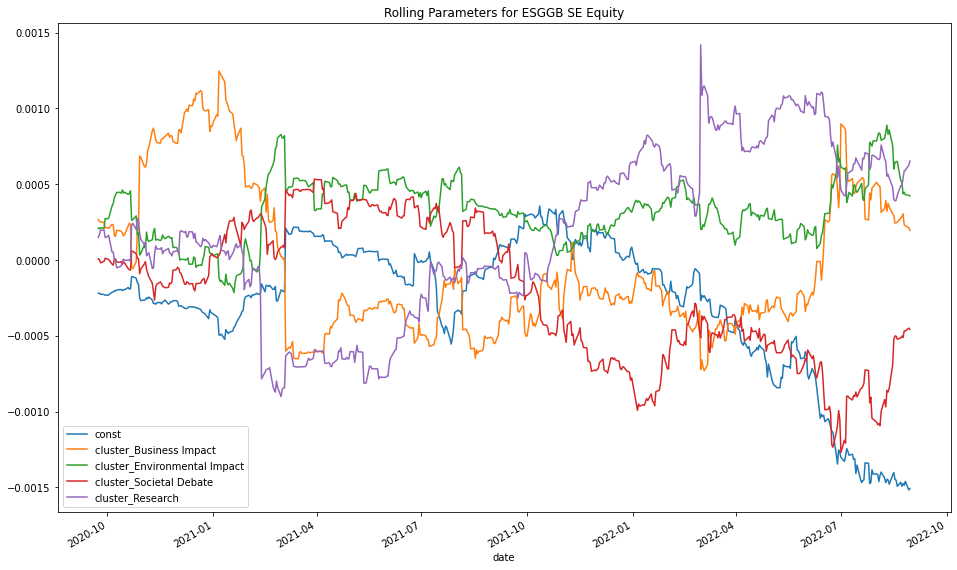

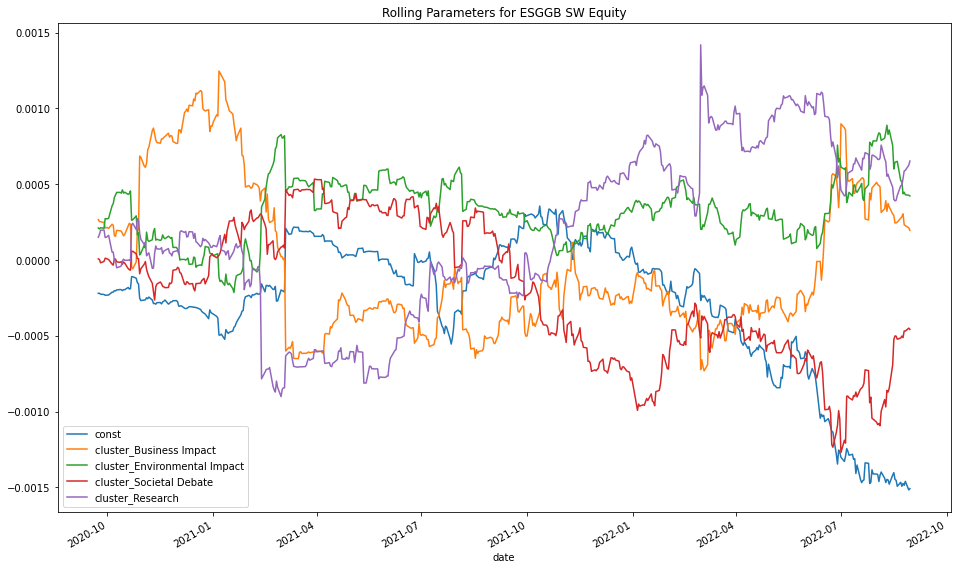

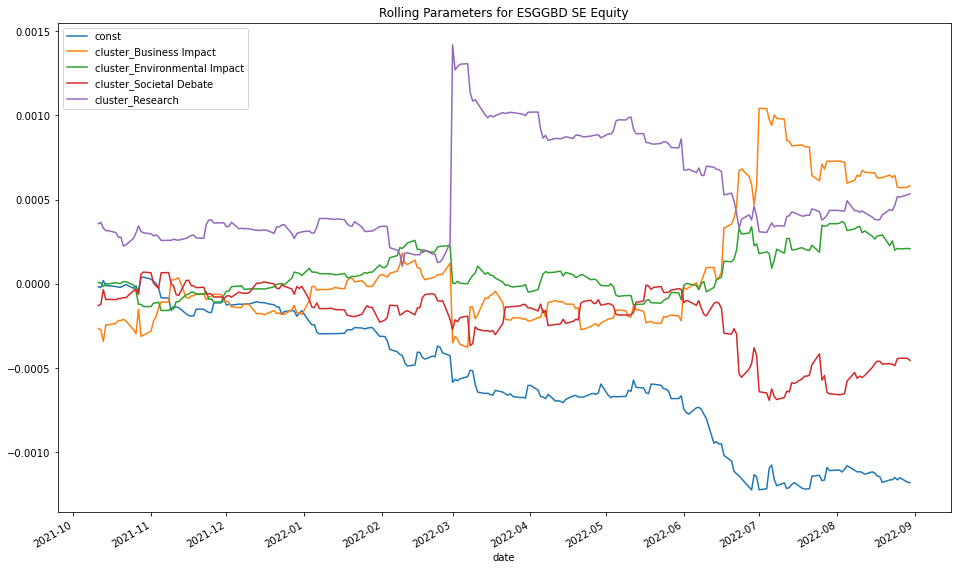

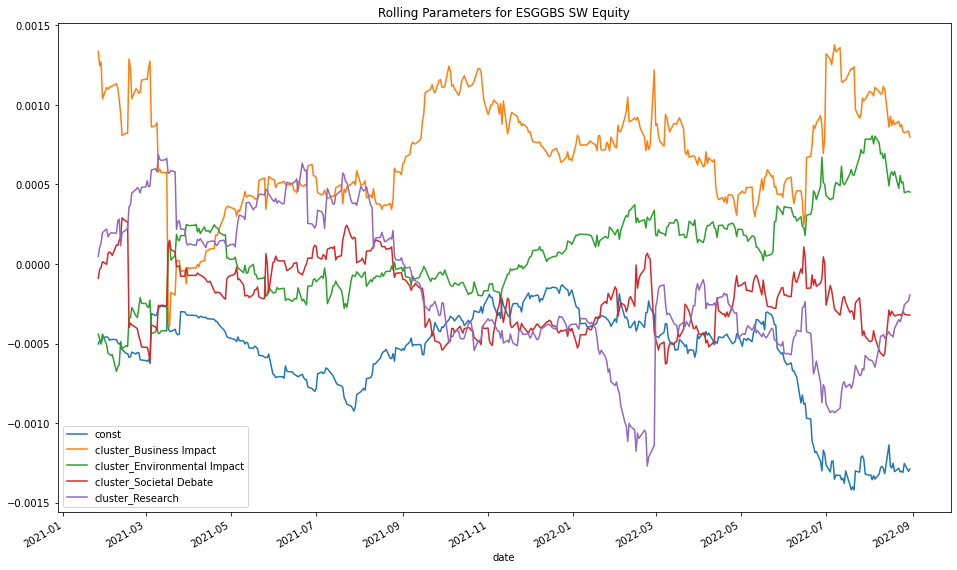

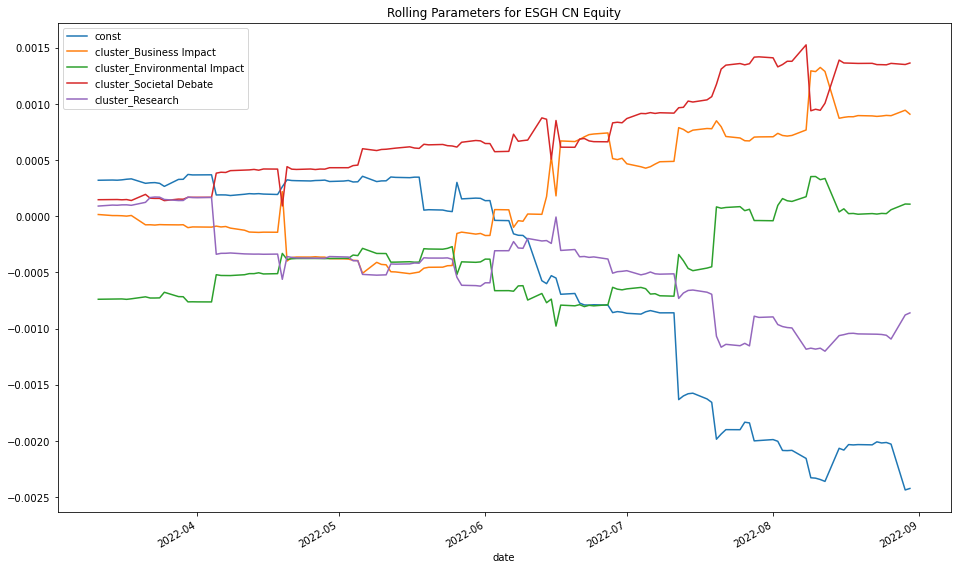

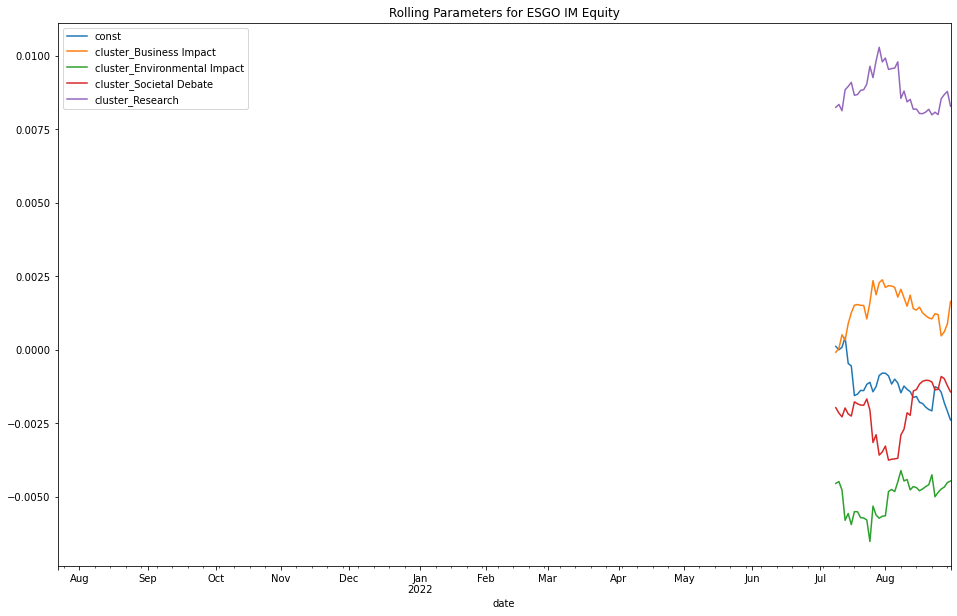

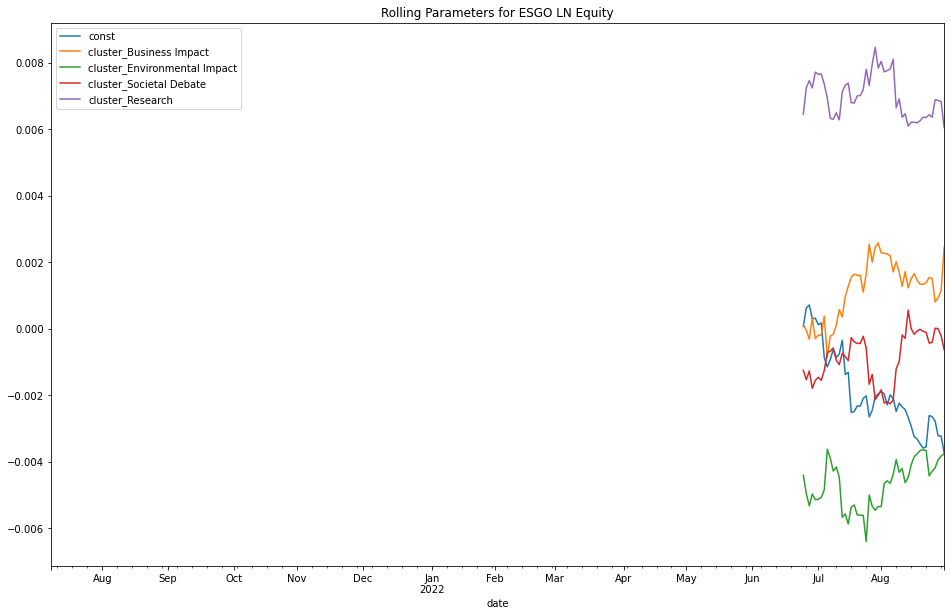

The column ESGSG SP Equity does not have enough data.
The column ESGUS SP Equity does not have enough data.


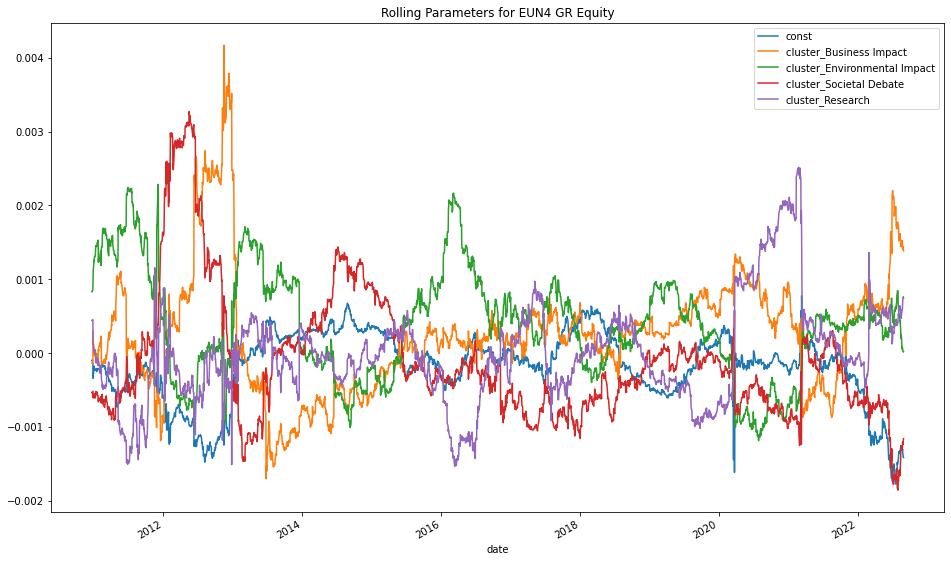

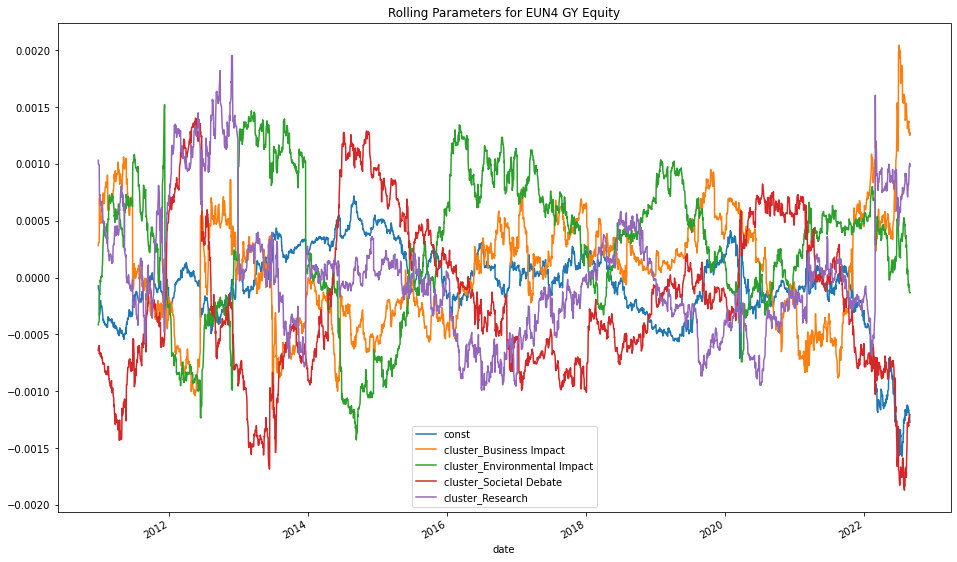

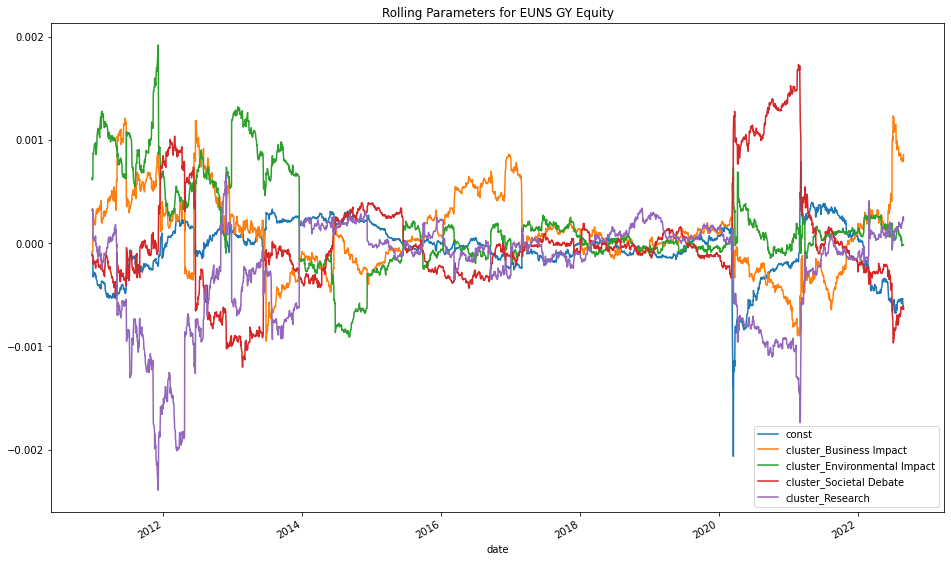

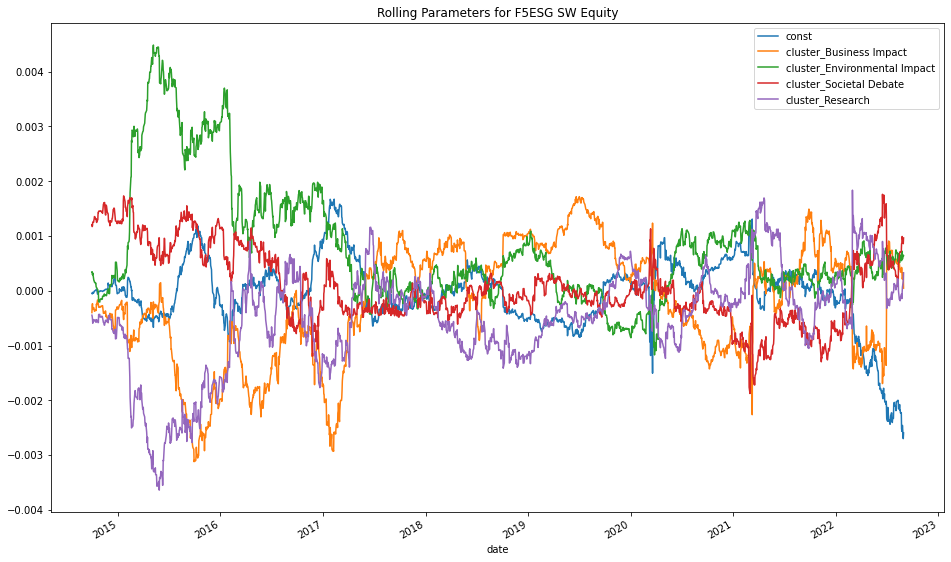

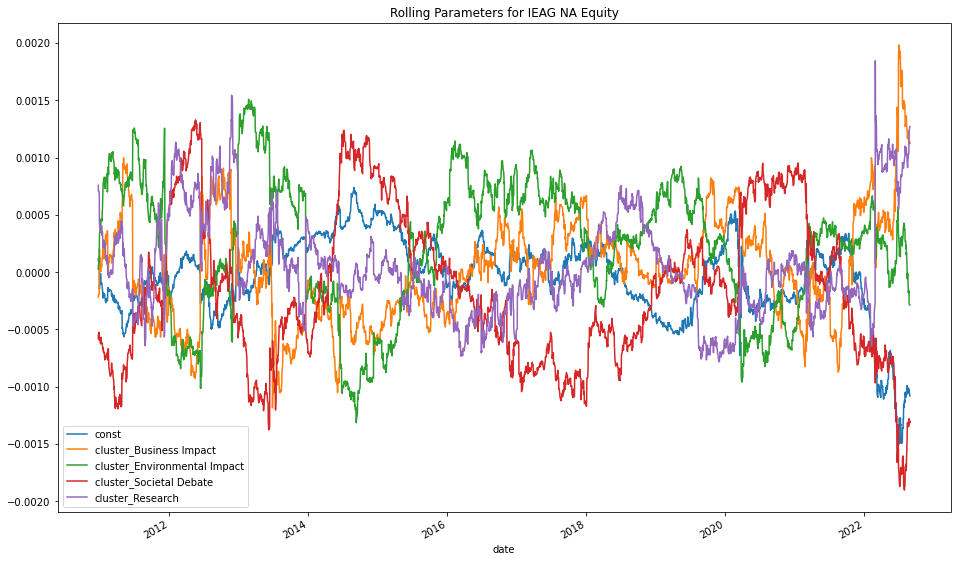

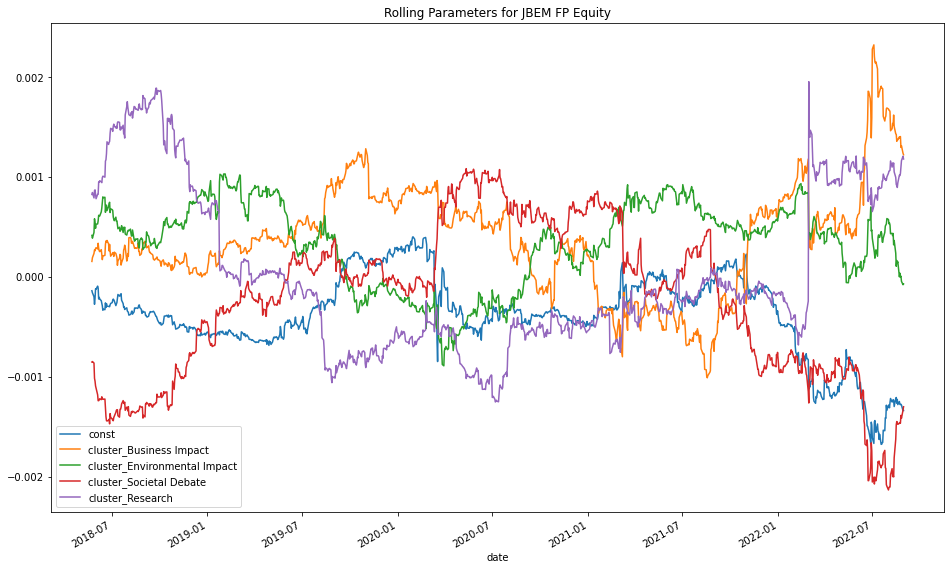

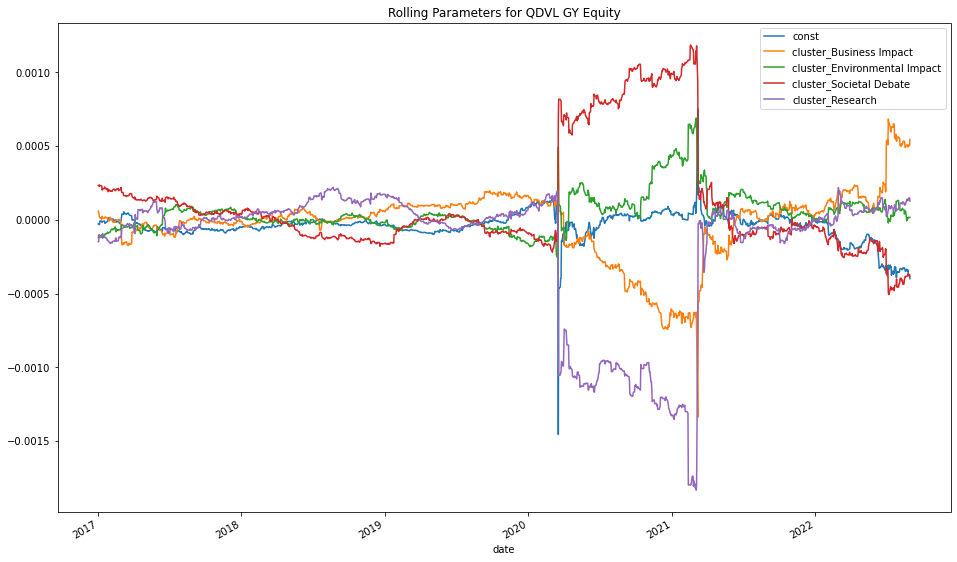

The column TAEH IM Equity does not have enough data.


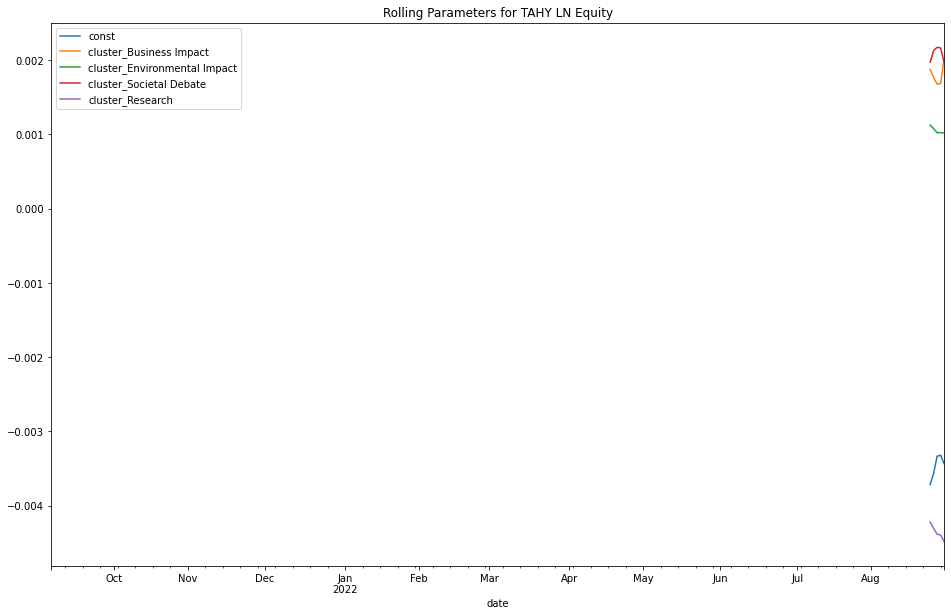

In [199]:
#Dataframe to store the rolling parameters
rolling_params1 = pd.DataFrame(index=esg_ret_filt_mkt.index)

# Add len(esg_ret_filt_mkt.columns) * 5 columns to the rolling_params1 dataframe
for i in range(0, len(esg_ret_filt_mkt.columns) * 5):
    rolling_params1[i] = np.nan

#Create 5 subcolumns for each column in the rolling_params1 dataframe
rolling_params1.columns = pd.MultiIndex.from_product([esg_ret_filt_mkt.columns, ['const', 'cluster_Business Impact', 'cluster_Environmental Impact', 'cluster_Societal Debate', 'cluster_Research']])

for i in range(0, len(esg_ret_filt_mkt.columns)):
    try:    
        esg_temp = esg_ret_filt_mkt.iloc[:,i].dropna()
        
        # Split the esg_temp into train and test sets
        # esg_train_temp, esg_test_temp = train_test_split(esg_temp, test_size=0.2, shuffle=False)
        
        # Keep the Aggregate column of news_shocks and all the columns that start with "cluster_"
        news_shocks_temp = news_shocks.loc[:,news_shocks.columns.str.startswith('cluster_')].dropna()
        
        # # Take the returns of the clusters
        # news_shocks_temp = news_shocks_temp.pct_change()

        # # Replace -inf and inf with NaN
        # news_shocks_temp = news_shocks_temp.replace([np.inf, -np.inf], np.nan)
        
        # # Drop nan values
        # news_shocks_temp = news_shocks_temp.dropna()

        #Create a temporary dataframe with the two series
        temp_df = pd.concat([esg_temp, news_shocks_temp], axis=1).dropna()

        # Add fama_factors to the temp_df - only add mktrf, smb, hml
        #temp_df = pd.concat([temp_df, fama_factors.loc[:, ['mktrf', 'smb', 'hml']]], axis=1).dropna()

        # Run a rolling regression of esg_temp on news_shocks_temp
        rolling_reg = RollingOLS(temp_df.iloc[:,0], add_constant(temp_df.iloc[:,1:]), window=252)
        rolling_res = rolling_reg.fit()

        # Plot all the parameters
        rolling_res.params.plot(figsize=(16,10))
        plt.title("Rolling Parameters for " + esg_ret_filt_mkt.columns[i])
        plt.show()
        
        # Store all the parameters using multi-indexing on the rolling_params1 dataframe
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'const')] = rolling_res.params.iloc[:,0]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_Business Impact')] = rolling_res.params.iloc[:,1]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_Environmental Impact')] = rolling_res.params.iloc[:,2]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_Societal Debate')] = rolling_res.params.iloc[:,3]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_Research')] = rolling_res.params.iloc[:,4]
        
    except:
        print("The column " + esg_ret_filt_mkt.columns[i] + " does not have enough data.")

In [200]:
rolling_params1

Security   00878 TT Equity                          \
                     const cluster_Business Impact   
date                                                 
2010-01-04             NaN                     NaN   
2010-01-05             NaN                     NaN   
2010-01-06             NaN                     NaN   
2010-01-07             NaN                     NaN   
2010-01-08             NaN                     NaN   
...                    ...                     ...   
2022-08-24          -0.001                  -0.002   
2022-08-25          -0.001                  -0.002   
2022-08-26          -0.001                  -0.002   
2022-08-29          -0.001                  -0.002   
2022-08-30          -0.001                  -0.002   

Security                                                         \
           cluster_Environmental Impact cluster_Societal Debate   
date                                                              
2010-01-04                          NaN                     NaN   
2010-01-05                          NaN                     NaN   
2010-01-06                          NaN                     NaN   
2010-01-07                          NaN                     NaN   
2010-01-08                          NaN                     NaN   
...                                 ...                     ...   
2022-08-24                       -0.001                   0.001   
2022-08-25                       -0.001                   0.001   
2022-08-26                       -0.000                   0.001   
2022-08-29                       -0.000                   0.001   
2022-08-30                       -0.000                   0.001   

Security                    AEGE GY Equity                          \
           cluster_Research          const cluster_Business Impact   
date                                                                 
2010-01-04              NaN            NaN                     NaN   
2010-01-05              NaN            NaN                     NaN   
2010-01-06              NaN            NaN                     NaN   
2010-01-07              NaN            NaN                     NaN   
2010-01-08              NaN            NaN                     NaN   
...                     ...            ...                     ...   
2022-08-24            0.002         -0.001                   0.001   
2022-08-25            0.003         -0.001                   0.000   
2022-08-26            0.002         -0.001                   0.000   
2022-08-29            0.002         -0.001                   0.000   
2022-08-30            0.003         -0.001                   0.000   

Security                                                         \
           cluster_Environmental Impact cluster_Societal Debate   
date                                                              
2010-01-04                          NaN                     NaN   
2010-01-05                          NaN                     NaN   
2010-01-06                          NaN                     NaN   
2010-01-07                          NaN                     NaN   
2010-01-08                          NaN                     NaN   
...                                 ...                     ...   
2022-08-24                        0.000                  -0.000   
2022-08-25                        0.000                  -0.000   
2022-08-26                       -0.000                  -0.000   
2022-08-29                       -0.000                  -0.000   
2022-08-30                       -0.000                  -0.000   

Security                     ... TAEH IM Equity                          \
           cluster_Research  ...          const cluster_Business Impact   
date                         ...                                          
2010-01-04              NaN  ...            NaN                     NaN   
2010-01-05              NaN  ...            NaN                     NaN   
2010-01-0

In [201]:
#Generate trading signals on the rolling_params1_1 dataframe to trade the first stock in the esg_ret_filt_mkt dataframe and backtest
def generate_trading_signals(rolling_params1_1):
    # Drop all nan values
    rolling_params1_1_temp = rolling_params1_1.dropna()
    
    # Split the rolling_params1_1_temp into train and test sets
    rolling_params1_1_train_temp, rolling_params1_1_test_temp = train_test_split(rolling_params1_1_temp, test_size=0.2, shuffle=False)
    
    # Create a dataframe to store the trading signals
    trading_signals = pd.DataFrame(index=rolling_params1_1_temp.index)
    trading_signals['signal'] = 0.0
    
    # Find the cluster with the highest average beta by taking the absolute value of the rolling_params1_1_temp dataframe and finding the column with the highest average
    cluster = abs(rolling_params1_1_train_temp).mean().idxmax()
    #abs(rolling_params1_1.iloc[:,1:5].mean(axis=0)).idxmax()
    
    # Generate the trading signals based on the cluster with the highest average beta
    # Check if cluster mean is positive or negative
    if rolling_params1_1_temp[cluster].mean() > 0:
        trading_signals['signal'] = np.where(rolling_params1_1_temp[cluster] > 0, 1.0, -1.0)
    else:
        trading_signals['signal'] = np.where(rolling_params1_1_temp[cluster] > 0, -1.0, 1.0)
    # trading_signals['positions'] = trading_signals['signal'].diff()
    
    # Shift the trading signals by 1 day
    trading_signals['signal'] = trading_signals['signal'].shift(1)
    
    #Print the name of the cluster with the highest average beta
    print("The cluster with the highest average beta is: ", cluster)
    
    return trading_signals


# Backtest the trading signals and calculate potential cumulative returns
def backtest(trading_signals, esg_ret_filt_mkt, number):
    # Drop all nan values
    esg_ret_filt_mkt_temp = esg_ret_filt_mkt.iloc[:,number].dropna()
    
    # Create a dataframe to store the strategy returns
    strategy_returns = pd.DataFrame(index=trading_signals.index)
    strategy_returns['returns'] = trading_signals['signal'] * esg_ret_filt_mkt_temp
    strategy_returns['returns'] = strategy_returns['returns'].dropna()
    strategy_returns_train , strategy_returns_test = train_test_split(strategy_returns, test_size=0.2, shuffle=False)
    strategy_returns_train['returns'] = strategy_returns_train['returns'].cumsum()
    strategy_returns_test['returns'] = strategy_returns_test['returns'].cumsum()
    return strategy_returns_train, strategy_returns_test



# Plot a cumulative returns graph
def plot_cumulative_returns(strategy_returns):
    # Plot the cumulative returns
    strategy_returns.plot(figsize=(16,10))
    plt.title("Cumulative Returns")
    plt.show()
    
    # Calculate the Sharpe ratio
    sharpe_ratio = strategy_returns['returns'].mean() / strategy_returns['returns'].std()
    print("Sharpe Ratio: ", sharpe_ratio)
    
    # Calculate the annualized Sharpe ratio
    annualized_sharpe_ratio = (252**0.5) * sharpe_ratio
    print("Annualized Sharpe Ratio: ", annualized_sharpe_ratio)
    
    # Calculate the maximum drawdown
    strategy_returns['cum_returns'] = strategy_returns['returns'].cummax()
    strategy_returns['drawdown'] = strategy_returns['cum_returns'] - strategy_returns['returns']
    max_drawdown = strategy_returns['drawdown'].max()
    print("Maximum Drawdown: ", max_drawdown)
    
    # Calculate the annualized return
    annualized_return = strategy_returns['returns'].mean() * 252
    print("Annualized Return: ", annualized_return)
    
    # Calculate the annualized volatility
    annualized_volatility = strategy_returns['returns'].std() * (252**0.5)
    print("Annualized Volatility: ", annualized_volatility)
    
    # Calculate the Sortino ratio
    sortino_ratio = strategy_returns['returns'].mean() / strategy_returns['returns'][strategy_returns['returns'] < 0].std()
    print("Sortino Ratio: ", sortino_ratio)
    
    # Calculate the annualized Sortino ratio
    annualized_sortino_ratio = (252**0.5) * sortino_ratio
    print("Annualized Sortino Ratio: ", annualized_sortino_ratio)
    
    # Calculate the Calmar ratio
    calmar_ratio = annualized_return / max_drawdown
    print("Calmar Ratio: ", calmar_ratio)
    
    # Calculate the Omega ratio
    omega_ratio = strategy_returns['returns'][strategy_returns['returns'] > 0].sum() / abs(strategy_returns['returns'][strategy_returns['returns'] < 0].sum())
    print("Omega Ratio: ", omega_ratio)
    
    # Calculate the Skewness
    skewness = strategy_returns['returns'].skew()
    print("Skewness: ", skewness)
    
    return strategy_returns


The cluster with the highest average beta is:  ('00878 TT Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for 00878 TT Equity in the Training Set: 


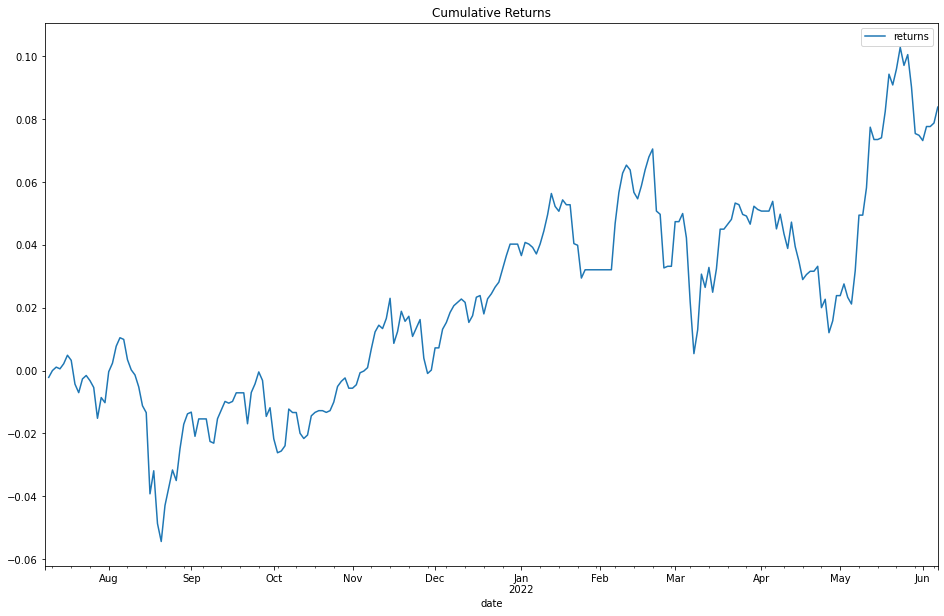

Sharpe Ratio:  0.6817962667771689
Annualized Sharpe Ratio:  10.823180200227828
Maximum Drawdown:  0.0650977287458836
Annualized Return:  5.47192421517345
Annualized Volatility:  0.5055745274441856
Sortino Ratio:  1.870604189036318
Annualized Sortino Ratio:  29.694920913754526
Calmar Ratio:  84.05706805123309
Omega Ratio:  5.932046990717358
Skewness:  0.23790538430788444
----------------------------------------------------------------------------
The Cumulative Returns for 00878 TT Equity in the Test Set: 


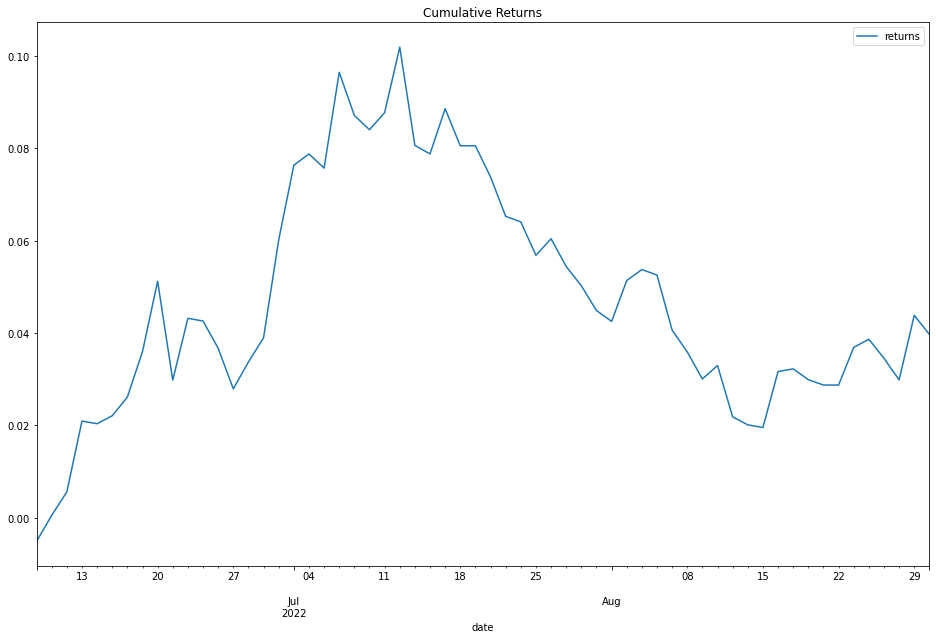

Sharpe Ratio:  1.913870549087563
Annualized Sharpe Ratio:  30.381753086737966
Maximum Drawdown:  0.08237744699279159
Annualized Return:  11.90688369361397
Annualized Volatility:  0.3919090402591509
Sortino Ratio:  nan
Annualized Sortino Ratio:  nan
Calmar Ratio:  144.54057667817597
Omega Ratio:  558.8595508304389
Skewness:  0.3382689525799272
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('AEGE GY Equity', 'cluster_Business Impact')
----------------------------------------------------------------------------
The Cumulative Returns for AEGE GY Equity in the Training Set: 


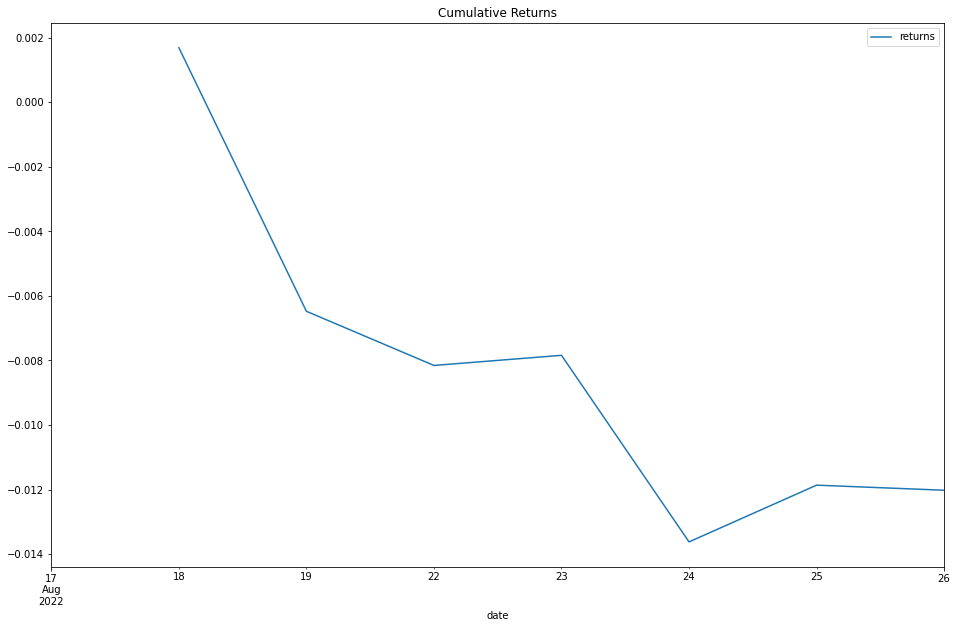

Sharpe Ratio:  -1.6216780011582181
Annualized Sharpe Ratio:  -25.743340186133764
Maximum Drawdown:  0.015308923962315535
Annualized Return:  -2.0981844391571505
Annualized Volatility:  0.08150397050213802
Sortino Ratio:  -2.9026326998895433
Annualized Sortino Ratio:  -46.077865627630274
Calmar Ratio:  -137.0562976419534
Omega Ratio:  0.028165646644068936
Skewness:  1.3242016190794363
----------------------------------------------------------------------------
The Cumulative Returns for AEGE GY Equity in the Test Set: 


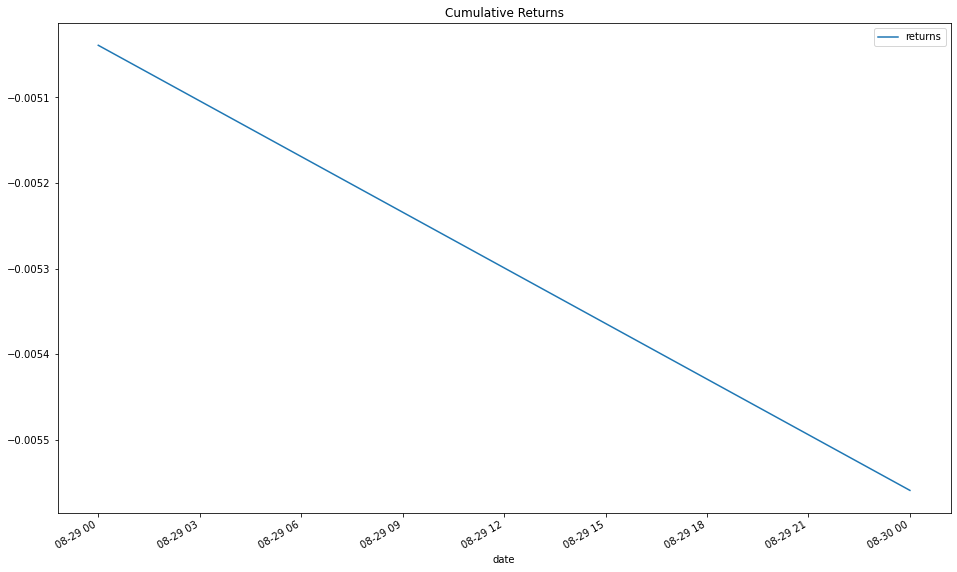

Sharpe Ratio:  -14.410913507826738
Annualized Sharpe Ratio:  -228.76615984182607
Maximum Drawdown:  0.0005200208008320217
Annualized Return:  -1.3353581775601522
Annualized Volatility:  0.005837219012127704
Sortino Ratio:  -14.410913507826738
Annualized Sortino Ratio:  -228.76615984182607
Calmar Ratio:  -2567.8937754482295
Omega Ratio:  0.0
Skewness:  nan
----------------------------------------------------------------------------
The column AEGE GY Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('AFLT FP Equity', 'cluster_Societal Debate')
----------------------------------------------------------------------------
The Cumulative Returns for AFLT FP Equity in the Training Set: 


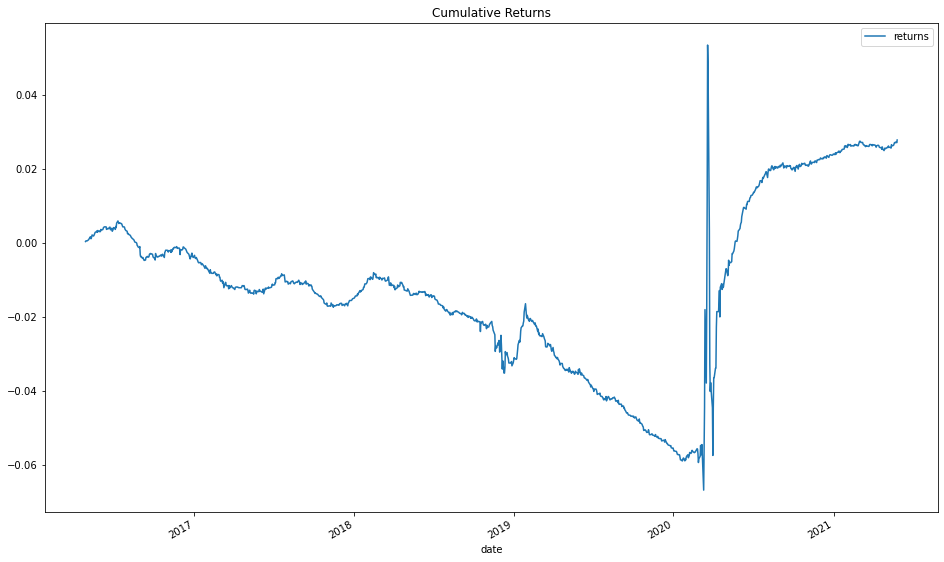

Sharpe Ratio:  -0.5124351615369694
Annualized Sharpe Ratio:  -8.134656002832193
Maximum Drawdown:  0.11095065472834609
Annualized Return:  -2.9384272462231547
Annualized Volatility:  0.36122329514611323
Sortino Ratio:  -0.7205815066890842
Annualized Sortino Ratio:  -11.438876796309255
Calmar Ratio:  -26.48409108912121
Omega Ratio:  0.28109420320546696
Skewness:  -0.09345175866188764
----------------------------------------------------------------------------
The Cumulative Returns for AFLT FP Equity in the Test Set: 


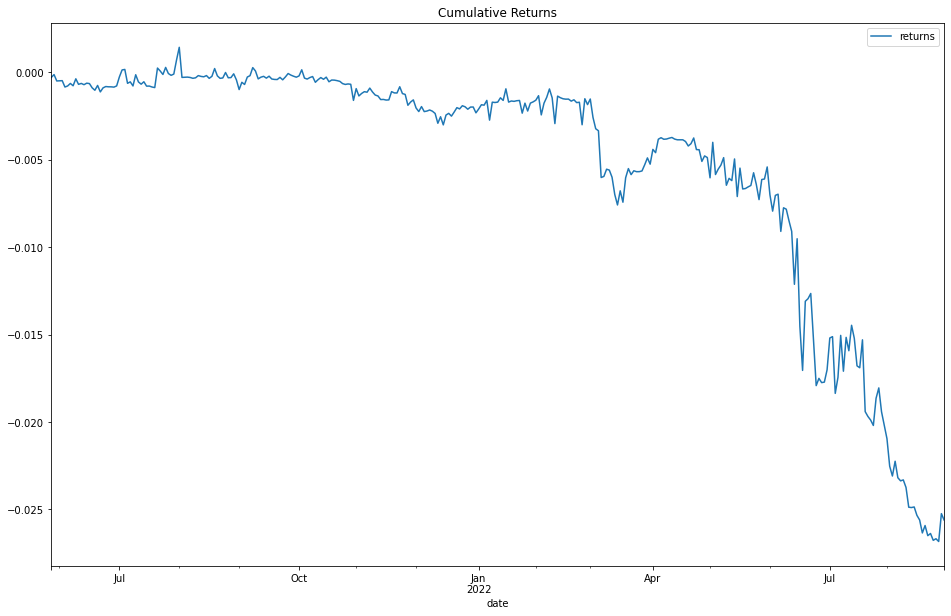

Sharpe Ratio:  -0.7281194752551814
Annualized Sharpe Ratio:  -11.558538337608347
Maximum Drawdown:  0.0282580448403823
Annualized Return:  -1.3116197259328832
Annualized Volatility:  0.11347626210359389
Sortino Ratio:  -0.723426388245284
Annualized Sortino Ratio:  -11.484037890952091
Calmar Ratio:  -46.41579887574198
Omega Ratio:  0.0021659015907428253
Skewness:  -1.7297454410226842
----------------------------------------------------------------------------
The column AFLT FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('AFRN FP Equity', 'cluster_Societal Debate')
----------------------------------------------------------------------------
The Cumulative Returns for AFRN FP Equity in the Training Set: 


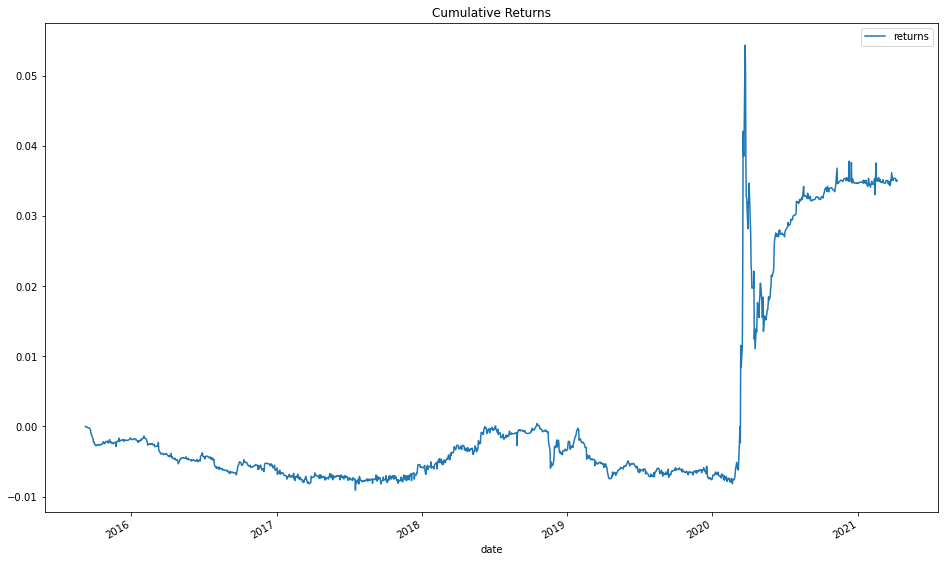

Sharpe Ratio:  0.14009397753933517
Annualized Sharpe Ratio:  2.2239229484816962
Maximum Drawdown:  0.043330803668800044
Annualized Return:  0.513924143472371
Annualized Volatility:  0.23108900594925486
Sortino Ratio:  0.8917986934700196
Annualized Sortino Ratio:  14.15686537472396
Calmar Ratio:  11.860480304047938
Omega Ratio:  1.5187220927493406
Skewness:  1.60290143886437
----------------------------------------------------------------------------
The Cumulative Returns for AFRN FP Equity in the Test Set: 


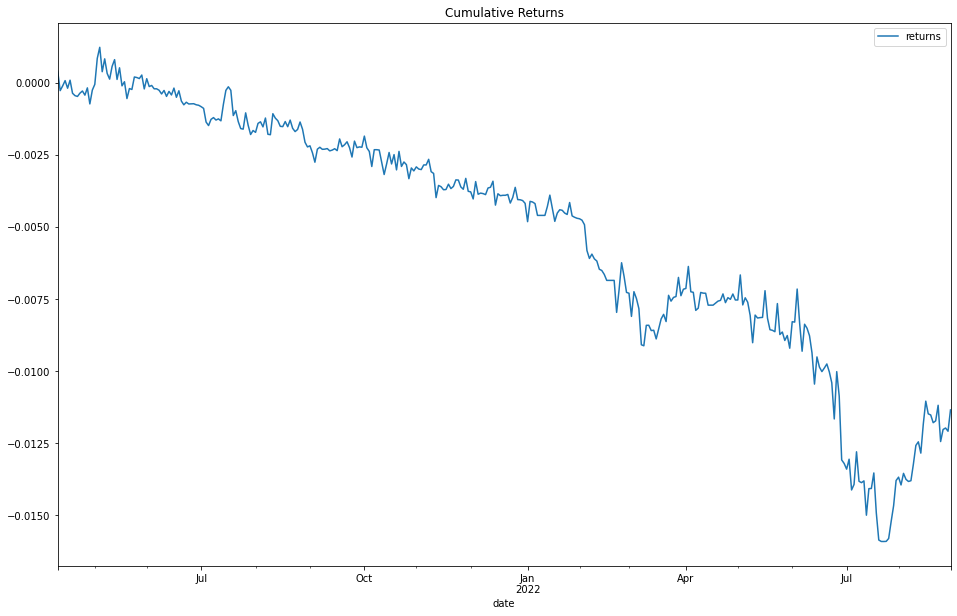

Sharpe Ratio:  -1.2025201798128897
Annualized Sharpe Ratio:  -19.089416053929483
Maximum Drawdown:  0.017125368815970266
Annualized Return:  -1.3007824101259913
Annualized Volatility:  0.06814155060852321
Sortino Ratio:  -1.2288530157685436
Annualized Sortino Ratio:  -19.5074368654518
Calmar Ratio:  -75.95646109022461
Omega Ratio:  0.0038224233344394333
Skewness:  -0.6913237624874847
----------------------------------------------------------------------------
The column AFRN FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('CHESG SW Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for CHESG SW Equity in the Training Set: 


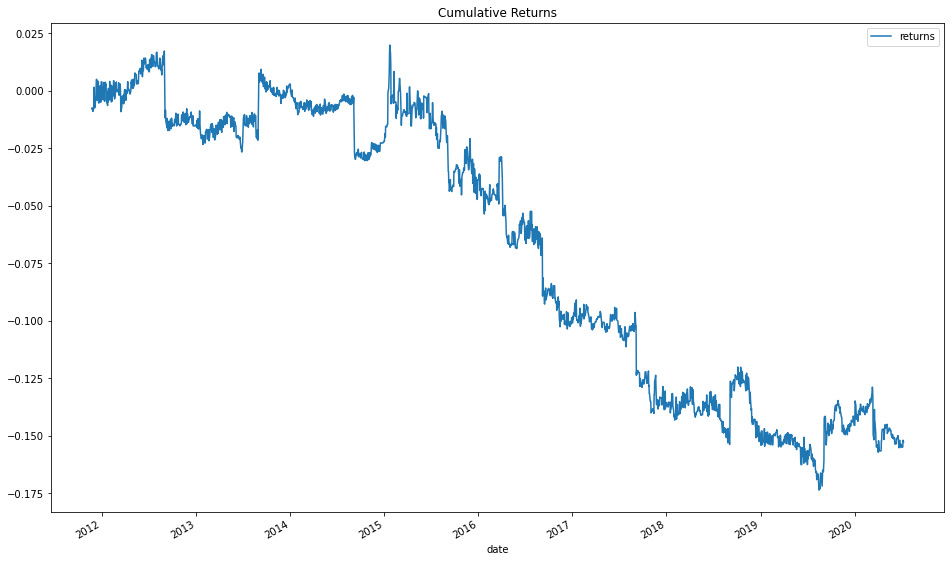

Sharpe Ratio:  -1.1142465926938314
Annualized Sharpe Ratio:  -17.688116300813746
Maximum Drawdown:  0.19354634502643986
Annualized Return:  -17.057118976126127
Annualized Volatility:  0.9643264825967597
Sortino Ratio:  -1.1506475475250408
Annualized Sortino Ratio:  -18.265963544625798
Calmar Ratio:  -88.12937786965699
Omega Ratio:  0.00828783408498867
Skewness:  -0.22200369112831708
----------------------------------------------------------------------------
The Cumulative Returns for CHESG SW Equity in the Test Set: 


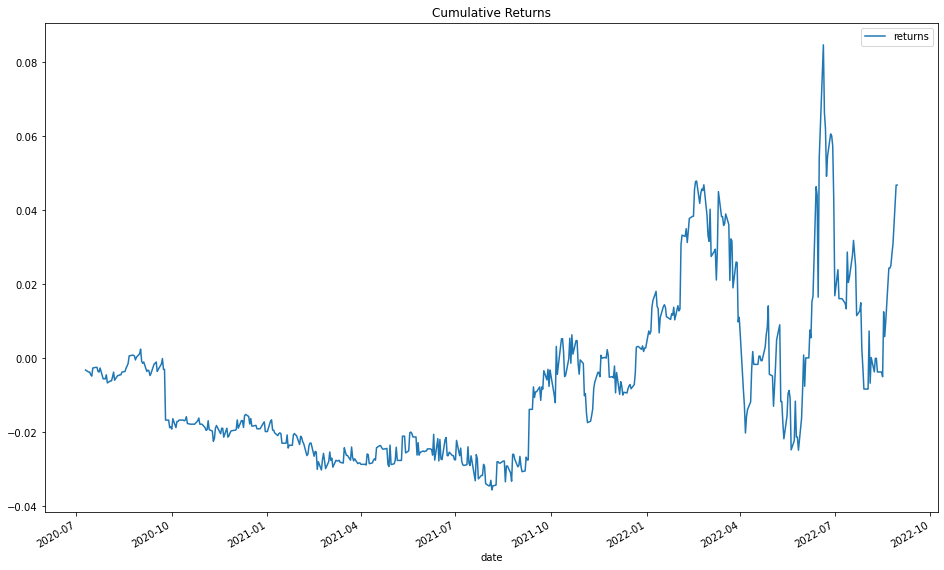

Sharpe Ratio:  -0.31461068478708837
Annualized Sharpe Ratio:  -4.994289790502206
Maximum Drawdown:  0.09303272586337374
Annualized Return:  -1.6841528067962475
Annualized Volatility:  0.3372156757901899
Sortino Ratio:  -0.6925354511411592
Annualized Sortino Ratio:  -10.993659466892579
Calmar Ratio:  -18.102799753170356
Omega Ratio:  0.4657068227161201
Skewness:  1.2222442527388702
----------------------------------------------------------------------------
The column CHESG SW Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('CRP FP Equity', 'cluster_Business Impact')
----------------------------------------------------------------------------
The Cumulative Returns for CRP FP Equity in the Training Set: 


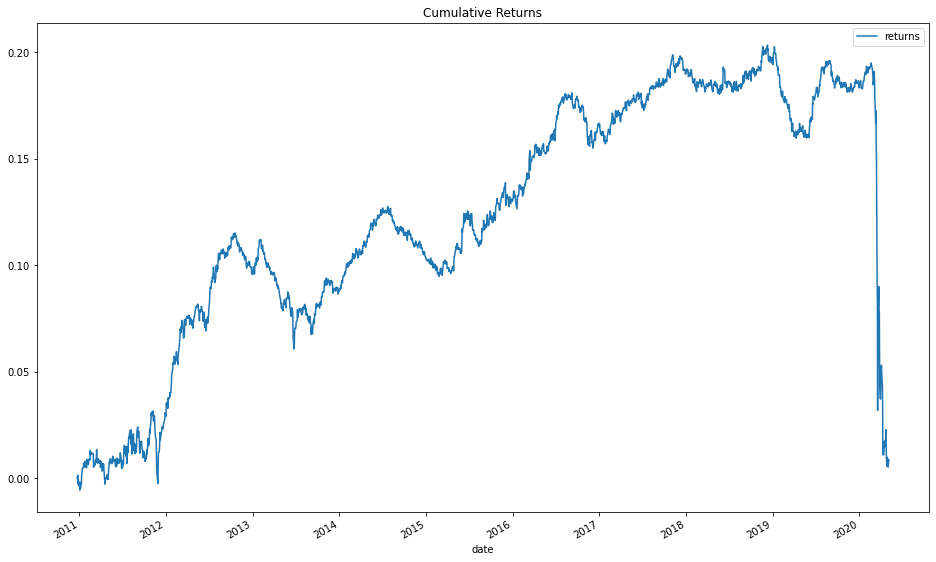

Sharpe Ratio:  2.1507301143676067
Annualized Sharpe Ratio:  34.14178211900516
Maximum Drawdown:  0.19809403526915903
Annualized Return:  31.192486789701437
Annualized Volatility:  0.9136162453669348
Sortino Ratio:  82.72520933363498
Annualized Sortino Ratio:  1313.2219863153448
Calmar Ratio:  157.4630288454614
Omega Ratio:  7382.606451787268
Skewness:  -0.5643724644597751
----------------------------------------------------------------------------
The Cumulative Returns for CRP FP Equity in the Test Set: 


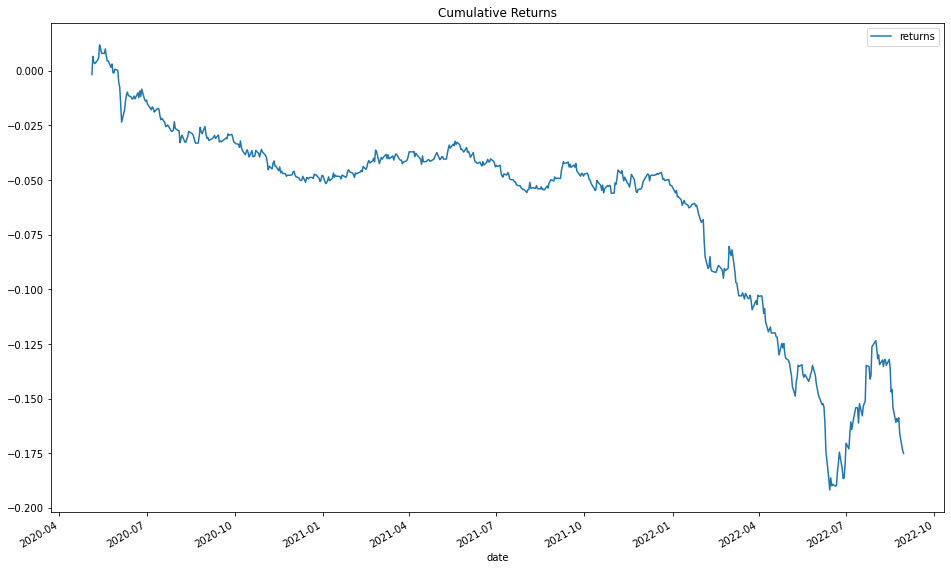

Sharpe Ratio:  -1.4099116904725701
Annualized Sharpe Ratio:  -22.381654221318577
Maximum Drawdown:  0.20375516061084686
Annualized Return:  -15.740771970712018
Annualized Volatility:  0.7032890337354466
Sortino Ratio:  -1.440097720394517
Annualized Sortino Ratio:  -22.86084259076953
Calmar Ratio:  -77.2533658706952
Omega Ratio:  0.0025029357873622275
Skewness:  -1.2165854492631454
----------------------------------------------------------------------------
The column CRP FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('EAGG US Equity', 'cluster_Environmental Impact')
----------------------------------------------------------------------------
The Cumulative Returns for EAGG US Equity in the Training Set: 


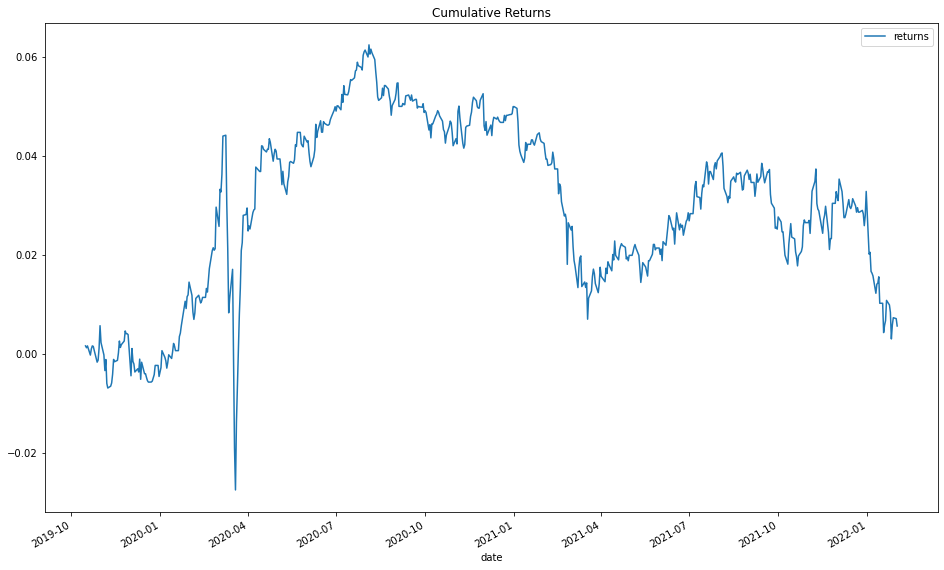

Sharpe Ratio:  1.6877119990663674
Annualized Sharpe Ratio:  26.791597405375697
Maximum Drawdown:  0.07170527887593603
Annualized Return:  7.406577209880441
Annualized Volatility:  0.27645149700533805
Sortino Ratio:  5.966778756623789
Annualized Sortino Ratio:  94.71967630901842
Calmar Ratio:  103.29193785990637
Omega Ratio:  93.34777407326891
Skewness:  -0.4020155455378377
----------------------------------------------------------------------------
The Cumulative Returns for EAGG US Equity in the Test Set: 


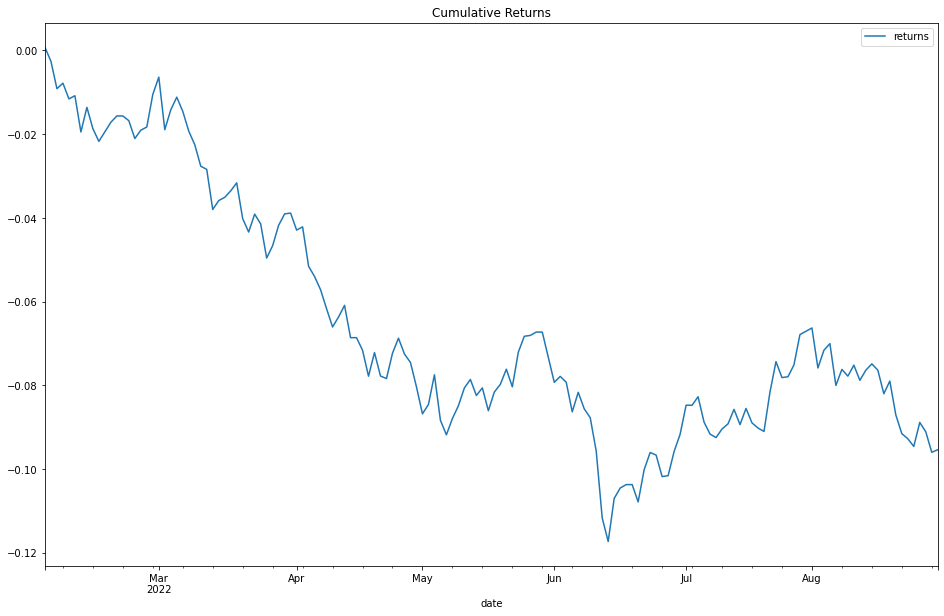

Sharpe Ratio:  -2.227646581260034
Annualized Sharpe Ratio:  -35.362793177743725
Maximum Drawdown:  0.11803261094789819
Annualized Return:  -16.431679389450167
Annualized Volatility:  0.46466011061003437
Sortino Ratio:  -2.2592410516957018
Annualized Sortino Ratio:  -35.86433984720909
Calmar Ratio:  -139.21304677995658
Omega Ratio:  7.61375856017404e-05
Skewness:  0.69272331220823
----------------------------------------------------------------------------
The column EAGG US Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('EFRN GY Equity', 'cluster_Societal Debate')
----------------------------------------------------------------------------
The Cumulative Returns for EFRN GY Equity in the Training Set: 


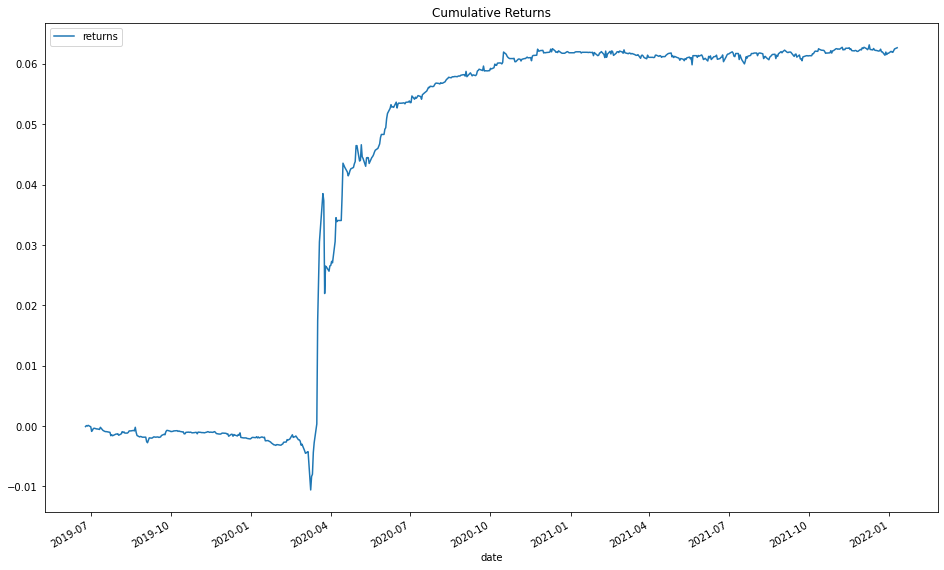

Sharpe Ratio:  1.4794374413318707
Annualized Sharpe Ratio:  23.485341300251044
Maximum Drawdown:  0.01654896148895335
Annualized Return:  10.332055253919291
Annualized Volatility:  0.4399363467546818
Sortino Ratio:  32.07933029580435
Annualized Sortino Ratio:  509.2435811291904
Calmar Ratio:  624.3325456292876
Omega Ratio:  86.70866665720669
Skewness:  -0.8210136899287515
----------------------------------------------------------------------------
The Cumulative Returns for EFRN GY Equity in the Test Set: 


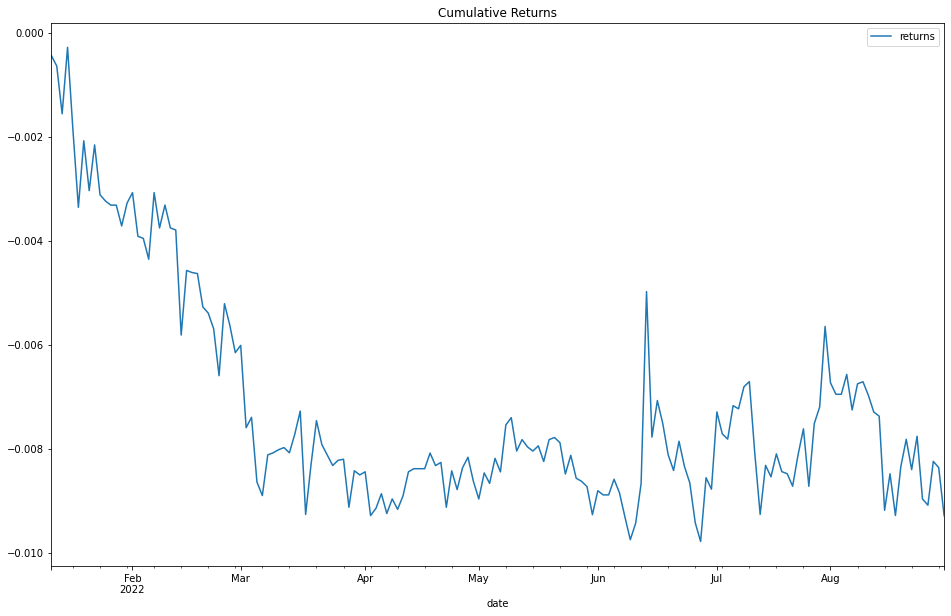

Sharpe Ratio:  -3.4242970934168095
Annualized Sharpe Ratio:  -54.35903114629315
Maximum Drawdown:  0.009501263207879584
Annualized Return:  -1.8202984593440614
Annualized Volatility:  0.03348658761862777
Sortino Ratio:  -3.4242970934168095
Annualized Sortino Ratio:  -54.35903114629315
Calmar Ratio:  -191.5848892423538
Omega Ratio:  0.0
Skewness:  1.4579529487569094
----------------------------------------------------------------------------
The column EFRN GY Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGB CN Equity', 'cluster_Environmental Impact')
----------------------------------------------------------------------------
The Cumulative Returns for ESGB CN Equity in the Training Set: 


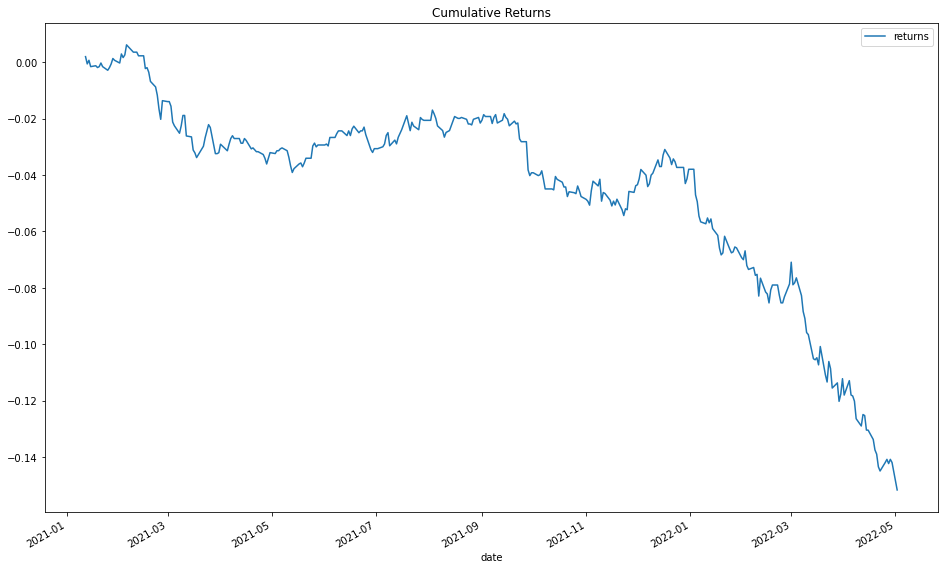

Sharpe Ratio:  -1.2887448033815283
Annualized Sharpe Ratio:  -20.45818951904614
Maximum Drawdown:  0.15766344850907965
Annualized Return:  -11.135394799713072
Annualized Volatility:  0.5443001097113827
Sortino Ratio:  -1.3159196880503201
Annualized Sortino Ratio:  -20.88957743948905
Calmar Ratio:  -70.62762425288318
Omega Ratio:  0.0024460596003260593
Skewness:  -1.2974836774986
----------------------------------------------------------------------------
The Cumulative Returns for ESGB CN Equity in the Test Set: 


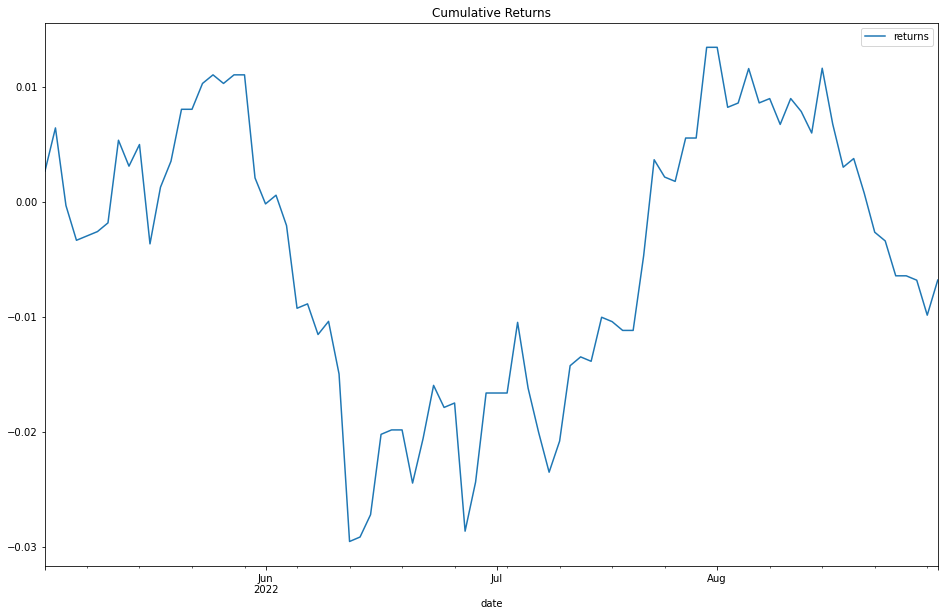

Sharpe Ratio:  -0.3871008918526011
Annualized Sharpe Ratio:  -6.14503615279975
Maximum Drawdown:  0.040565315895196075
Annualized Return:  -1.155609057321807
Annualized Volatility:  0.18805569708410877
Sortino Ratio:  -0.5581283430699725
Annualized Sortino Ratio:  -8.860012772518125
Calmar Ratio:  -28.487613909070024
Omega Ratio:  0.3841296342950166
Skewness:  -0.3649388327859348
----------------------------------------------------------------------------
The column ESGB CN Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGEMC SW Equity', 'cluster_Business Impact')
----------------------------------------------------------------------------
The Cumulative Returns for ESGEMC SW Equity in the Training Set: 


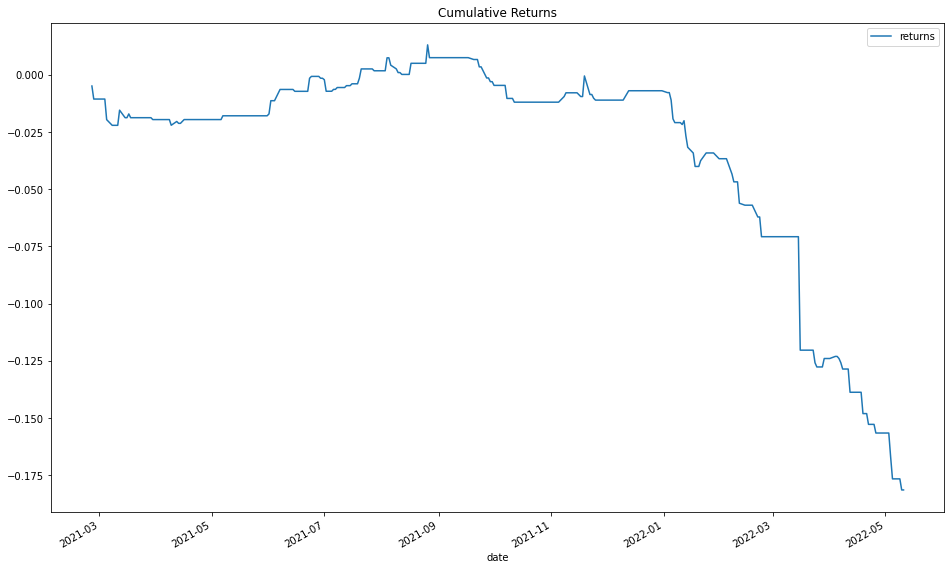

Sharpe Ratio:  -0.6863579112281575
Annualized Sharpe Ratio:  -10.89559406094871
Maximum Drawdown:  0.19459692365809123
Annualized Return:  -8.062511294222782
Annualized Volatility:  0.7399790455776908
Sortino Ratio:  -0.6712974183866582
Annualized Sortino Ratio:  -10.656516148864657
Calmar Ratio:  -41.431853816911804
Omega Ratio:  0.023599957608779937
Skewness:  -1.7643142105402678
----------------------------------------------------------------------------
The Cumulative Returns for ESGEMC SW Equity in the Test Set: 


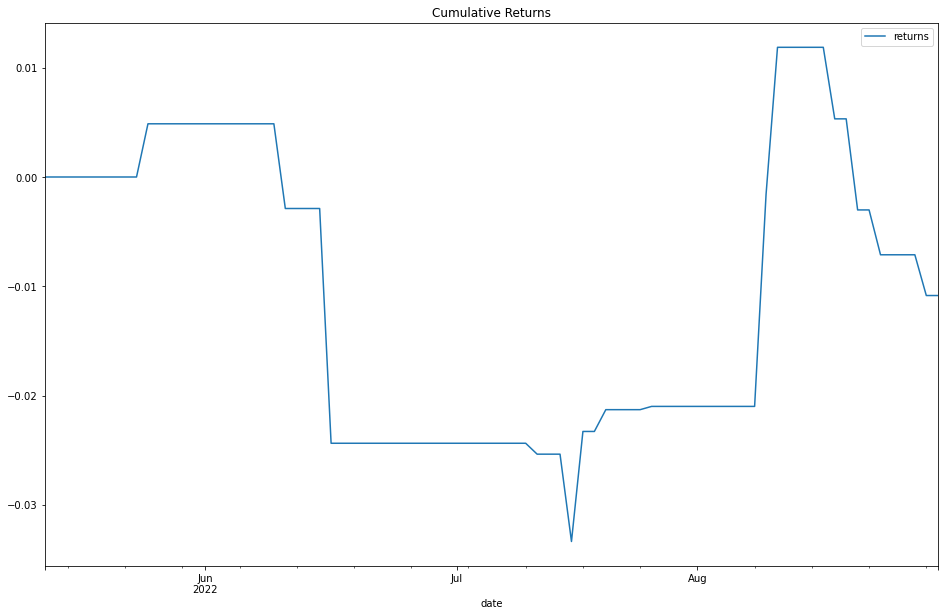

Sharpe Ratio:  -0.7893953302701812
Annualized Sharpe Ratio:  -12.531262380063584
Maximum Drawdown:  0.0382263249685203
Annualized Return:  -2.6497978465186054
Annualized Volatility:  0.2114549808432916
Sortino Ratio:  -1.2581294423735463
Annualized Sortino Ratio:  -19.972185729892637
Calmar Ratio:  -69.31866583305448
Omega Ratio:  0.13388350407545846
Skewness:  0.17462171377412275
----------------------------------------------------------------------------
The column ESGEMC SW Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGF CN Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for ESGF CN Equity in the Training Set: 


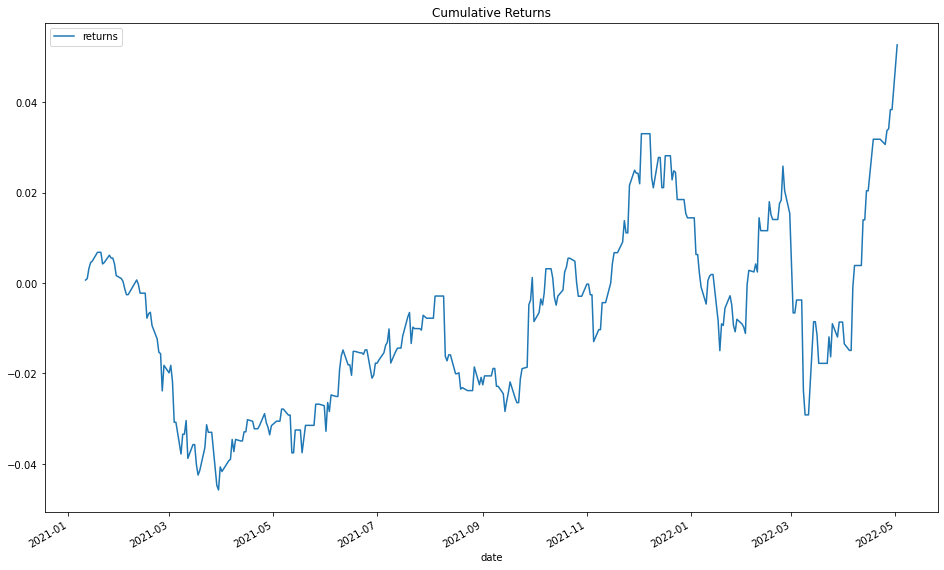

Sharpe Ratio:  -0.43363237286912765
Annualized Sharpe Ratio:  -6.883700514231264
Maximum Drawdown:  0.06216209747842538
Annualized Return:  -2.0938385513512245
Annualized Volatility:  0.3041733943861231
Sortino Ratio:  -0.7148858318536043
Annualized Sortino Ratio:  -11.348460761329045
Calmar Ratio:  -33.68352478900722
Omega Ratio:  0.3488740927246918
Skewness:  0.42104321943977285
----------------------------------------------------------------------------
The Cumulative Returns for ESGF CN Equity in the Test Set: 


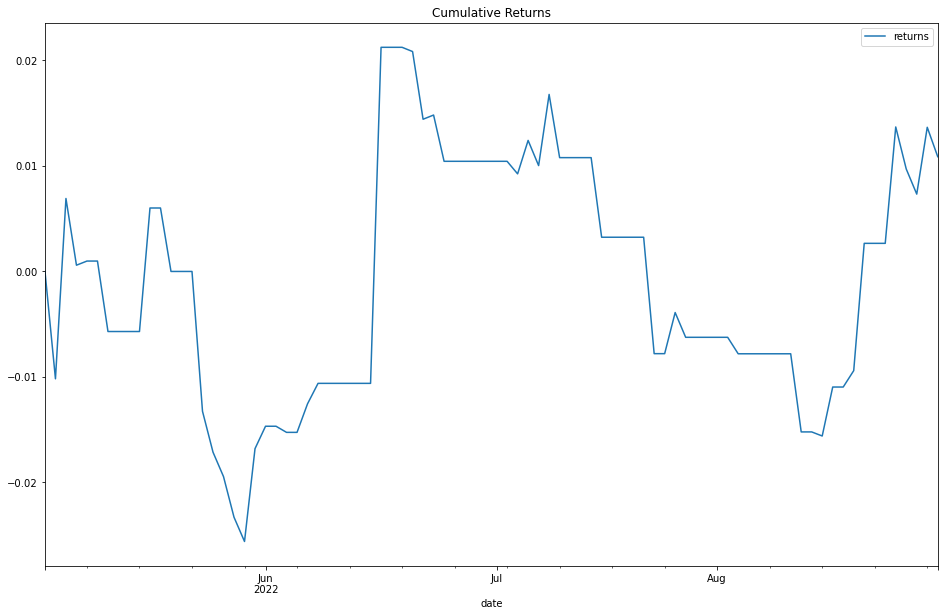

Sharpe Ratio:  -0.08448831363211504
Annualized Sharpe Ratio:  -1.3412103993708282
Maximum Drawdown:  0.0368618594270782
Annualized Return:  -0.24067301171862793
Annualized Volatility:  0.17944463585394912
Sortino Ratio:  -0.1735549222496596
Annualized Sortino Ratio:  -2.7550989785024997
Calmar Ratio:  -6.529052398855195
Omega Ratio:  0.8217561054697665
Skewness:  0.09962229545476438
----------------------------------------------------------------------------
The column ESGF CN Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGGB SE Equity', 'cluster_Business Impact')
----------------------------------------------------------------------------
The Cumulative Returns for ESGGB SE Equity in the Training Set: 


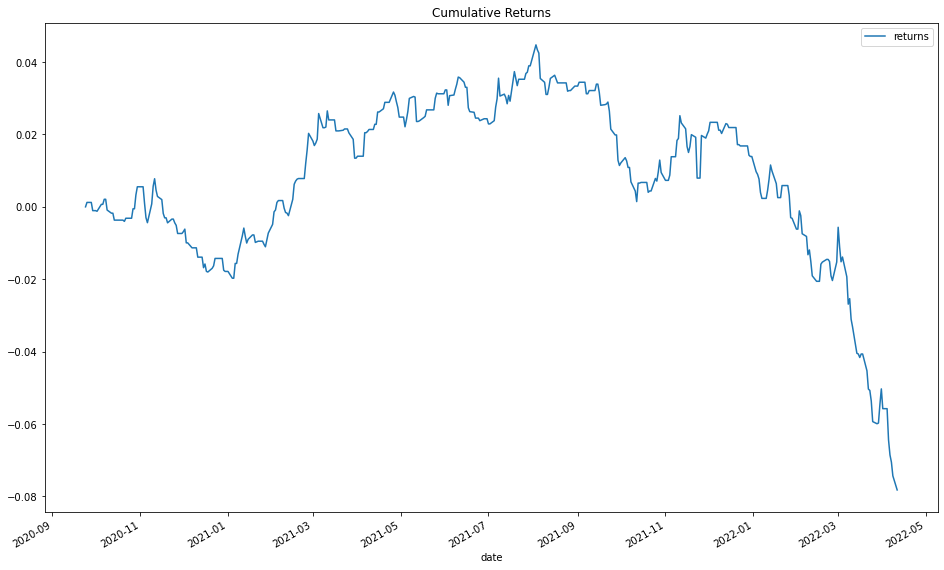

Sharpe Ratio:  0.35785632866948913
Annualized Sharpe Ratio:  5.6807931045003714
Maximum Drawdown:  0.12297063284399556
Annualized Return:  2.0327630120627385
Annualized Volatility:  0.3578308476773018
Sortino Ratio:  0.44204583583606566
Annualized Sortino Ratio:  7.017260098283481
Calmar Ratio:  16.530475326101364
Omega Ratio:  2.4200860067311423
Skewness:  -1.1164154243524012
----------------------------------------------------------------------------
The Cumulative Returns for ESGGB SE Equity in the Test Set: 


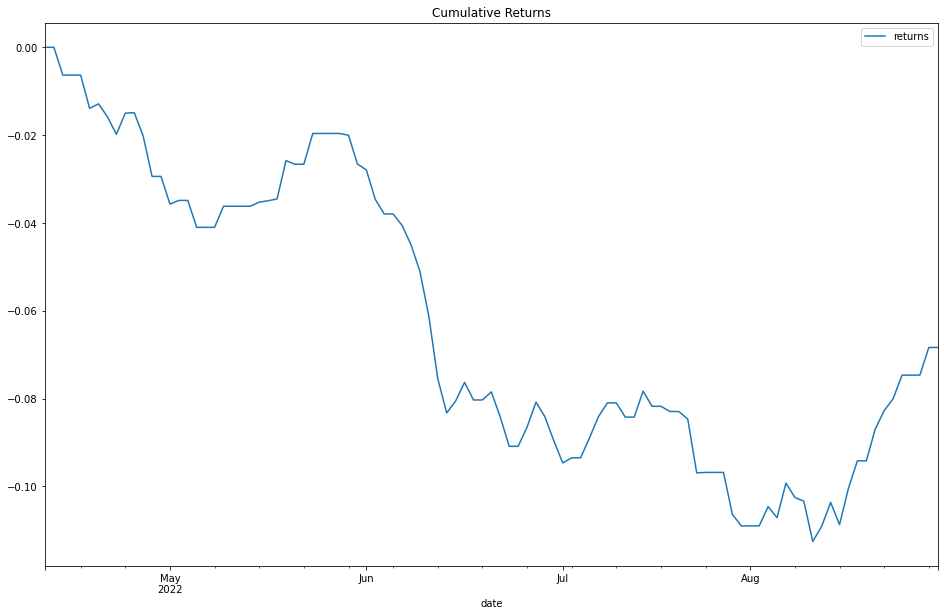

Sharpe Ratio:  -1.8750277414506915
Annualized Sharpe Ratio:  -29.76514263135387
Maximum Drawdown:  0.11253795730720728
Annualized Return:  -15.76382253056737
Annualized Volatility:  0.5296068198229343
Sortino Ratio:  -1.9265698771610826
Annualized Sortino Ratio:  -30.583348670138893
Calmar Ratio:  -140.07560566907327
Omega Ratio:  0.0
Skewness:  0.26241072304676033
----------------------------------------------------------------------------
The column ESGGB SE Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGGB SW Equity', 'cluster_Business Impact')
----------------------------------------------------------------------------
The Cumulative Returns for ESGGB SW Equity in the Training Set: 


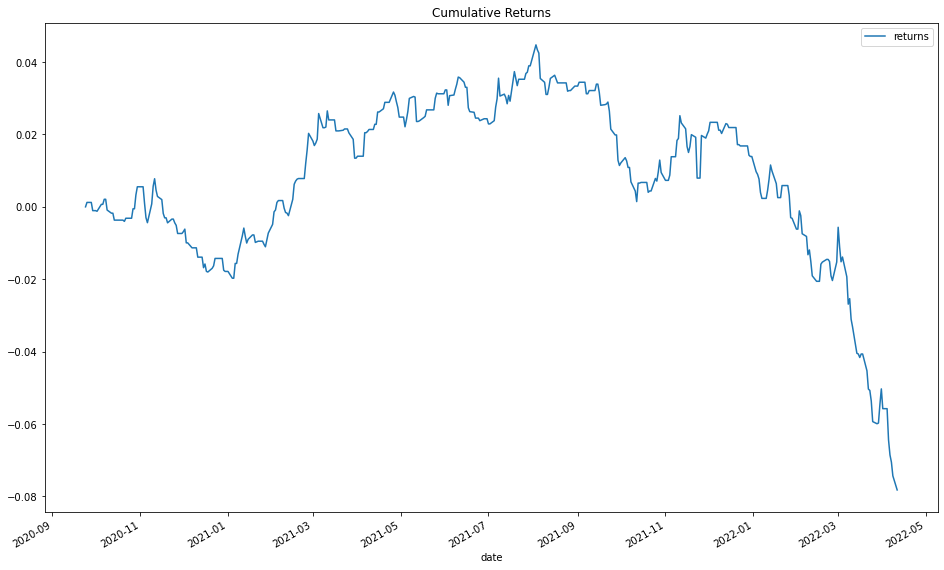

Sharpe Ratio:  0.35785632866948913
Annualized Sharpe Ratio:  5.6807931045003714
Maximum Drawdown:  0.12297063284399556
Annualized Return:  2.0327630120627385
Annualized Volatility:  0.3578308476773018
Sortino Ratio:  0.44204583583606566
Annualized Sortino Ratio:  7.017260098283481
Calmar Ratio:  16.530475326101364
Omega Ratio:  2.4200860067311423
Skewness:  -1.1164154243524012
----------------------------------------------------------------------------
The Cumulative Returns for ESGGB SW Equity in the Test Set: 


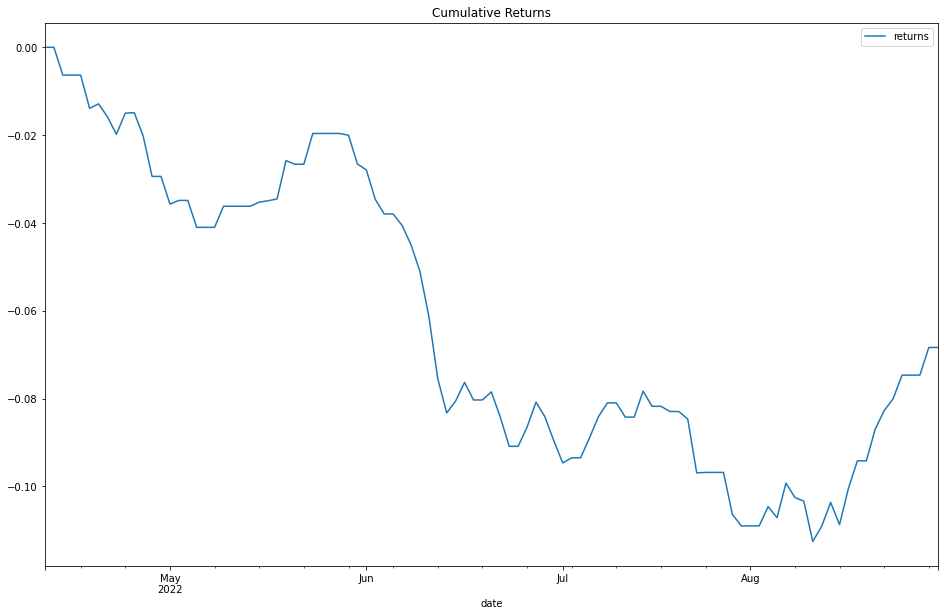

Sharpe Ratio:  -1.8750277414506915
Annualized Sharpe Ratio:  -29.76514263135387
Maximum Drawdown:  0.11253795730720728
Annualized Return:  -15.76382253056737
Annualized Volatility:  0.5296068198229343
Sortino Ratio:  -1.9265698771610826
Annualized Sortino Ratio:  -30.583348670138893
Calmar Ratio:  -140.07560566907327
Omega Ratio:  0.0
Skewness:  0.26241072304676033
----------------------------------------------------------------------------
The column ESGGB SW Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGGBD SE Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for ESGGBD SE Equity in the Training Set: 


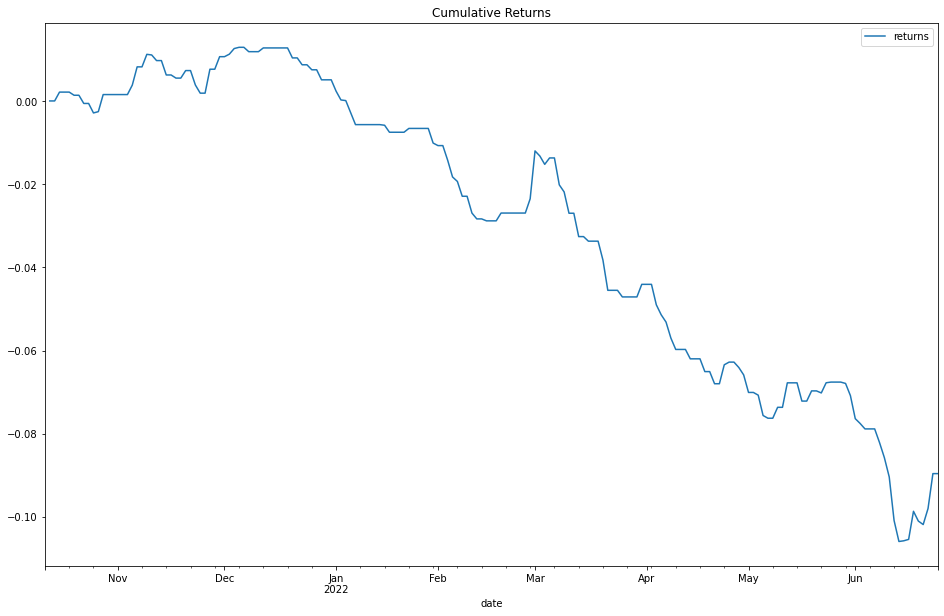

Sharpe Ratio:  -0.8375587972986333
Annualized Sharpe Ratio:  -13.295833716279244
Maximum Drawdown:  0.11880837781405873
Annualized Return:  -7.378345943646999
Annualized Volatility:  0.5549366892738024
Sortino Ratio:  -0.9772327518138538
Annualized Sortino Ratio:  -15.51308900596057
Calmar Ratio:  -62.102909570859495
Omega Ratio:  0.06830906292926718
Skewness:  -0.4890405923153051
----------------------------------------------------------------------------
The Cumulative Returns for ESGGBD SE Equity in the Test Set: 


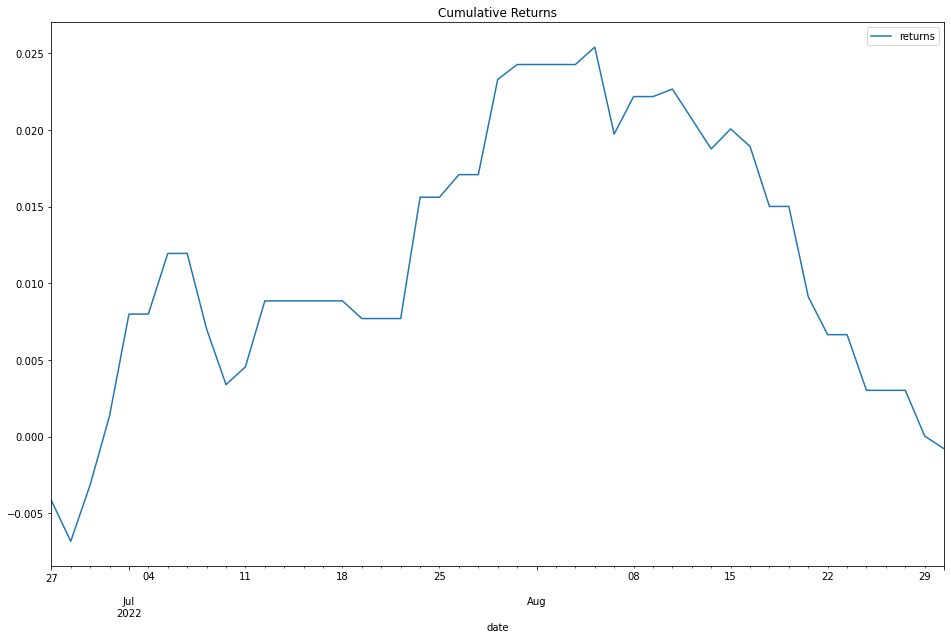

Sharpe Ratio:  1.337640637858597
Annualized Sharpe Ratio:  21.23438682808595
Maximum Drawdown:  0.026201319169018356
Annualized Return:  2.9315000971636667
Annualized Volatility:  0.1380543794787744
Sortino Ratio:  4.656274953882522
Annualized Sortino Ratio:  73.9160733834714
Calmar Ratio:  111.88368334637163
Omega Ratio:  37.659935934675296
Skewness:  -0.08452462992160327
----------------------------------------------------------------------------
The column ESGGBD SE Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGGBS SW Equity', 'cluster_Business Impact')
----------------------------------------------------------------------------
The Cumulative Returns for ESGGBS SW Equity in the Training Set: 


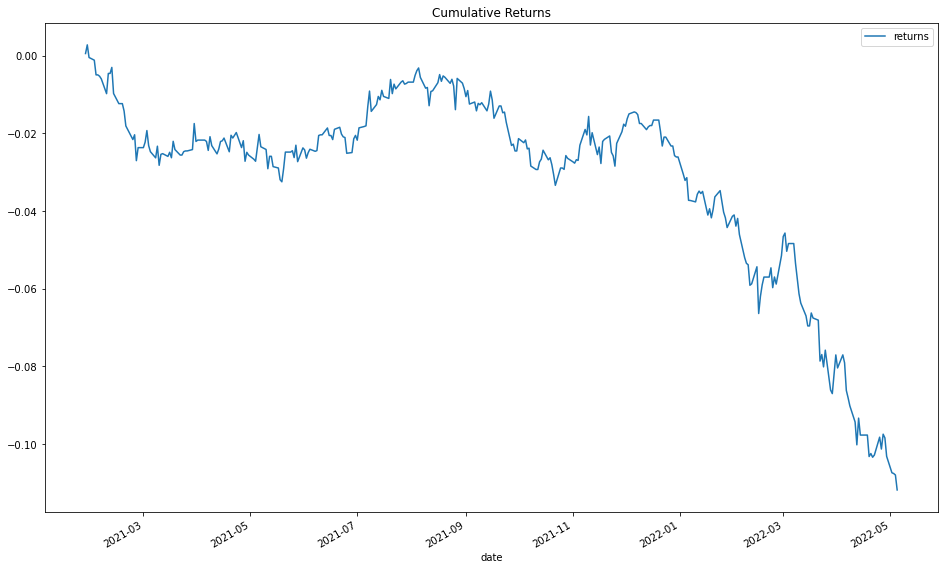

Sharpe Ratio:  -1.2523728910666017
Annualized Sharpe Ratio:  -19.88080331088728
Maximum Drawdown:  0.11456693388459926
Annualized Return:  -7.903783341664941
Annualized Volatility:  0.39755855022903475
Sortino Ratio:  -1.2552400946687585
Annualized Sortino Ratio:  -19.92631875702425
Calmar Ratio:  -68.98834658197492
Omega Ratio:  0.0003141444578932957
Skewness:  -1.5691419537489264
----------------------------------------------------------------------------
The Cumulative Returns for ESGGBS SW Equity in the Test Set: 


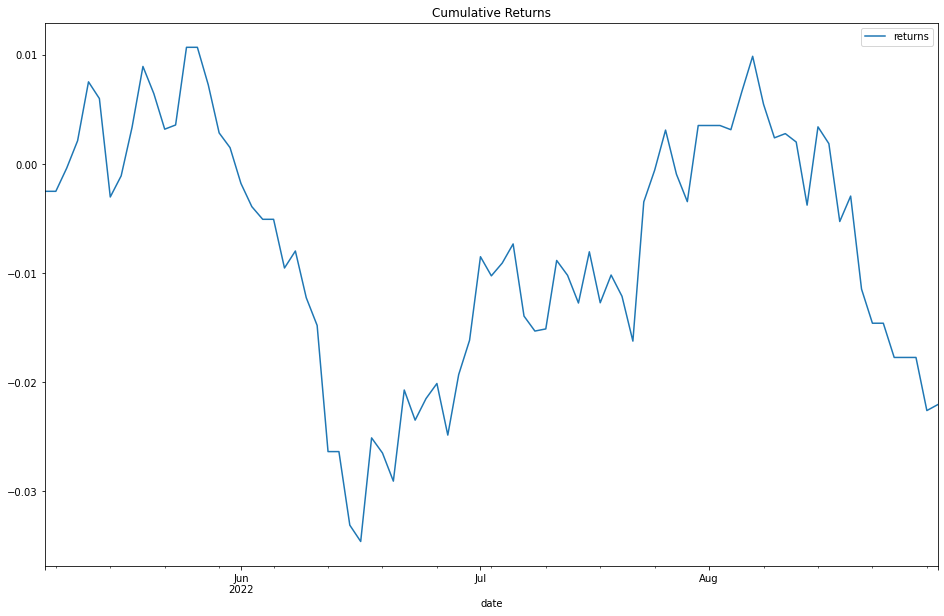

Sharpe Ratio:  -0.666329716736122
Annualized Sharpe Ratio:  -10.577656329935353
Maximum Drawdown:  0.04531570256632422
Annualized Return:  -1.888335237248111
Annualized Volatility:  0.1785211372299947
Sortino Ratio:  -0.8426117614122443
Annualized Sortino Ratio:  -13.376047034849336
Calmar Ratio:  -41.670660065003666
Omega Ratio:  0.16772521753315534
Skewness:  -0.40663568635197656
----------------------------------------------------------------------------
The column ESGGBS SW Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGH CN Equity', 'cluster_Societal Debate')
----------------------------------------------------------------------------
The Cumulative Returns for ESGH CN Equity in the Training Set: 


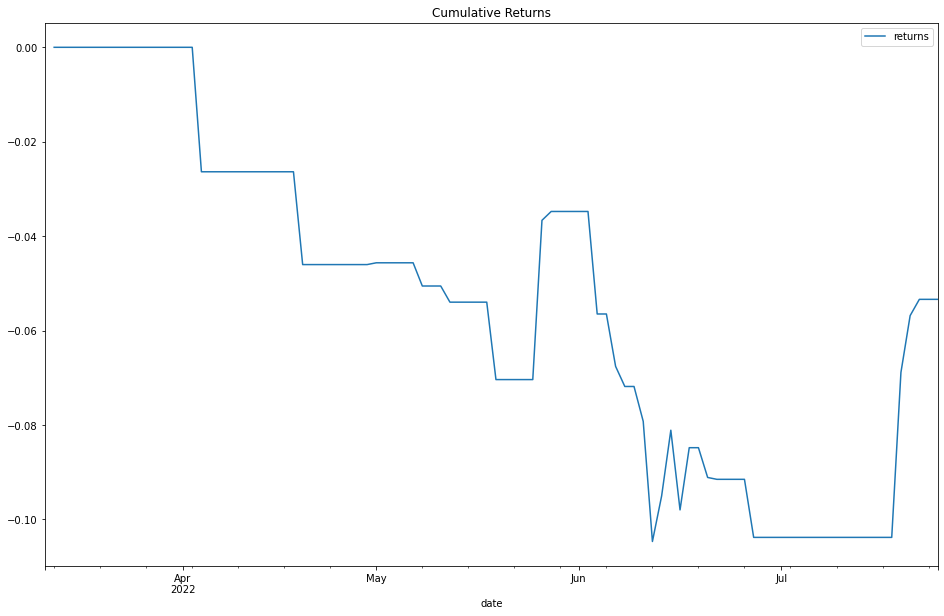

Sharpe Ratio:  -1.545589066179648
Annualized Sharpe Ratio:  -24.535465789271402
Maximum Drawdown:  0.10467615394464347
Annualized Return:  -13.577272135679607
Annualized Volatility:  0.5533733189453663
Sortino Ratio:  -1.9505799496368803
Annualized Sortino Ratio:  -30.964496754528476
Calmar Ratio:  -129.7074034919143
Omega Ratio:  0.0
Skewness:  0.02507551616082503
----------------------------------------------------------------------------
The Cumulative Returns for ESGH CN Equity in the Test Set: 


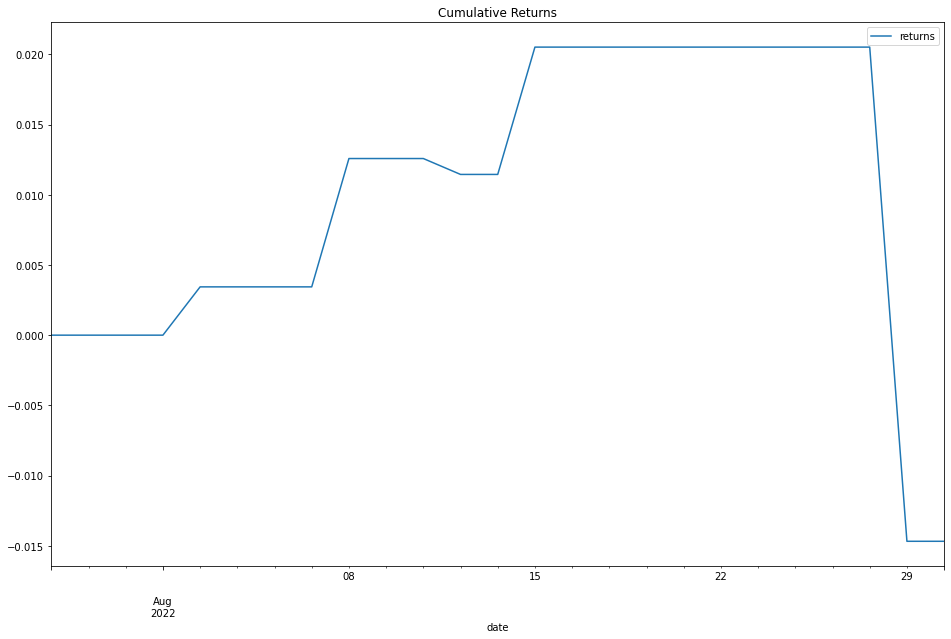

Sharpe Ratio:  0.907205125279275
Annualized Sharpe Ratio:  14.40143489767295
Maximum Drawdown:  0.0351928116810184
Annualized Return:  2.521584780707212
Annualized Volatility:  0.17509260699533918
Sortino Ratio:  inf
Annualized Sortino Ratio:  inf
Calmar Ratio:  71.65056329009525
Omega Ratio:  9.520578582265243
Skewness:  -0.7955684663001256
----------------------------------------------------------------------------
The column ESGH CN Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGO IM Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for ESGO IM Equity in the Training Set: 


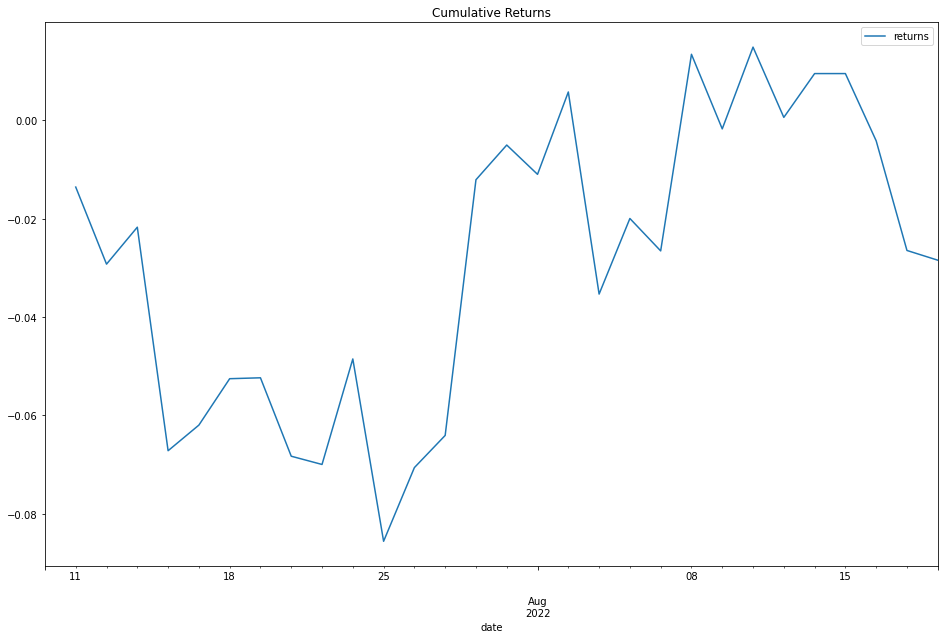

Sharpe Ratio:  -0.9458720943308815
Annualized Sharpe Ratio:  -15.015254002052039
Maximum Drawdown:  0.07205372829963774
Annualized Return:  -7.146241421435206
Annualized Volatility:  0.47593210347680925
Sortino Ratio:  -1.105034806017322
Annualized Sortino Ratio:  -17.54188372075401
Calmar Ratio:  -99.17934283313323
Omega Ratio:  0.061448484065280314
Skewness:  -0.2716593477005483
----------------------------------------------------------------------------
The Cumulative Returns for ESGO IM Equity in the Test Set: 


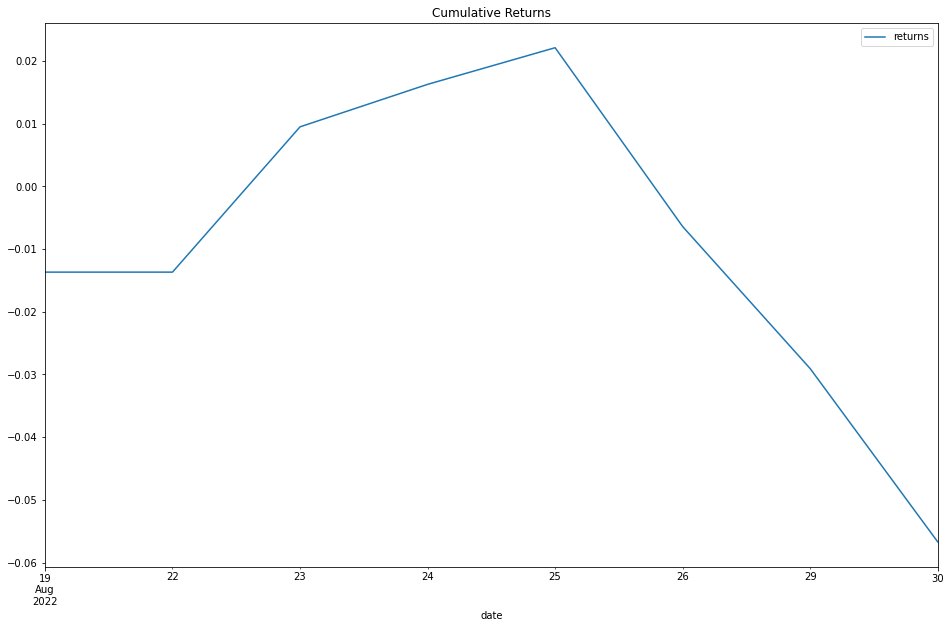

Sharpe Ratio:  -0.34648896444387406
Annualized Sharpe Ratio:  -5.500341791680753
Maximum Drawdown:  0.07881692138146401
Annualized Return:  -2.2570611059017844
Annualized Volatility:  0.4103492458078844
Sortino Ratio:  -0.44539158631174897
Annualized Sortino Ratio:  -7.070372240528686
Calmar Ratio:  -28.63675802532164
Omega Ratio:  0.4005619641988319
Skewness:  -0.7149327255806396
----------------------------------------------------------------------------
The column ESGO IM Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGO LN Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for ESGO LN Equity in the Training Set: 


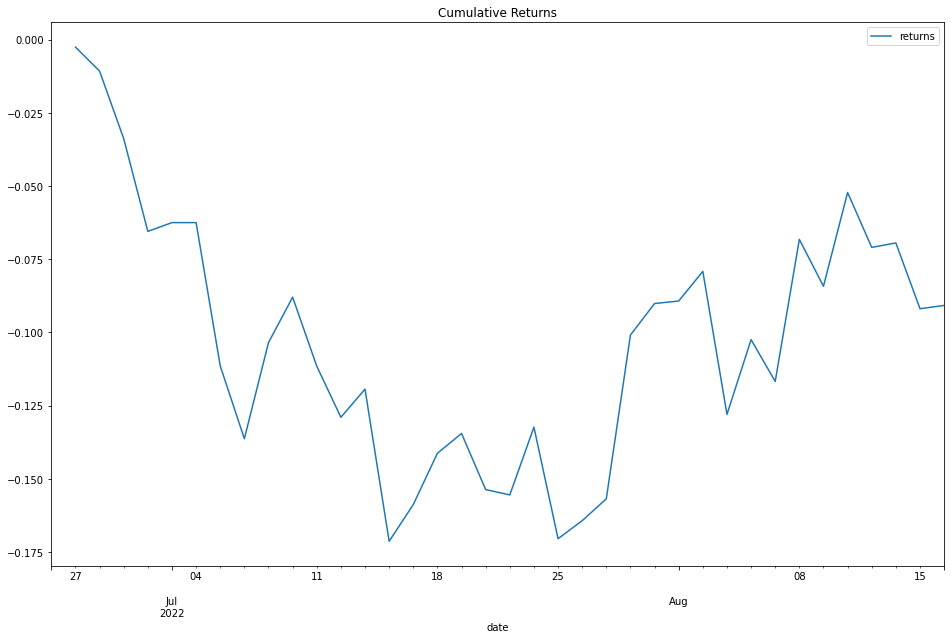

Sharpe Ratio:  -2.397403733223067
Annualized Sharpe Ratio:  -38.05760442195644
Maximum Drawdown:  0.16877680666993156
Annualized Return:  -25.95308849533454
Annualized Volatility:  0.6819422527909171
Sortino Ratio:  -2.397403733223067
Annualized Sortino Ratio:  -38.05760442195644
Calmar Ratio:  -153.77165267790443
Omega Ratio:  0.0
Skewness:  0.34586423382881687
----------------------------------------------------------------------------
The Cumulative Returns for ESGO LN Equity in the Test Set: 


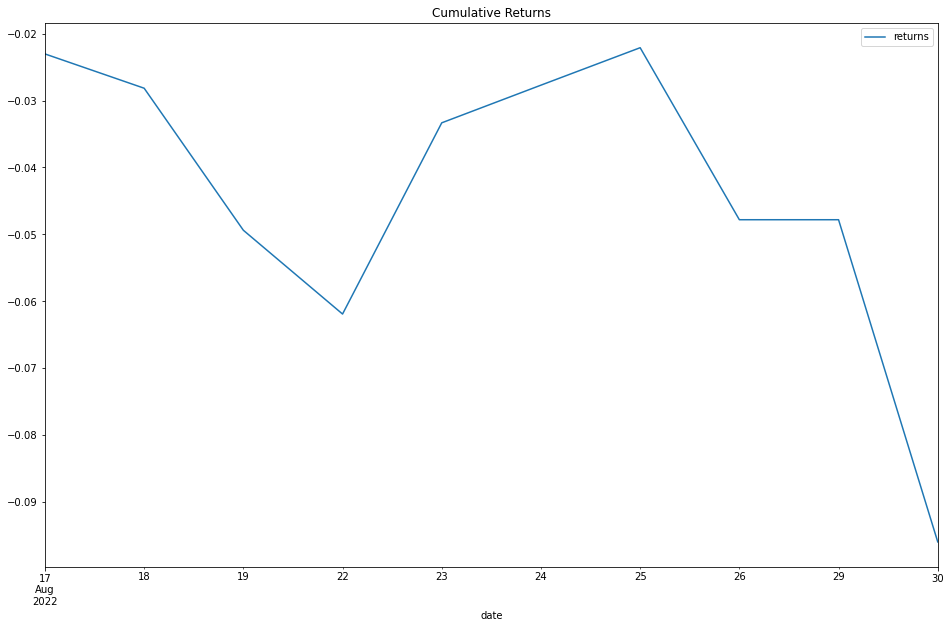

Sharpe Ratio:  -1.9288027473092364
Annualized Sharpe Ratio:  -30.61879438487038
Maximum Drawdown:  0.07383260771119415
Annualized Return:  -11.017770197190778
Annualized Volatility:  0.35983683938368827
Sortino Ratio:  -1.9288027473092364
Annualized Sortino Ratio:  -30.61879438487038
Calmar Ratio:  -149.22634508980394
Omega Ratio:  0.0
Skewness:  -1.4408466018628485
----------------------------------------------------------------------------
The column ESGO LN Equity does not have enough data.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
The column ESGSG SP Equity does not have enough data.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
The column ESGUS SP Equity does not have enough data.
----------------------------------------------------------------------------
The clus

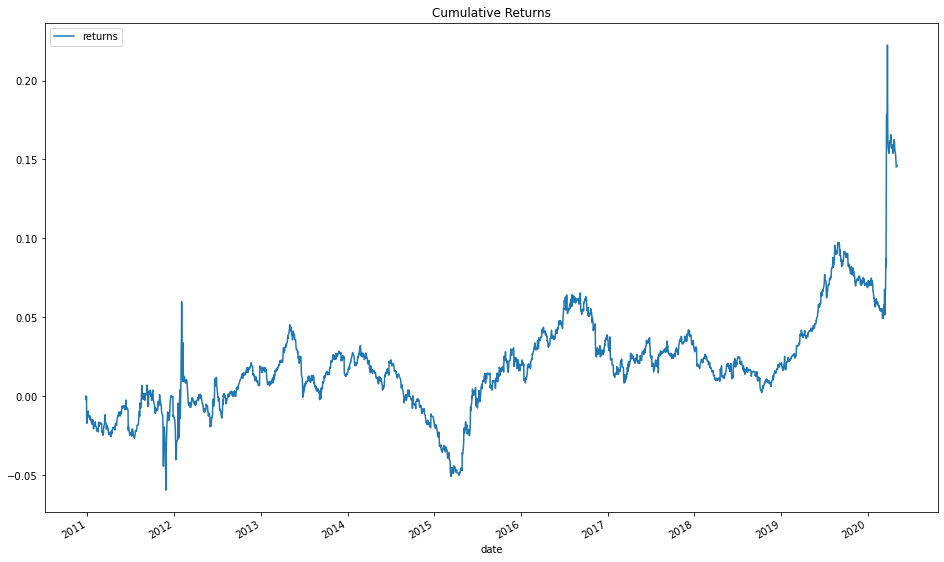

Sharpe Ratio:  0.6251150233273612
Annualized Sharpe Ratio:  9.92339335520723
Maximum Drawdown:  0.11071230630906126
Annualized Return:  4.942636504052349
Annualized Volatility:  0.4980792685658012
Sortino Ratio:  1.5356016518263662
Annualized Sortino Ratio:  24.376920501555357
Calmar Ratio:  44.643966590801824
Omega Ratio:  6.300638415912323
Skewness:  1.3129053690385364
----------------------------------------------------------------------------
The Cumulative Returns for EUN4 GR Equity in the Test Set: 


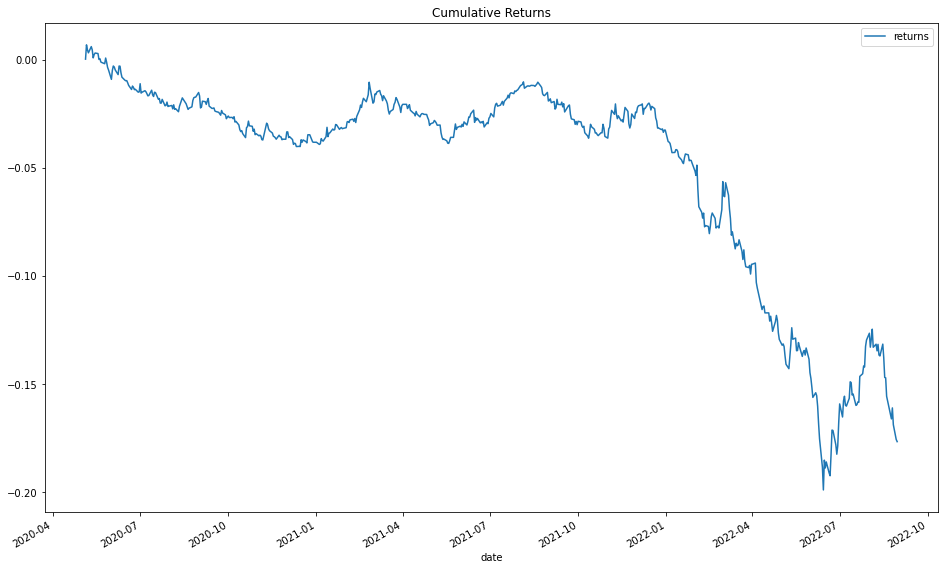

Sharpe Ratio:  -1.0364137391918085
Annualized Sharpe Ratio:  -16.45255805563249
Maximum Drawdown:  0.20589355599337422
Annualized Return:  -12.565817578756452
Annualized Volatility:  0.7637607195347095
Sortino Ratio:  -1.0389785326733494
Annualized Sortino Ratio:  -16.49327288993087
Calmar Ratio:  -61.03065012467329
Omega Ratio:  0.001183603304532737
Skewness:  -1.4677736386942004
----------------------------------------------------------------------------
The column EUN4 GR Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('EUN4 GY Equity', 'cluster_Environmental Impact')
----------------------------------------------------------------------------
The Cumulative Returns for EUN4 GY Equity in the Training Set: 


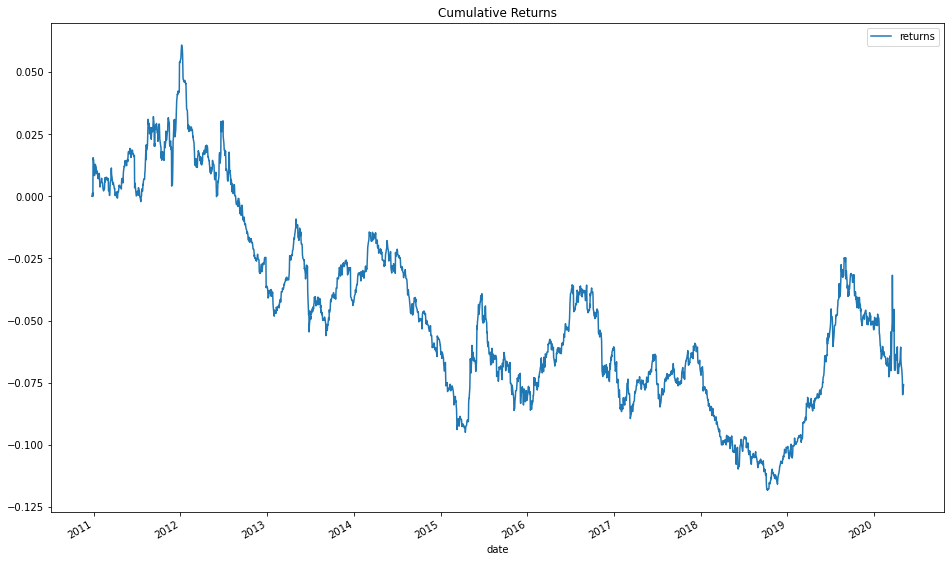

Sharpe Ratio:  -1.2296279964922843
Annualized Sharpe Ratio:  -19.51973930304712
Maximum Drawdown:  0.1790233576572643
Annualized Return:  -11.797518587705225
Annualized Volatility:  0.6043891470345395
Sortino Ratio:  -1.7734528608563231
Annualized Sortino Ratio:  -28.152691390331196
Calmar Ratio:  -65.89932588735866
Omega Ratio:  0.05811187985020347
Skewness:  0.4407554493757612
----------------------------------------------------------------------------
The Cumulative Returns for EUN4 GY Equity in the Test Set: 


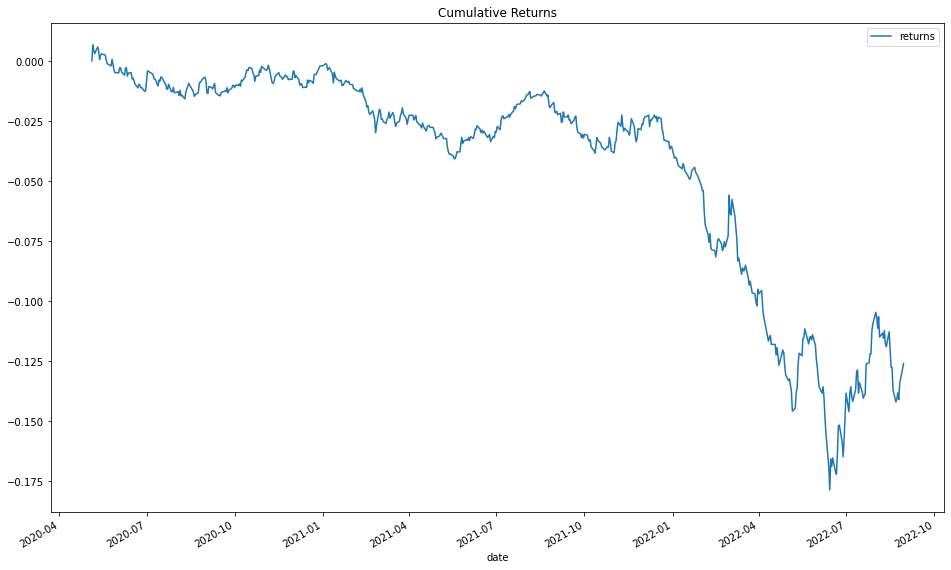

Sharpe Ratio:  -0.9446912280677241
Annualized Sharpe Ratio:  -14.996508331268396
Maximum Drawdown:  0.18543484152452305
Annualized Return:  -10.819295369192478
Annualized Volatility:  0.7214542965734071
Sortino Ratio:  -0.9451386017096257
Annualized Sortino Ratio:  -15.003610167665977
Calmar Ratio:  -58.345536794721866
Omega Ratio:  0.0014673535364721543
Skewness:  -1.2776636169933386
----------------------------------------------------------------------------
The column EUN4 GY Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('EUNS GY Equity', 'cluster_Environmental Impact')
----------------------------------------------------------------------------
The Cumulative Returns for EUNS GY Equity in the Training Set: 


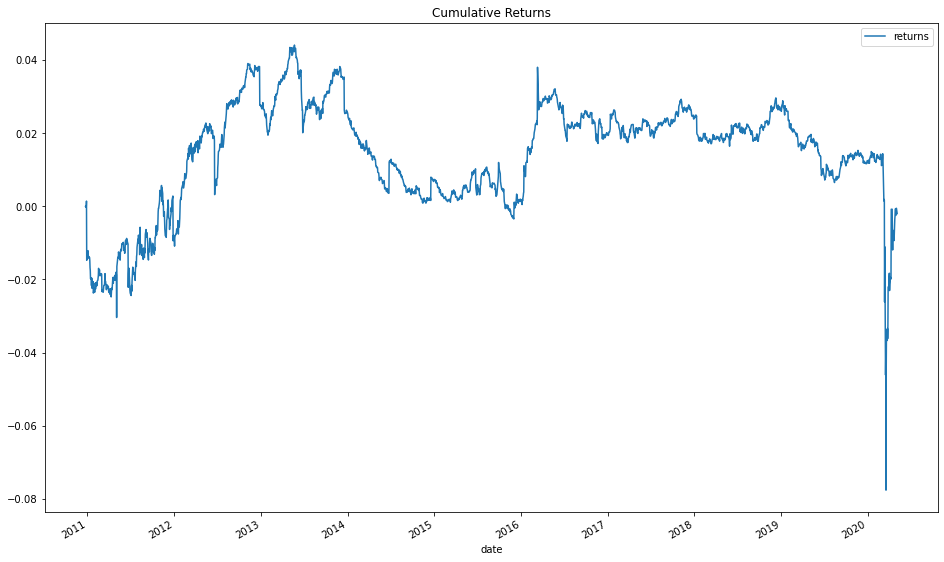

Sharpe Ratio:  0.983148134876276
Annualized Sharpe Ratio:  15.606992800917684
Maximum Drawdown:  0.12171423155060157
Annualized Return:  3.610704774782755
Annualized Volatility:  0.23135172937162163
Sortino Ratio:  1.59038794993461
Annualized Sortino Ratio:  25.24662602184493
Calmar Ratio:  29.665428017607272
Omega Ratio:  8.927604133854487
Skewness:  -0.9007068834411224
----------------------------------------------------------------------------
The Cumulative Returns for EUNS GY Equity in the Test Set: 


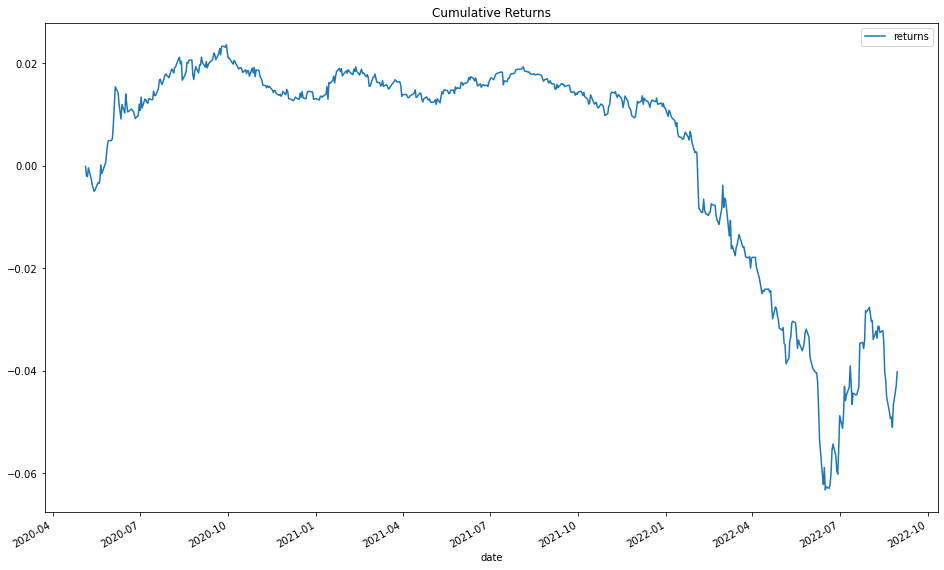

Sharpe Ratio:  0.14790593694398915
Annualized Sharpe Ratio:  2.3479339595027757
Maximum Drawdown:  0.08678520783922072
Annualized Return:  0.798310274112356
Annualized Volatility:  0.34000542088560914
Sortino Ratio:  0.1891441079555499
Annualized Sortino Ratio:  3.002569629621232
Calmar Ratio:  9.198690583207622
Omega Ratio:  1.4116094375066388
Skewness:  -1.4837454763855138
----------------------------------------------------------------------------
The column EUNS GY Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('F5ESG SW Equity', 'cluster_Environmental Impact')
----------------------------------------------------------------------------
The Cumulative Returns for F5ESG SW Equity in the Training Set: 


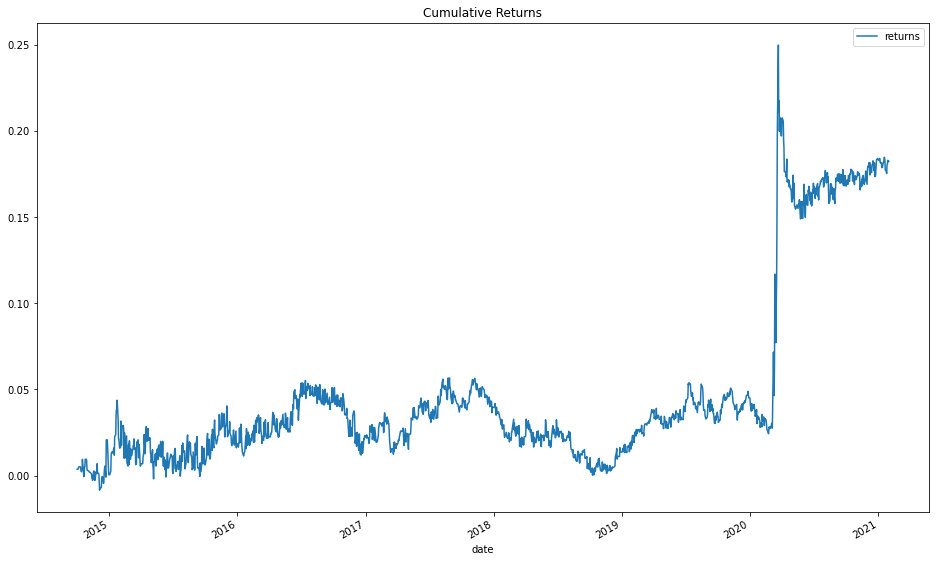

Sharpe Ratio:  0.9029928723265394
Annualized Sharpe Ratio:  14.334567455039533
Maximum Drawdown:  0.10094726131384546
Annualized Return:  11.897889691059422
Annualized Volatility:  0.8300138618327504
Sortino Ratio:  18.77503433097748
Annualized Sortino Ratio:  298.0444301787982
Calmar Ratio:  117.86243169162195
Omega Ratio:  1218.8359836620207
Skewness:  1.8380962968127743
----------------------------------------------------------------------------
The Cumulative Returns for F5ESG SW Equity in the Test Set: 


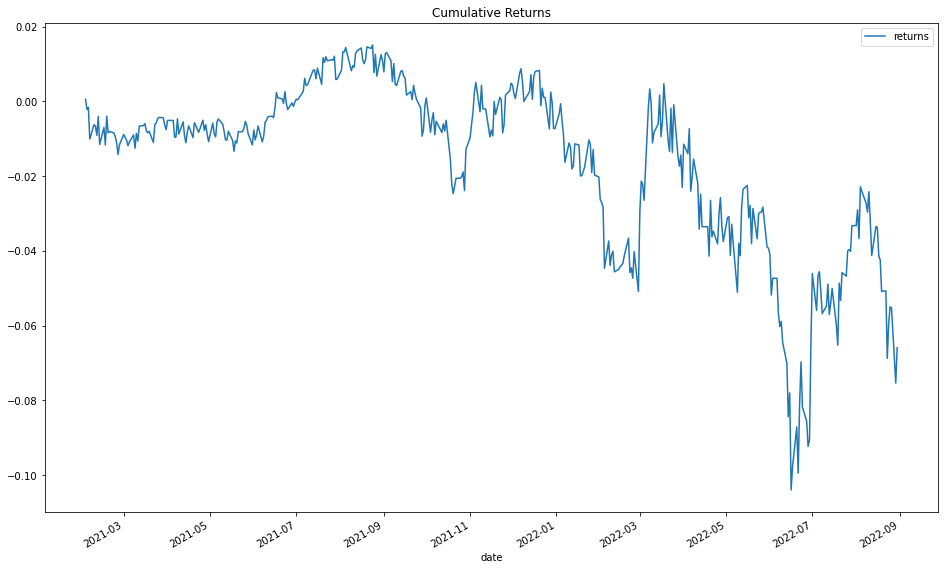

Sharpe Ratio:  -0.7171197878066228
Annualized Sharpe Ratio:  -11.3839237126784
Maximum Drawdown:  0.11909258938939815
Annualized Return:  -4.156036906542334
Annualized Volatility:  0.36507947623662573
Sortino Ratio:  -0.7590876836854663
Annualized Sortino Ratio:  -12.050143405942835
Calmar Ratio:  -34.897527443569984
Omega Ratio:  0.08544181320672571
Skewness:  -1.2240865807431585
----------------------------------------------------------------------------
The column F5ESG SW Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('IEAG NA Equity', 'cluster_Environmental Impact')
----------------------------------------------------------------------------
The Cumulative Returns for IEAG NA Equity in the Training Set: 


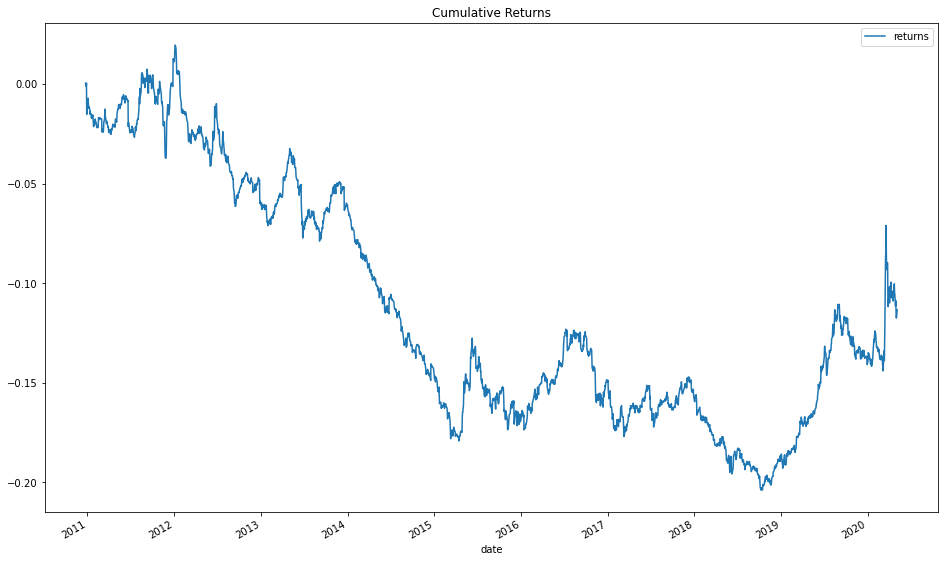

Sharpe Ratio:  -1.8686162249191223
Annualized Sharpe Ratio:  -29.663362961738002
Maximum Drawdown:  0.2234402464224644
Annualized Return:  -28.432066120637018
Annualized Volatility:  0.958490989619444
Sortino Ratio:  -1.934905706710146
Annualized Sortino Ratio:  -30.715675861888364
Calmar Ratio:  -127.24684373503489
Omega Ratio:  0.0011161245369308843
Skewness:  0.5012582010461369
----------------------------------------------------------------------------
The Cumulative Returns for IEAG NA Equity in the Test Set: 


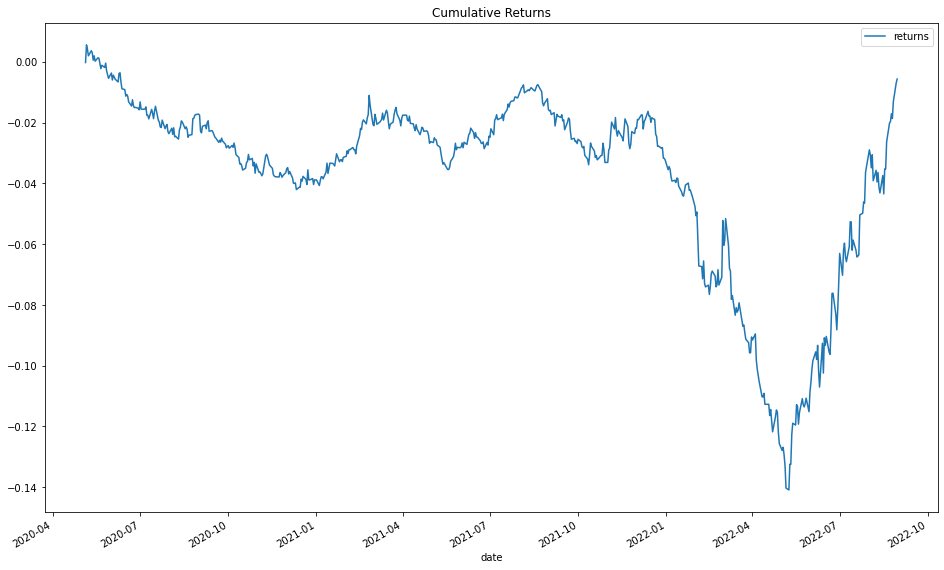

Sharpe Ratio:  -1.2550464369825187
Annualized Sharpe Ratio:  -19.923244536560652
Maximum Drawdown:  0.14645724744480781
Annualized Return:  -9.50947180672221
Annualized Volatility:  0.4773053801187661
Sortino Ratio:  -1.2636985659286681
Annualized Sortino Ratio:  -20.060592825577302
Calmar Ratio:  -64.93001864114537
Omega Ratio:  0.0010301395143868743
Skewness:  -1.5378649574775545
----------------------------------------------------------------------------
The column IEAG NA Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('JBEM FP Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for JBEM FP Equity in the Training Set: 


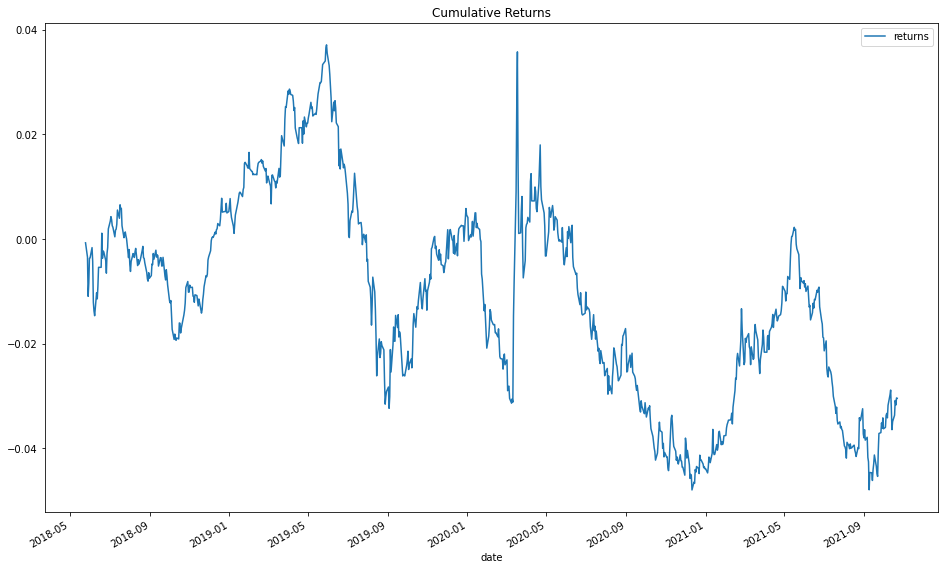

Sharpe Ratio:  -0.5902837584767344
Annualized Sharpe Ratio:  -9.370464167339726
Maximum Drawdown:  0.08508750240099616
Annualized Return:  -2.8524562185878266
Annualized Volatility:  0.3044092766001835
Sortino Ratio:  -0.8417958898008533
Annualized Sortino Ratio:  -13.363095474536347
Calmar Ratio:  -33.523797715261544
Omega Ratio:  0.2253481335944979
Skewness:  0.10333344604022746
----------------------------------------------------------------------------
The Cumulative Returns for JBEM FP Equity in the Test Set: 


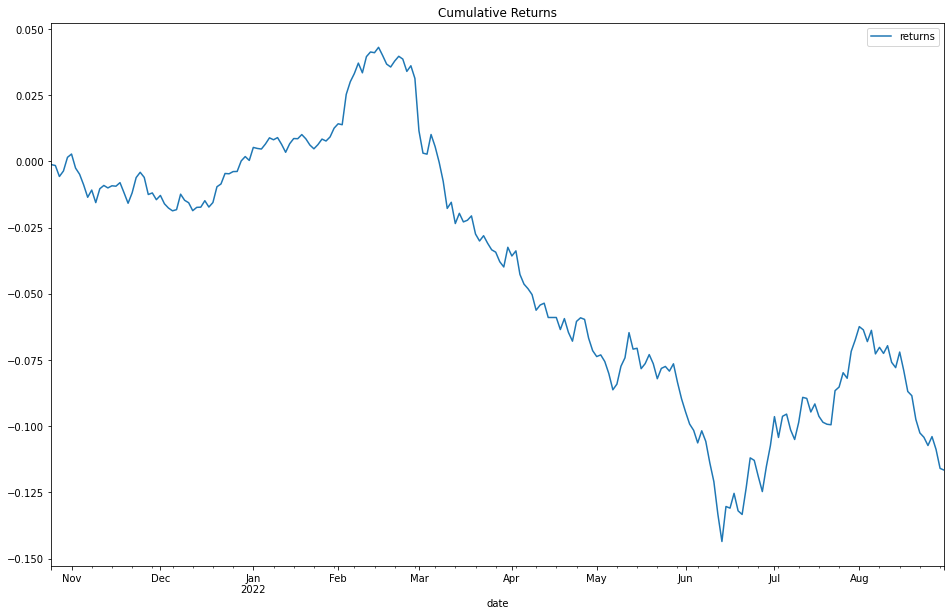

Sharpe Ratio:  -0.875055246676218
Annualized Sharpe Ratio:  -13.891071396885316
Maximum Drawdown:  0.18660003911668877
Annualized Return:  -10.574794225858781
Annualized Volatility:  0.7612655585536681
Sortino Ratio:  -1.0615776625822986
Annualized Sortino Ratio:  -16.852022955444
Calmar Ratio:  -56.67091108831935
Omega Ratio:  0.08598478703744648
Skewness:  -0.12022632760839674
----------------------------------------------------------------------------
The column JBEM FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('QDVL GY Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for QDVL GY Equity in the Training Set: 


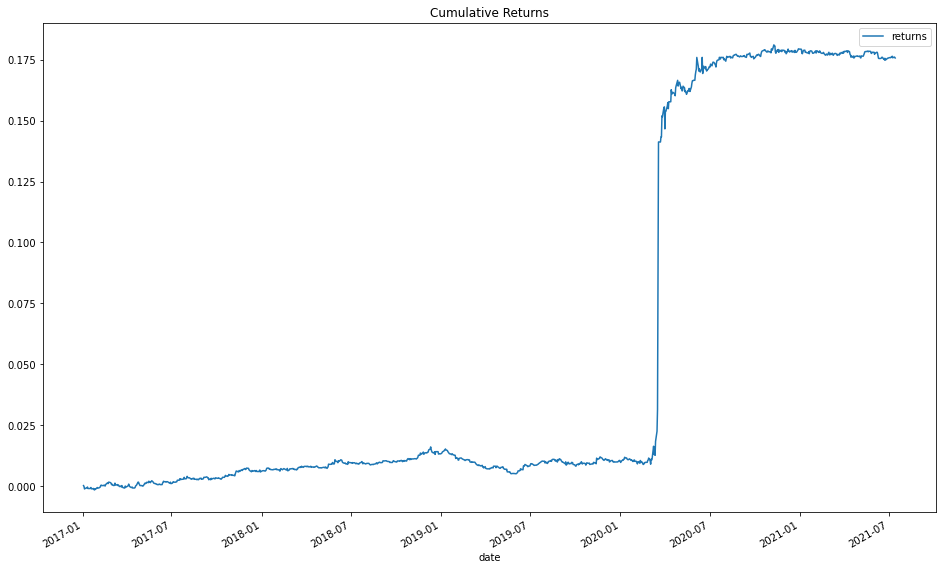

Sharpe Ratio:  0.7389228908799523
Annualized Sharpe Ratio:  11.730037243927628
Maximum Drawdown:  0.011036392091238079
Annualized Return:  14.172035427734189
Annualized Volatility:  1.2081833273863412
Sortino Ratio:  163.6981315125209
Annualized Sortino Ratio:  2598.6272764084556
Calmar Ratio:  1284.1185154146103
Omega Ratio:  2241.744266559716
Skewness:  0.9099856039441513
----------------------------------------------------------------------------
The Cumulative Returns for QDVL GY Equity in the Test Set: 


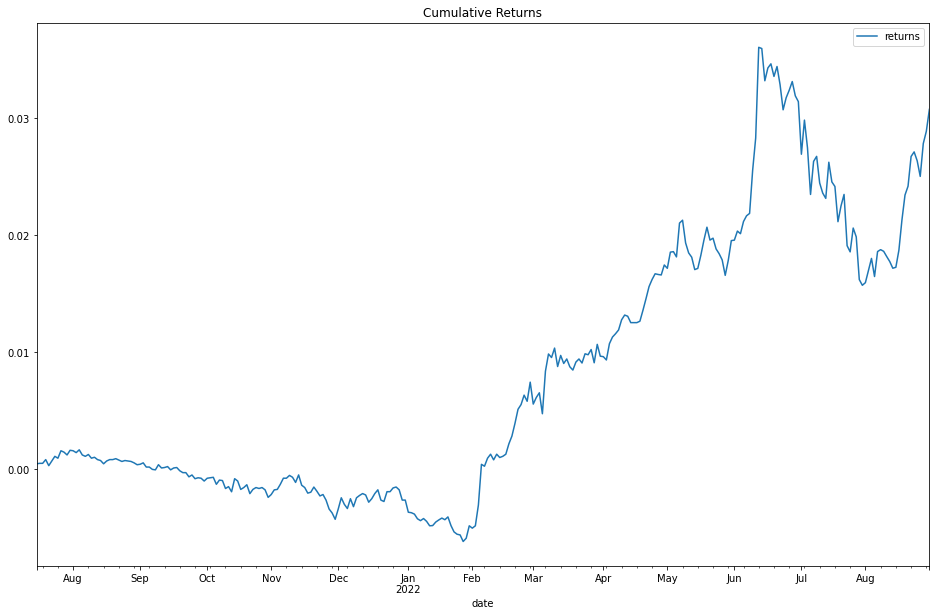

Sharpe Ratio:  0.6992310152688663
Annualized Sharpe Ratio:  11.099948252307767
Maximum Drawdown:  0.020364847434228617
Annualized Return:  2.000477024810047
Annualized Volatility:  0.18022399558431565
Sortino Ratio:  5.164603192400349
Annualized Sortino Ratio:  81.98553400452955
Calmar Ratio:  98.2318689727921
Omega Ratio:  10.55694006277551
Skewness:  0.7349583210361975
----------------------------------------------------------------------------
The column QDVL GY Equity does not have enough data.
----------------------------------------------------------------------------
----------------------------------------------------------------------------
The column TAEH IM Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('TAHY LN Equity', 'cluster_Research')
----------------------------------------------------------------------------
The Cumulative Returns for TAHY LN Equity in the 

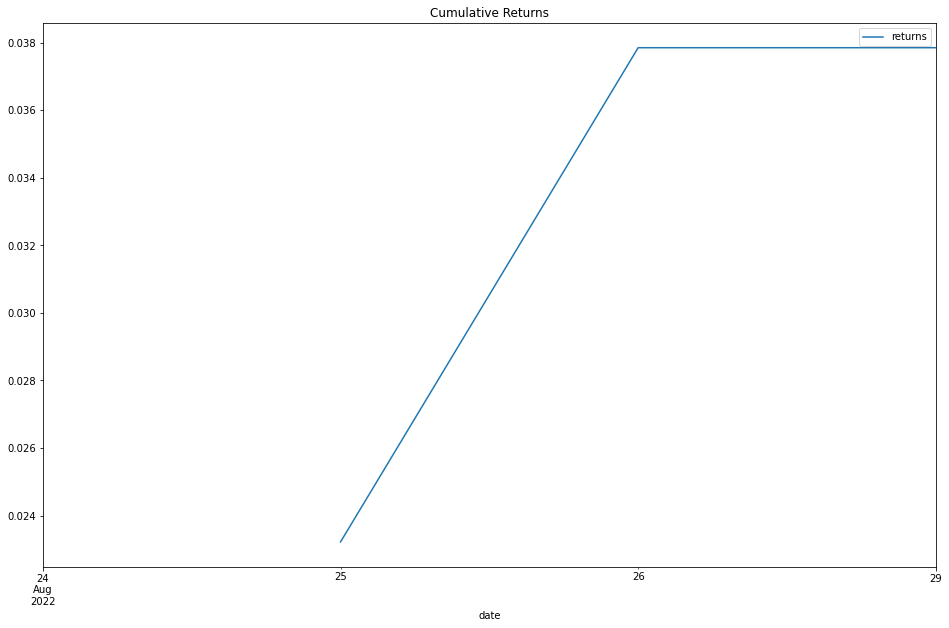

Sharpe Ratio:  3.9041177111550542
Annualized Sharpe Ratio:  61.97594731703384
Maximum Drawdown:  0.0
Annualized Return:  8.309623900312584
Annualized Volatility:  0.1340782071116276
Sortino Ratio:  nan
Annualized Sortino Ratio:  nan
Calmar Ratio:  inf
Omega Ratio:  inf
Skewness:  -1.7320508075688754
----------------------------------------------------------------------------
The Cumulative Returns for TAHY LN Equity in the Test Set: 


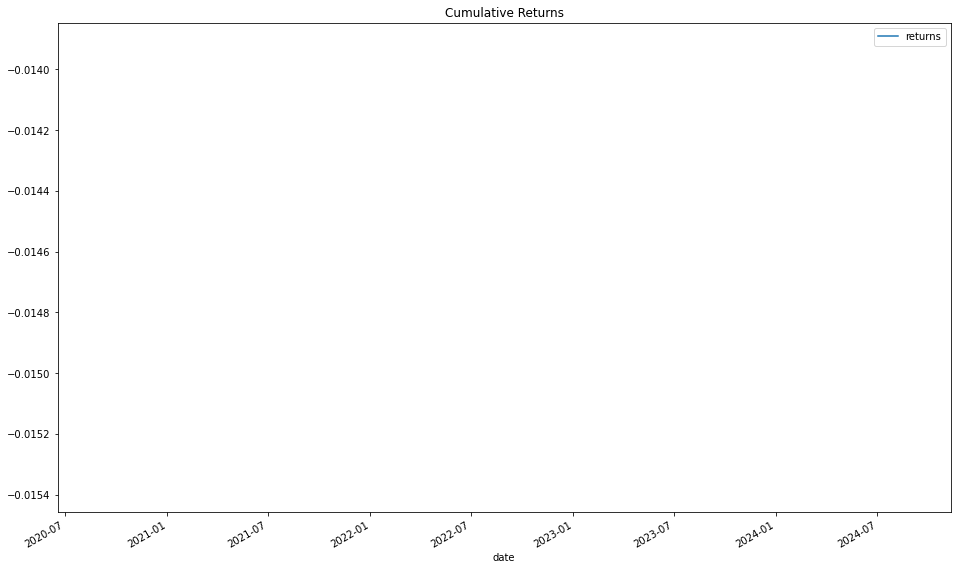

Sharpe Ratio:  nan
Annualized Sharpe Ratio:  nan
Maximum Drawdown:  0.0
Annualized Return:  -3.692307692307679
Annualized Volatility:  nan
Sortino Ratio:  nan
Annualized Sortino Ratio:  nan
Calmar Ratio:  -inf
Omega Ratio:  0.0
Skewness:  nan
----------------------------------------------------------------------------
The column TAHY LN Equity does not have enough data.
----------------------------------------------------------------------------


In [207]:
cumulative_return_df = pd.DataFrame(index=esg_ret_filt_mkt.index, columns=esg_ret_filt_mkt.columns)
cumulative_return_df_TEST = pd.DataFrame(index=esg_ret_filt_mkt.index, columns=esg_ret_filt_mkt.columns)

for i in range(0, len(esg_ret_filt_mkt.columns)):
    try:  
        rolling_params1_1 = rolling_params1.iloc[:,i*5+1:i*5+5]
        trading_signals1 = generate_trading_signals(rolling_params1_1)
        strategy_returns1, strategy_returns2  = backtest(trading_signals1, esg_ret_filt_mkt,i)
        print("----------------------------------------------------------------------------")
        print("The Cumulative Returns for " + esg_ret_filt_mkt.columns[i] + " in the Training Set: ")
        strategy_returns1 = plot_cumulative_returns(strategy_returns1)
        print("----------------------------------------------------------------------------")
        print("The Cumulative Returns for " + esg_ret_filt_mkt.columns[i] + " in the Test Set: ")
        strategy_returns2 = plot_cumulative_returns(strategy_returns2)
        cumulative_return_df.iloc[:,i] = strategy_returns1['returns']
        cumulative_return_df_TEST.iloc[:,i] = strategy_returns2['returns']
        print("----------------------------------------------------------------------------")
    except:
        print("----------------------------------------------------------------------------")
        print("The column " + esg_ret_filt_mkt.columns[i] + " does not have enough data.")
        print("----------------------------------------------------------------------------")

In [206]:
cumulative_return_df_TEST

Security    00878 TT Equity AEGE GY Equity AFLT FP Equity AFRN FP Equity  \
date                                                                       
2010-01-04              NaN            NaN            NaN            NaN   
2010-01-05              NaN            NaN            NaN            NaN   
2010-01-06              NaN            NaN            NaN            NaN   
2010-01-07              NaN            NaN            NaN            NaN   
2010-01-08              NaN            NaN            NaN            NaN   
...                     ...            ...            ...            ...   
2022-08-24            0.039            NaN            NaN            NaN   
2022-08-25            0.035            NaN            NaN            NaN   
2022-08-26            0.030            NaN            NaN            NaN   
2022-08-29            0.044            NaN            NaN            NaN   
2022-08-30            0.040            NaN            NaN            NaN   

Security   CHESG SW Equity CRP FP Equity EAGG US Equity EFRN GY Equity  \
date                                                                     
2010-01-04             NaN           NaN            NaN            NaN   
2010-01-05             NaN           NaN            NaN            NaN   
2010-01-06             NaN           NaN            NaN            NaN   
2010-01-07             NaN           NaN            NaN            NaN   
2010-01-08             NaN           NaN            NaN            NaN   
...                    ...           ...            ...            ...   
2022-08-24             NaN           NaN            NaN            NaN   
2022-08-25             NaN           NaN            NaN            NaN   
2022-08-26             NaN           NaN            NaN            NaN   
2022-08-29             NaN           NaN            NaN            NaN   
2022-08-30             NaN           NaN            NaN            NaN   

Security   ESGB CN Equity ESGEMC SW Equity  ... ESGUS SP Equity  \
date                                        ...                   
2010-01-04            NaN              NaN  ...             NaN   
2010-01-05            NaN              NaN  ...             NaN   
2010-01-06            NaN              NaN  ...             NaN   
2010-01-07            NaN              NaN  ...             NaN   
2010-01-08            NaN              NaN  ...             NaN   
...                   ...              ...  ...             ...   
2022-08-24            NaN              NaN  ...             NaN   
2022-08-25            NaN              NaN  ...             NaN   
2022-08-26            NaN              NaN  ...             NaN   
2022-08-29            NaN              NaN  ...             NaN   
2022-08-30            NaN              NaN  ...             NaN   

Security   EUN4 GR Equity EUN4 GY Equity EUNS GY Equity F5ESG SW Equity  \
date                                                                      
2010-01-04            NaN            NaN            NaN             NaN   
2010-01-05            NaN            NaN            NaN             NaN   
2010-01-06            NaN            NaN            NaN             NaN   
2010-01-07            NaN            NaN            NaN             NaN   
2010-01-08            NaN            NaN            NaN             NaN   
...                   ...            ...            ...             ...   
2022-08-24            NaN            NaN            NaN             NaN   
2022-08-25            NaN            NaN            NaN             NaN   
2022-08-26            NaN            NaN            NaN             NaN   
2022-08-29            NaN            NaN            NaN             NaN   
2022-08-30            NaN            NaN            NaN             NaN   

Security   IEAG NA Equity JBEM FP Equity QDVL GY Equity TAEH IM Equity  \
date                                                                     
2010-01-04            NaN            NaN            

In [ ]:
# Find a linear combination of the Security in the cumulative_return_df such that the cumulative returns are maximized, subject to the constraint that the weights sum to 1.
# Create a list of the stocks in the cumulative_return_df
stocks = list(cumulative_return_df.columns)
# Import the maximize function from scipy.optimize
from scipy.optimize import minimize
# Create a function to minimize
